In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import joblib

In [2]:
df = pd.read_csv("cloudburst.csv")
pd.set_option("display.max_columns", None)
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,CloudBurst Today,CloudBurstTomorrow
0,01-12-2008,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,02-12-2008,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,03-12-2008,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,04-12-2008,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,05-12-2008,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
numerical_feature = [feature for feature in df.columns if df[feature].dtypes != 'O']
discrete_feature=[feature for feature in numerical_feature if len(df[feature].unique())<25]
continuous_feature = [feature for feature in numerical_feature if feature not in discrete_feature]
categorical_feature = [feature for feature in df.columns if feature not in numerical_feature]
print("Numerical Features Count {}".format(len(numerical_feature)))
print("Discrete feature Count {}".format(len(discrete_feature)))
print("Continuous feature Count {}".format(len(continuous_feature)))
print("Categorical feature Count {}".format(len(categorical_feature)))

Numerical Features Count 16
Discrete feature Count 2
Continuous feature Count 14
Categorical feature Count 7


In [4]:
# Handle Missing Values
df.isnull().sum()*100/len(df)

Date                   0.000000
Location               0.000000
MinTemp                1.020899
MaxTemp                0.866905
Rainfall               2.241853
Evaporation           43.166506
Sunshine              48.009762
WindGustDir            7.098859
WindGustSpeed          7.055548
WindDir9am             7.263853
WindDir3pm             2.906641
WindSpeed9am           1.214767
WindSpeed3pm           2.105046
Humidity9am            1.824557
Humidity3pm            3.098446
Pressure9am           10.356799
Pressure3pm           10.331363
Cloud9am              38.421559
Cloud3pm              40.807095
Temp9am                1.214767
Temp3pm                2.481094
CloudBurst Today       2.241853
CloudBurstTomorrow     2.245978
dtype: float64

In [5]:
print(numerical_feature)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']


In [6]:
def randomsampleimputation(df, variable):
    df[variable]=df[variable]
    random_sample=df[variable].dropna().sample(df[variable].isnull().sum(),random_state=0)
    random_sample.index=df[df[variable].isnull()].index
    df.loc[df[variable].isnull(),variable]=random_sample

In [7]:
randomsampleimputation(df, "Cloud9am")
randomsampleimputation(df, "Cloud3pm")
randomsampleimputation(df, "Evaporation")
randomsampleimputation(df, "Sunshine")

In [8]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,CloudBurst Today,CloudBurstTomorrow
0,01-12-2008,Albury,13.4,22.9,0.6,2.4,8.3,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,No,No
1,02-12-2008,Albury,7.4,25.1,0.0,3.6,10.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,1.0,17.2,24.3,No,No
2,03-12-2008,Albury,12.9,25.7,0.0,2.6,4.4,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,No,No
3,04-12-2008,Albury,9.2,28.0,0.0,18.4,8.9,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,0.0,5.0,18.1,26.5,No,No
4,05-12-2008,Albury,17.5,32.3,1.0,5.4,3.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


C:\Users\gubil\AppData\Local\Temp\ipykernel_9872\2689263927.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = df.corr(method = "spearman")


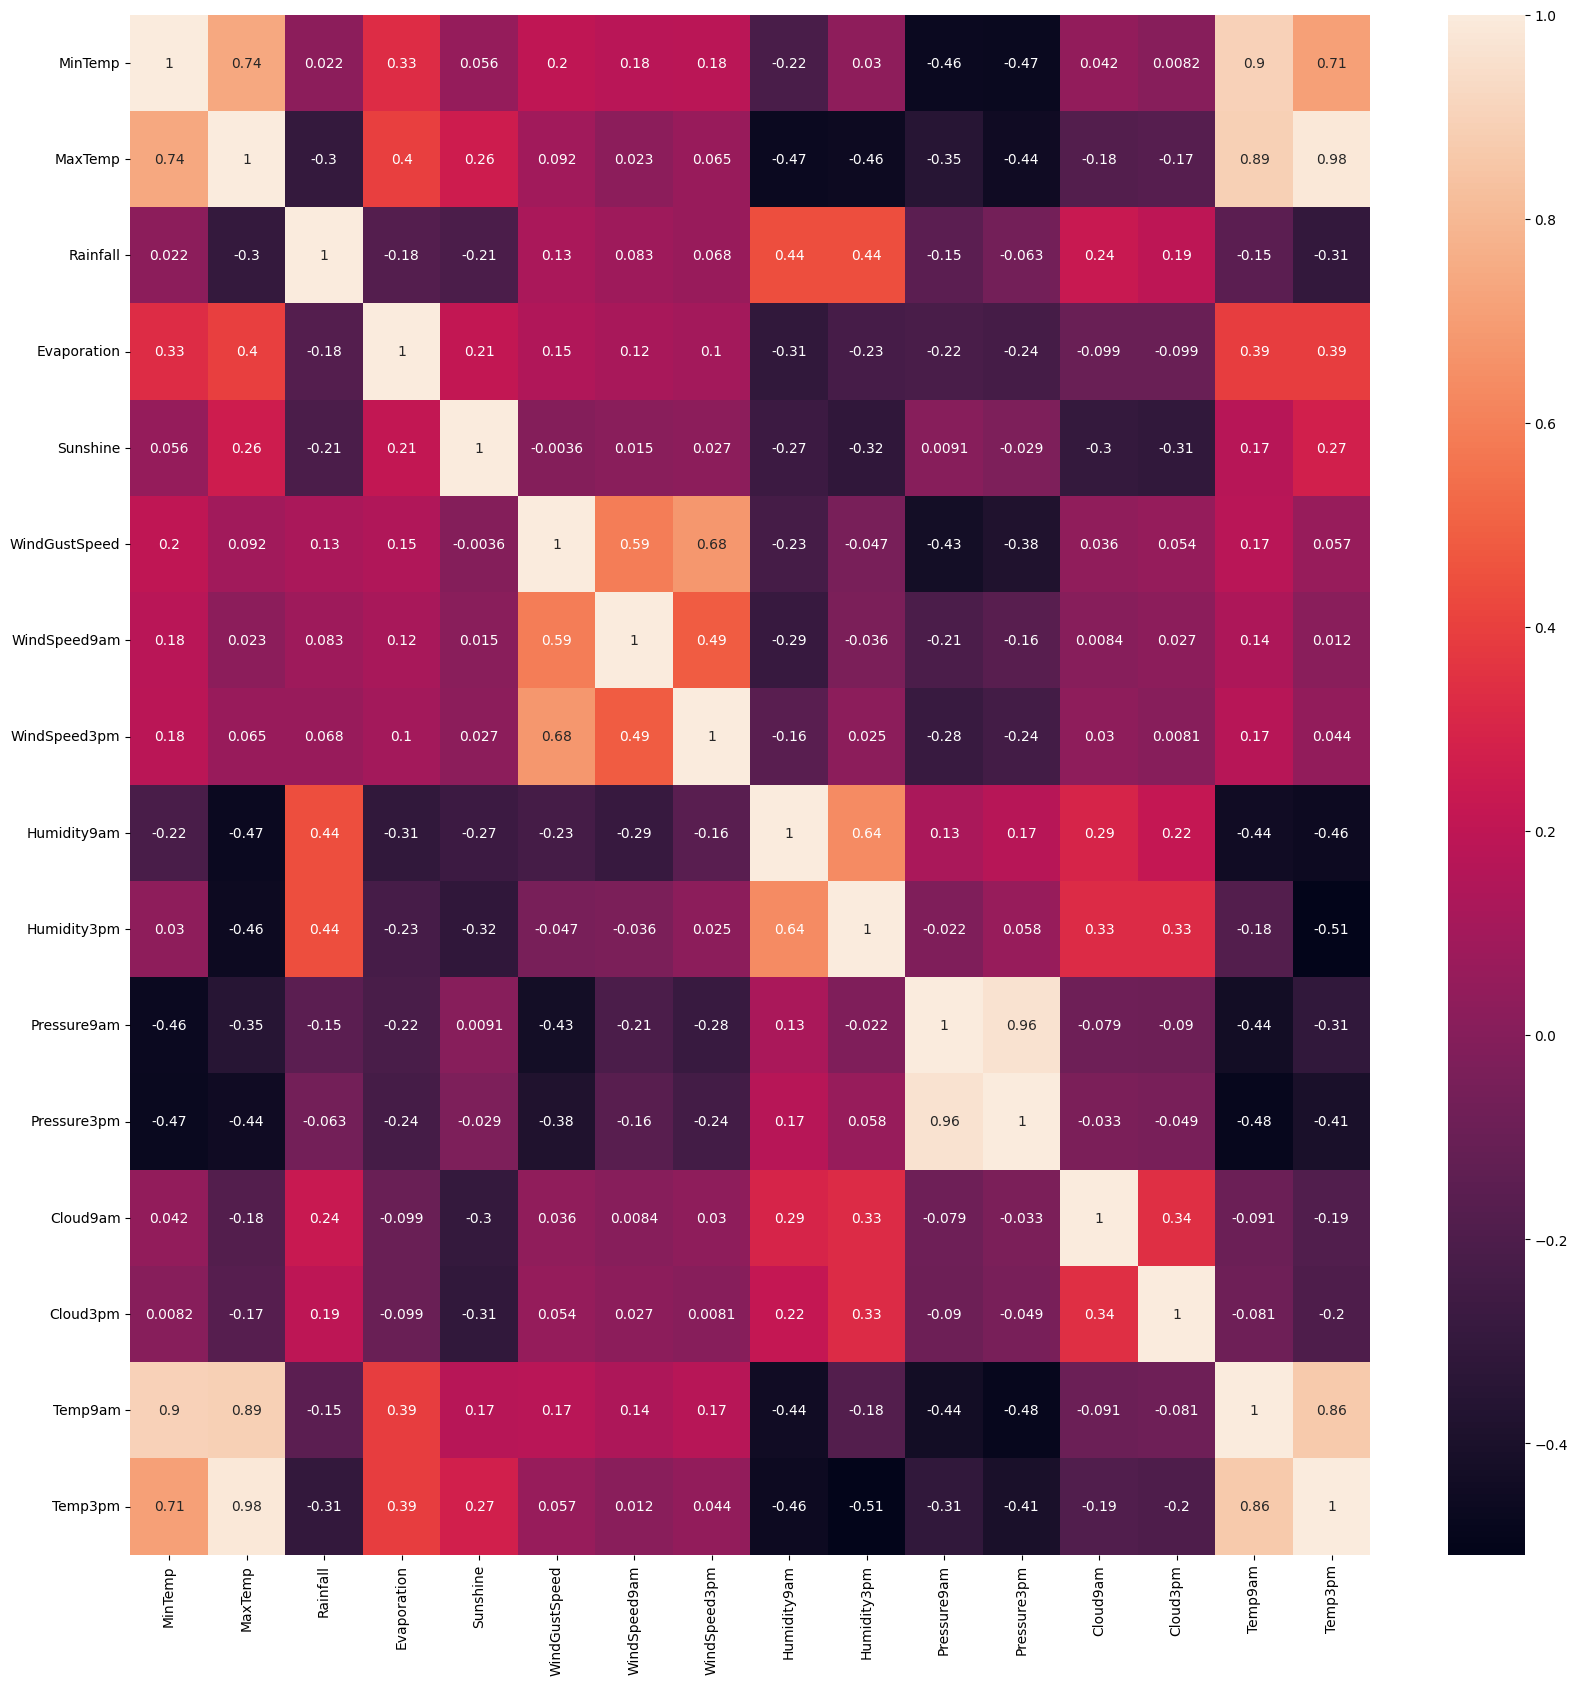

In [9]:
corrmat = df.corr(method = "spearman")
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(corrmat,annot=True)

C:\Users\gubil\AppData\Local\Temp\ipykernel_9872\2600242752.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[feature])


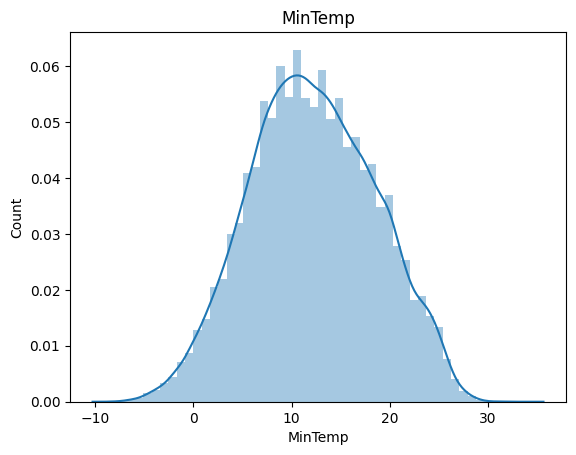

<Figure size 1500x1500 with 0 Axes>

C:\Users\gubil\AppData\Local\Temp\ipykernel_9872\2600242752.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[feature])


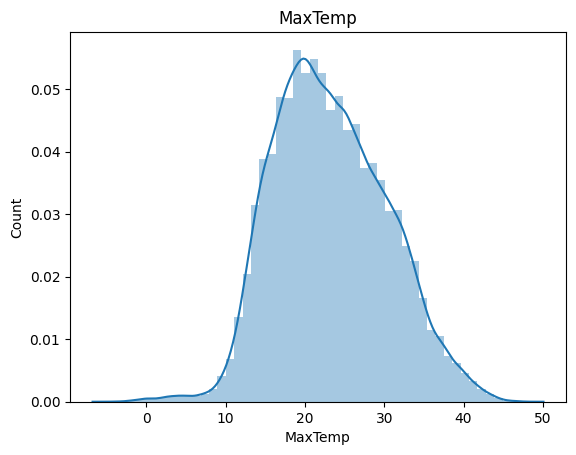

<Figure size 1500x1500 with 0 Axes>

C:\Users\gubil\AppData\Local\Temp\ipykernel_9872\2600242752.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[feature])


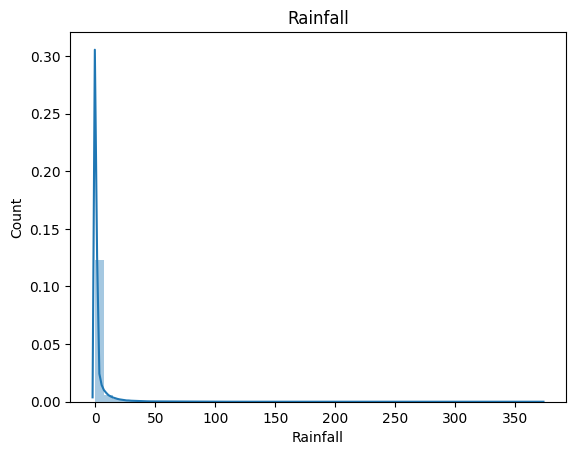

<Figure size 1500x1500 with 0 Axes>

C:\Users\gubil\AppData\Local\Temp\ipykernel_9872\2600242752.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[feature])


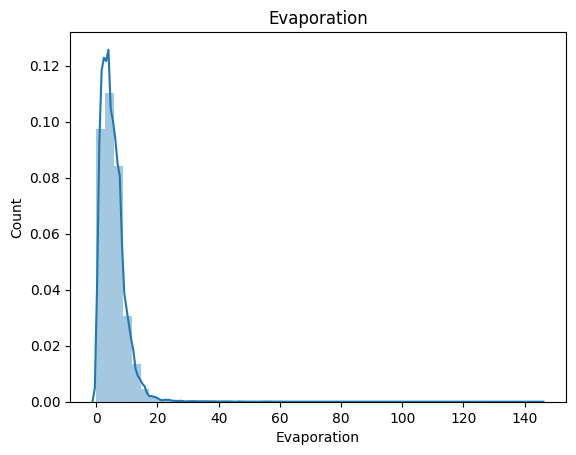

<Figure size 1500x1500 with 0 Axes>

C:\Users\gubil\AppData\Local\Temp\ipykernel_9872\2600242752.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[feature])


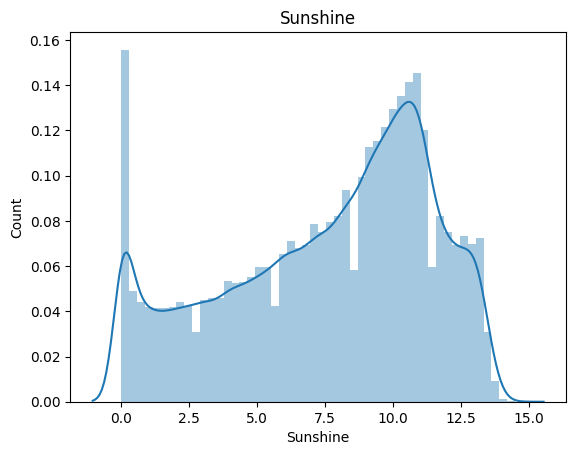

<Figure size 1500x1500 with 0 Axes>

C:\Users\gubil\AppData\Local\Temp\ipykernel_9872\2600242752.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[feature])


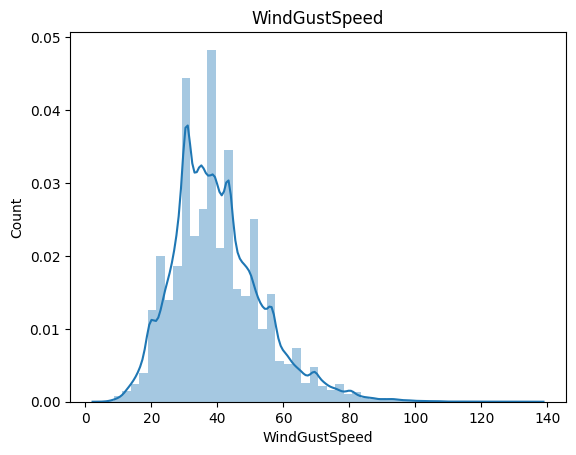

<Figure size 1500x1500 with 0 Axes>

C:\Users\gubil\AppData\Local\Temp\ipykernel_9872\2600242752.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[feature])


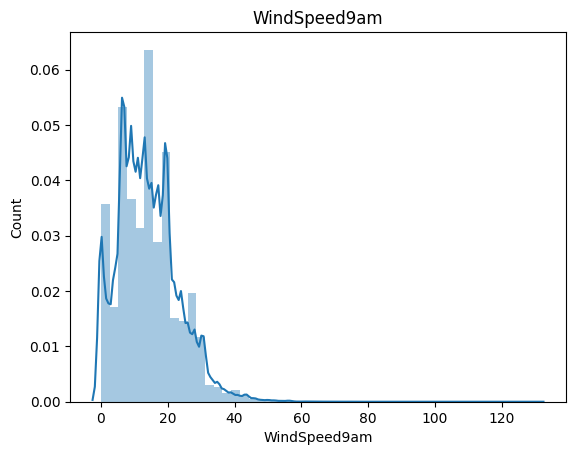

<Figure size 1500x1500 with 0 Axes>

C:\Users\gubil\AppData\Local\Temp\ipykernel_9872\2600242752.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[feature])


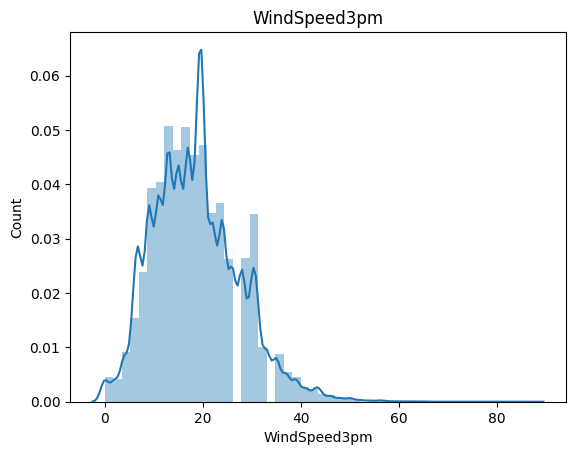

<Figure size 1500x1500 with 0 Axes>

C:\Users\gubil\AppData\Local\Temp\ipykernel_9872\2600242752.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[feature])


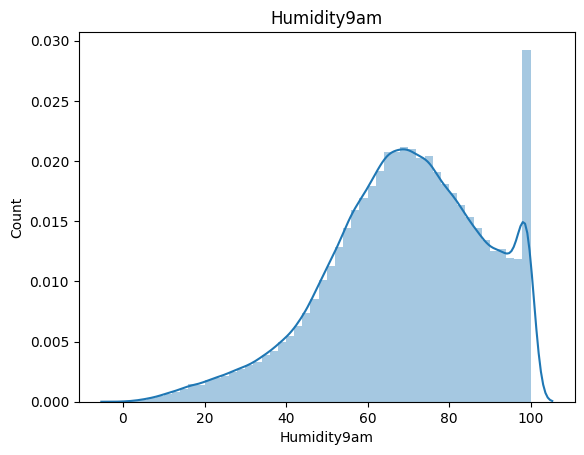

<Figure size 1500x1500 with 0 Axes>

C:\Users\gubil\AppData\Local\Temp\ipykernel_9872\2600242752.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[feature])


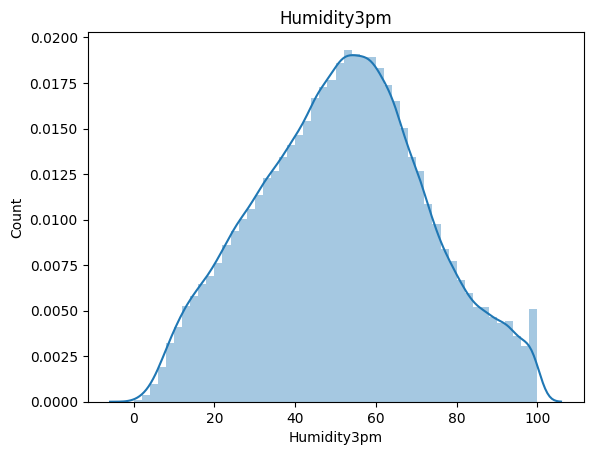

<Figure size 1500x1500 with 0 Axes>

C:\Users\gubil\AppData\Local\Temp\ipykernel_9872\2600242752.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[feature])


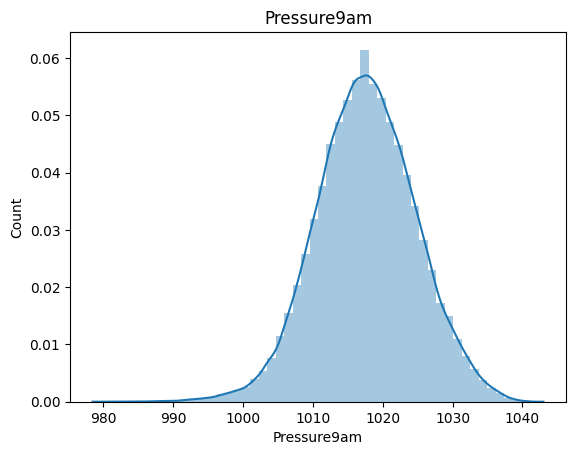

<Figure size 1500x1500 with 0 Axes>

C:\Users\gubil\AppData\Local\Temp\ipykernel_9872\2600242752.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[feature])


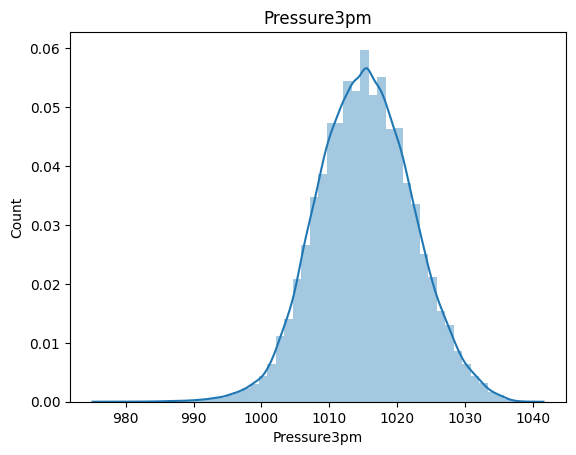

<Figure size 1500x1500 with 0 Axes>

C:\Users\gubil\AppData\Local\Temp\ipykernel_9872\2600242752.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[feature])


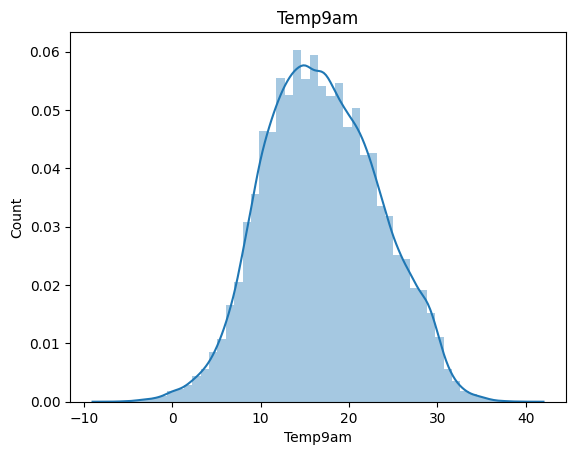

<Figure size 1500x1500 with 0 Axes>

C:\Users\gubil\AppData\Local\Temp\ipykernel_9872\2600242752.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[feature])


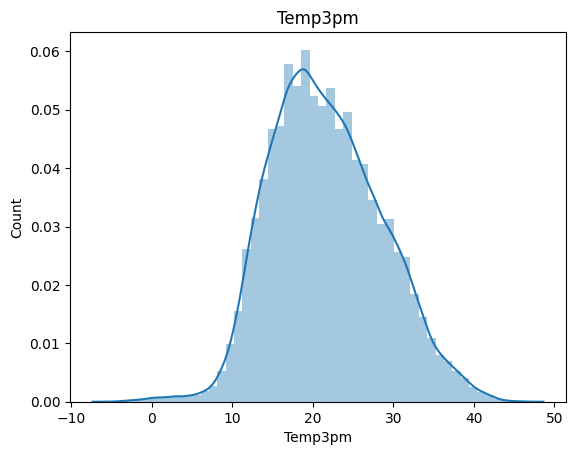

<Figure size 1500x1500 with 0 Axes>

In [10]:
for feature in continuous_feature:
    data=df.copy()
    sns.distplot(df[feature])
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.figure(figsize=(15,15))
    plt.show()

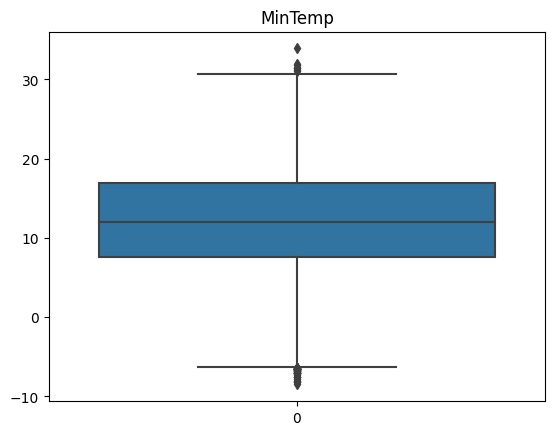

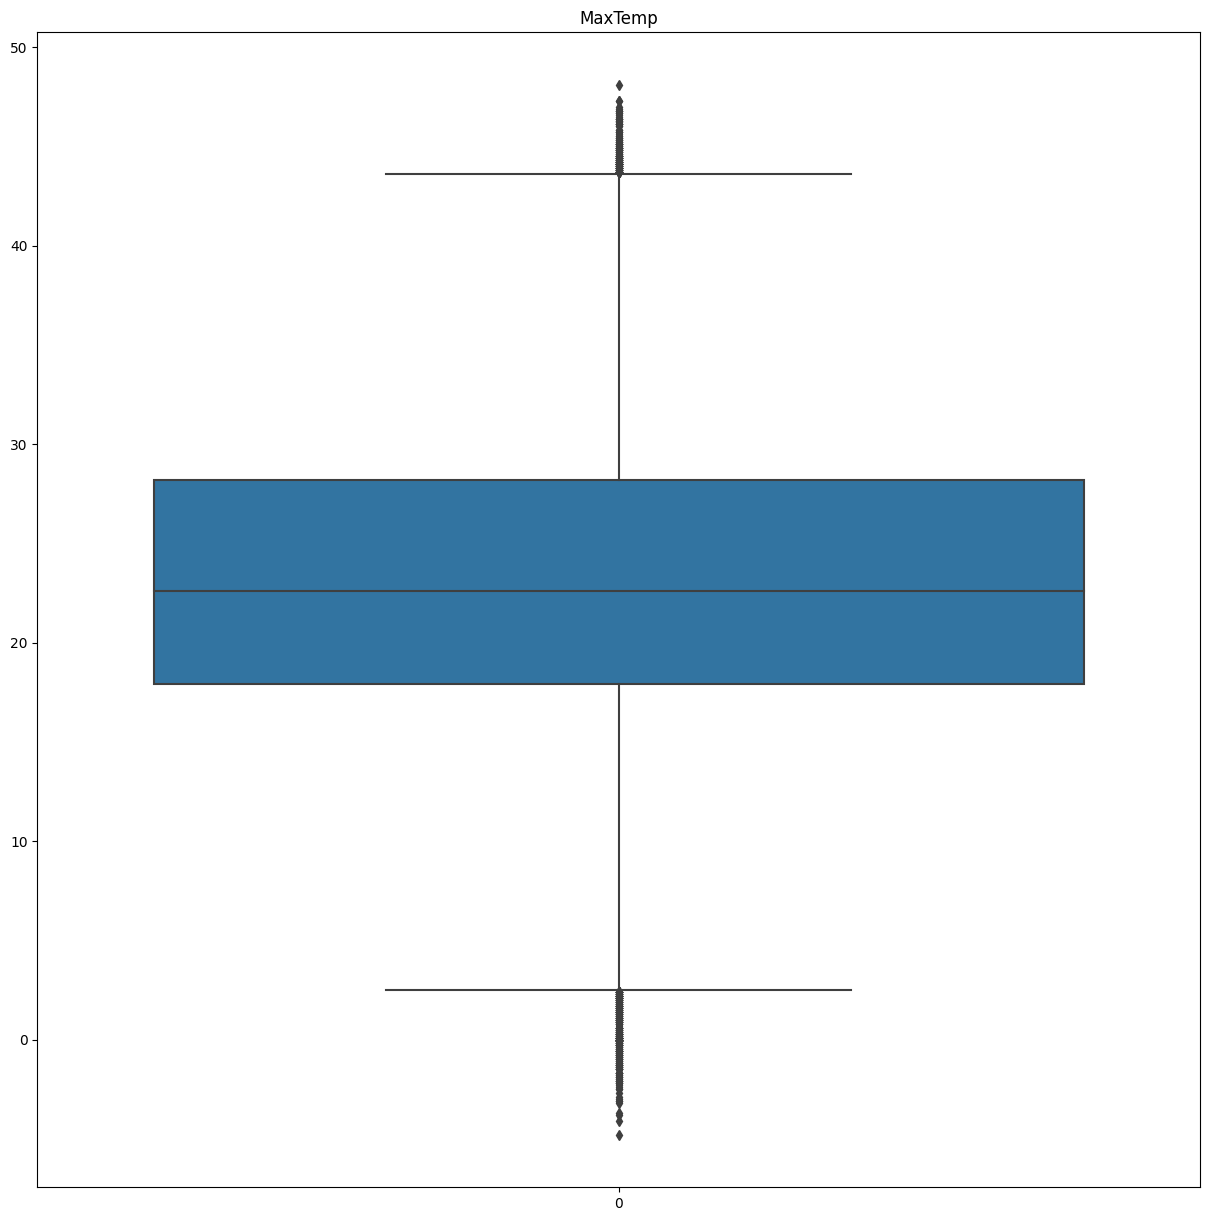

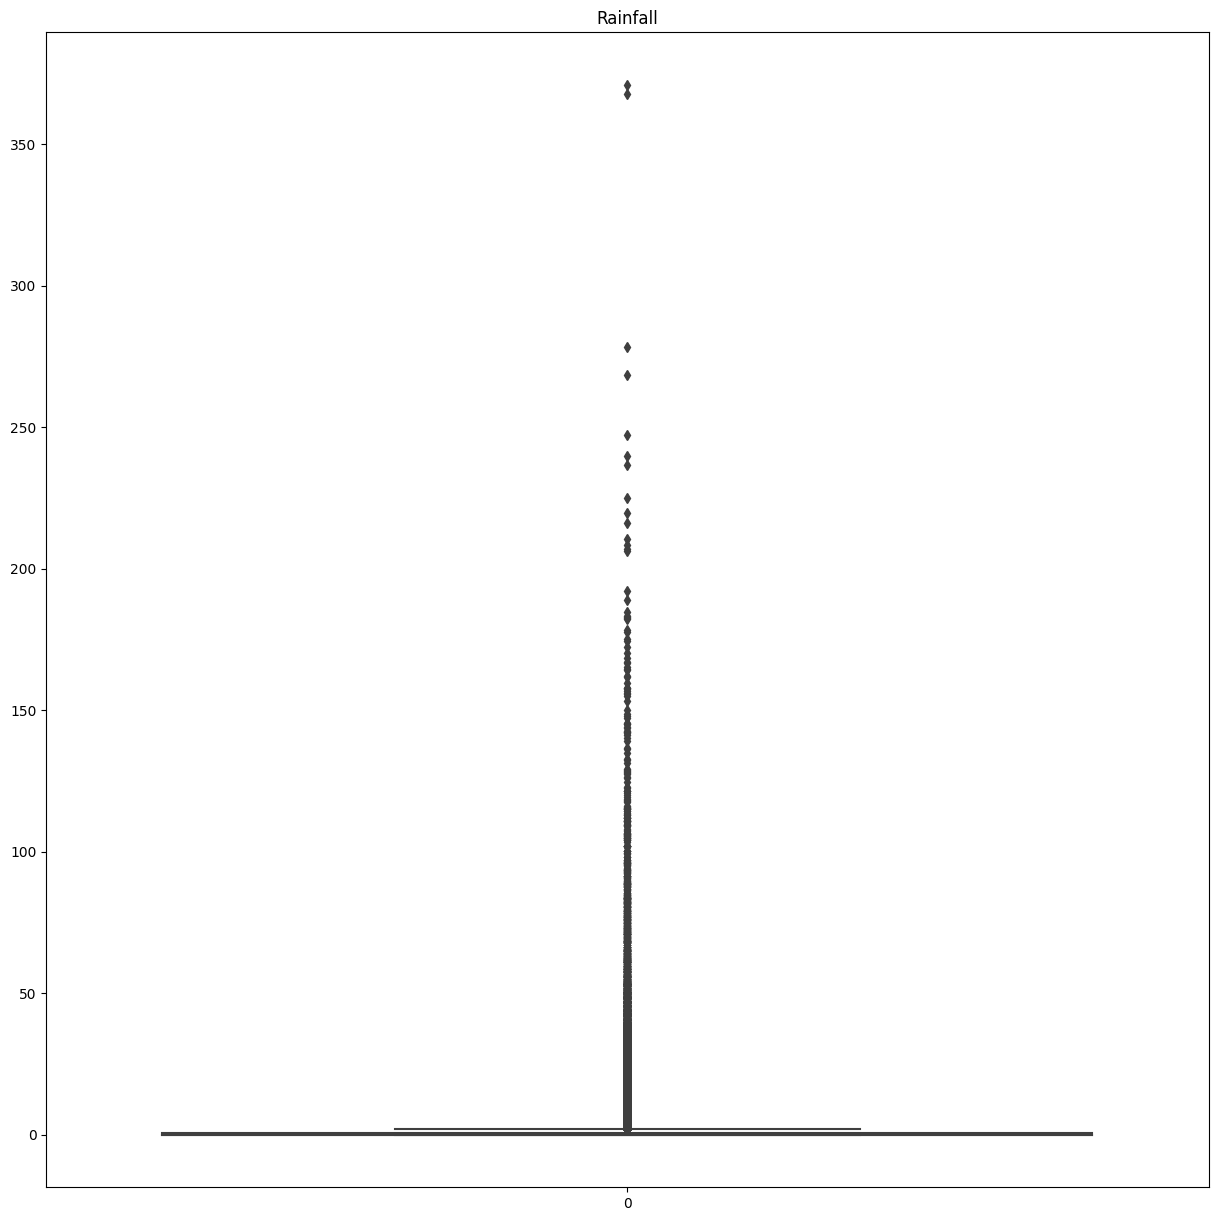

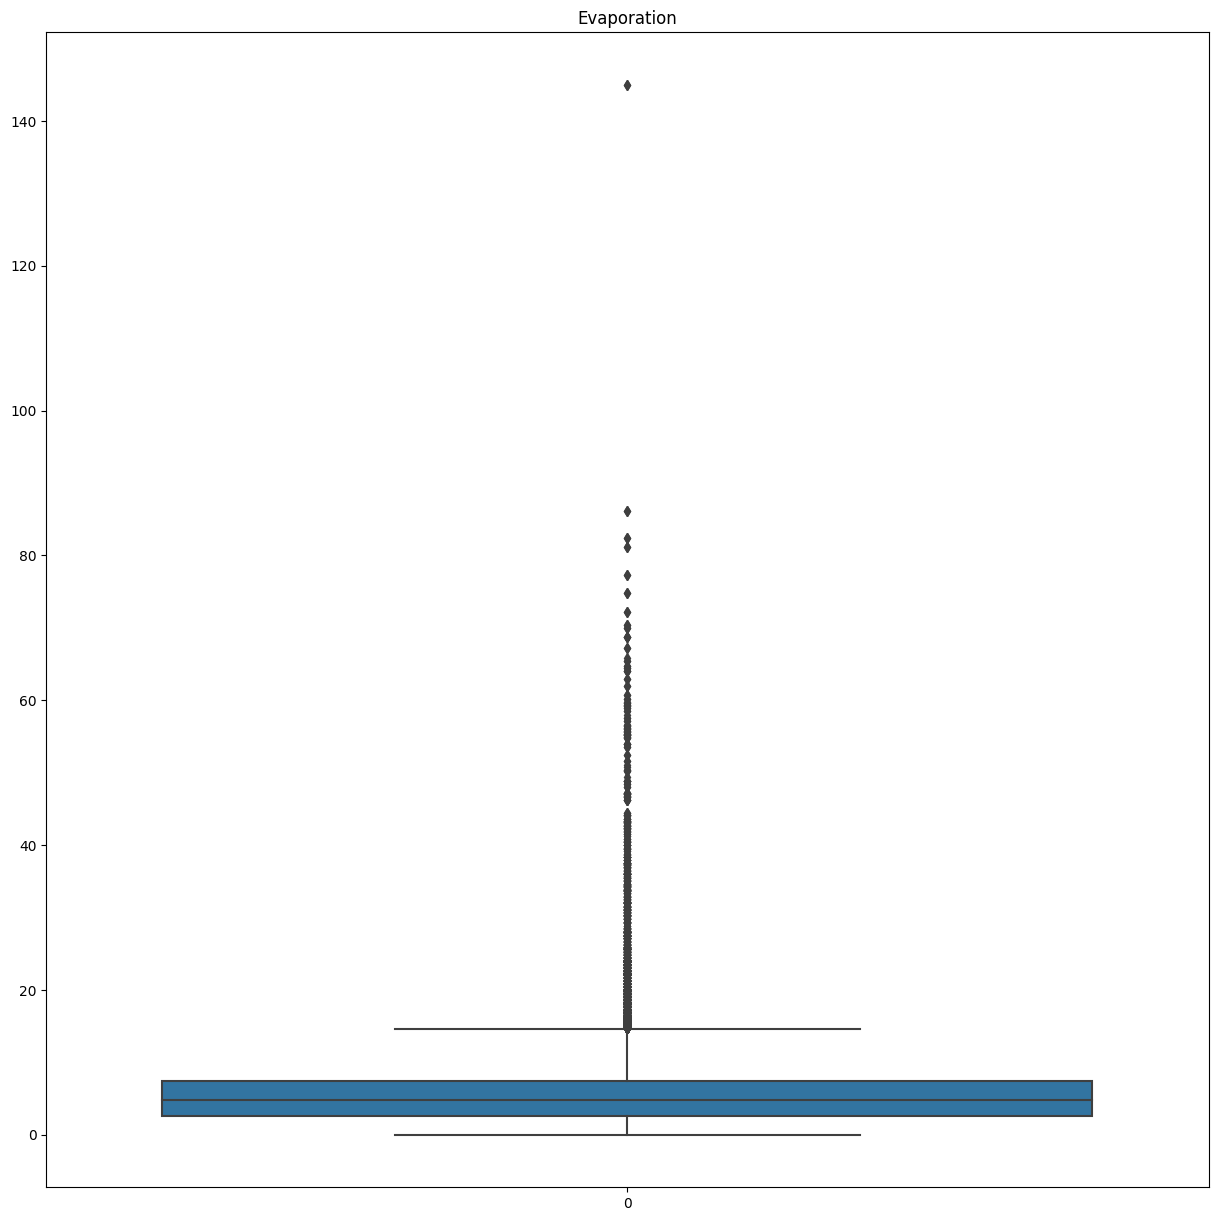

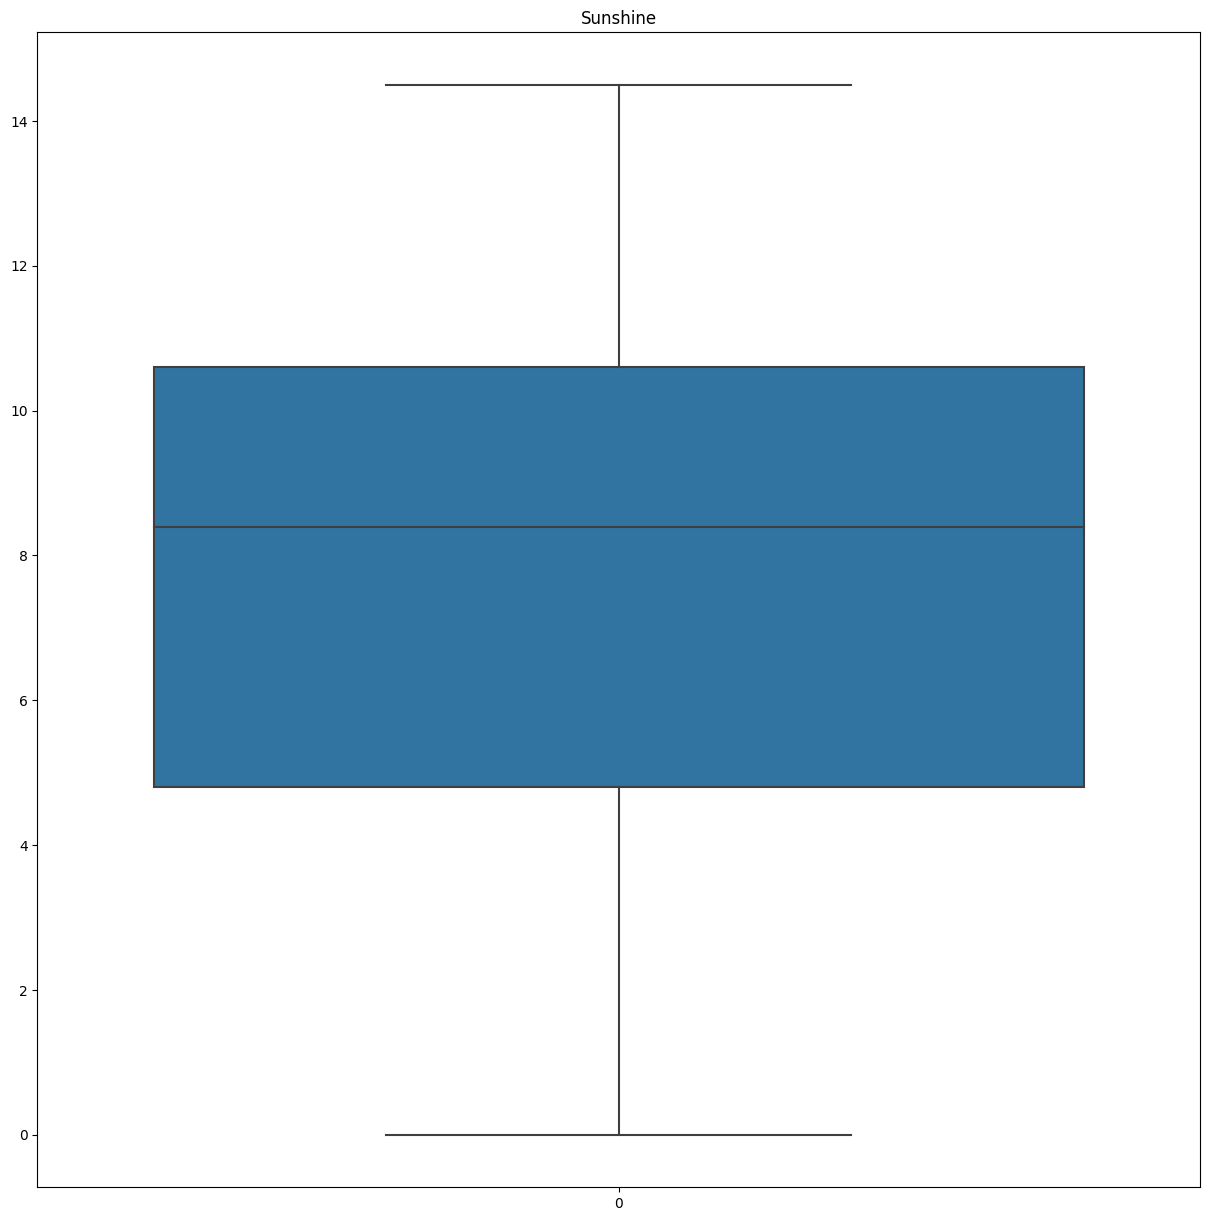

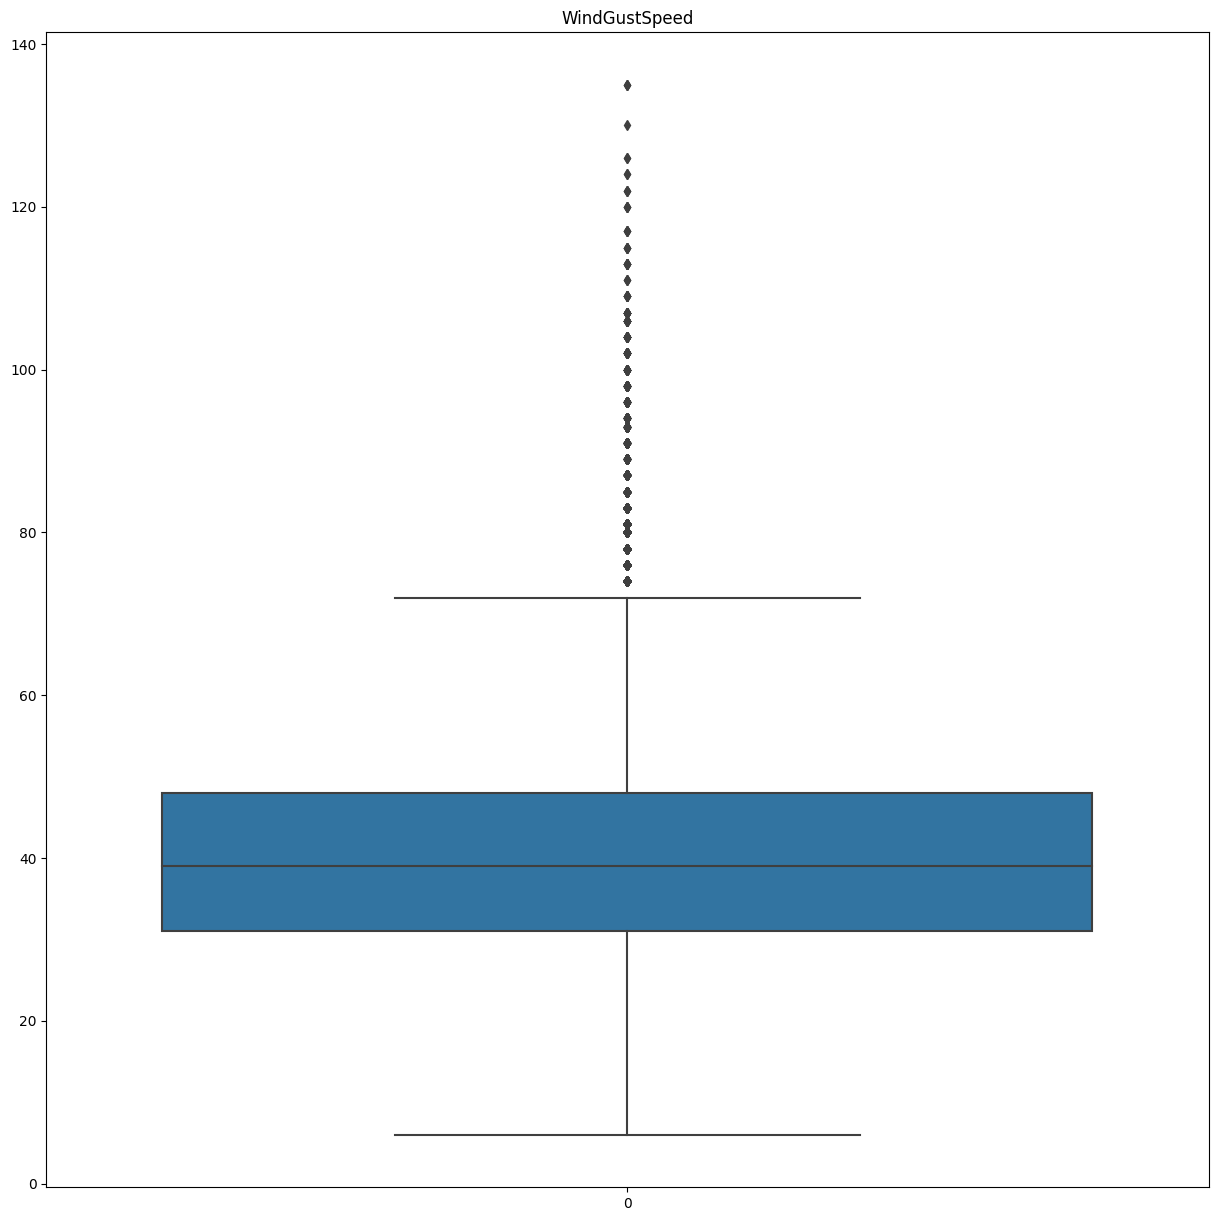

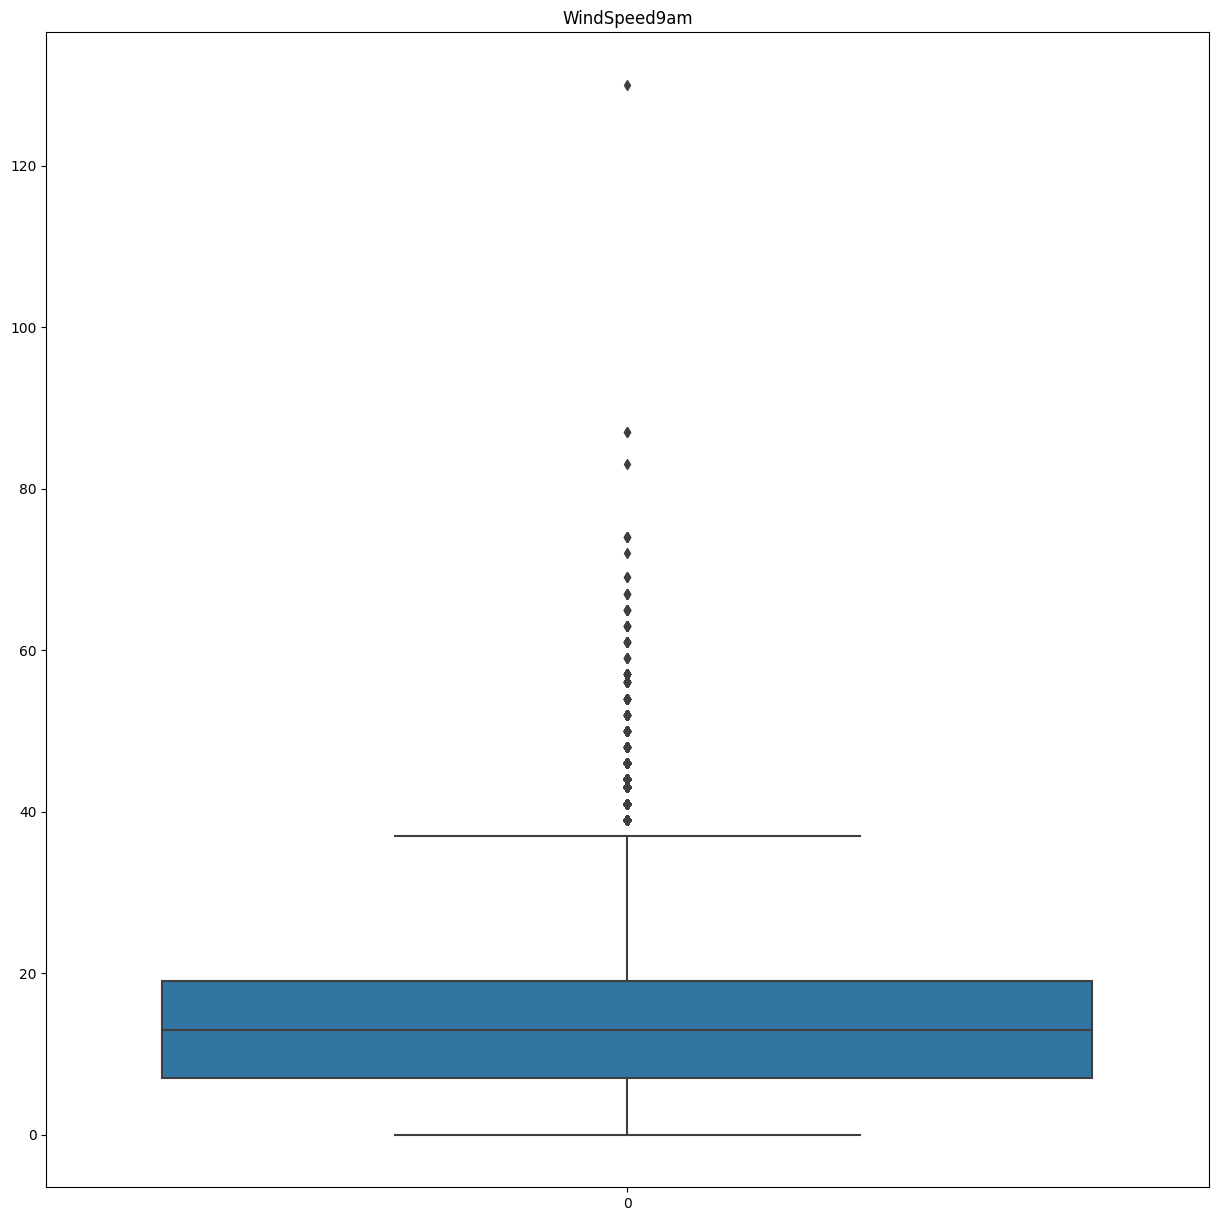

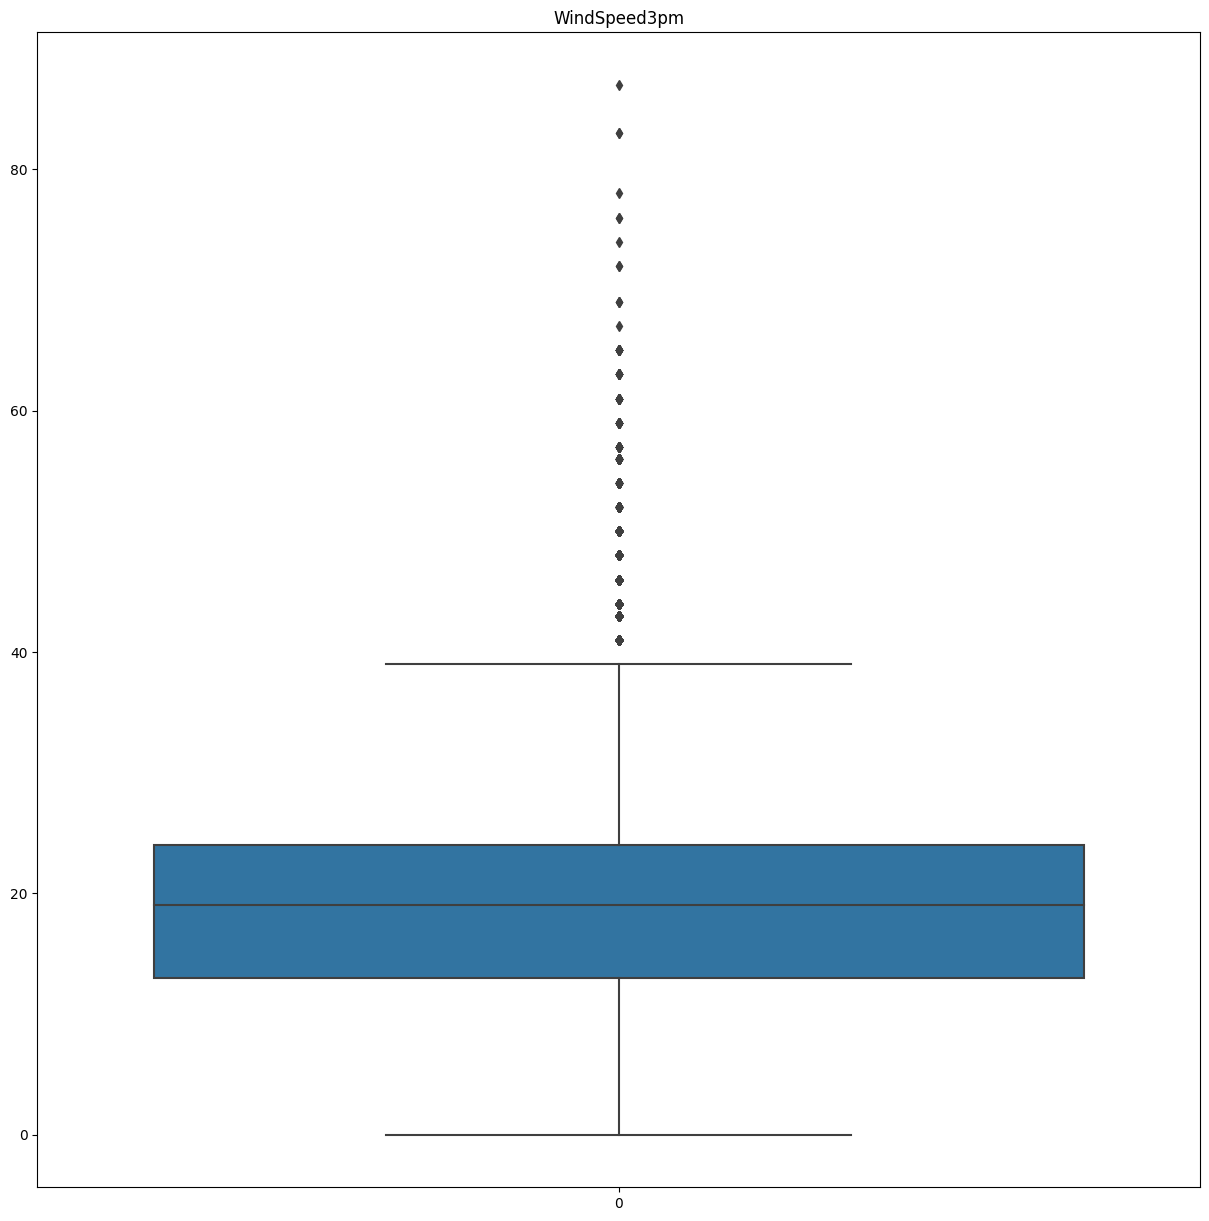

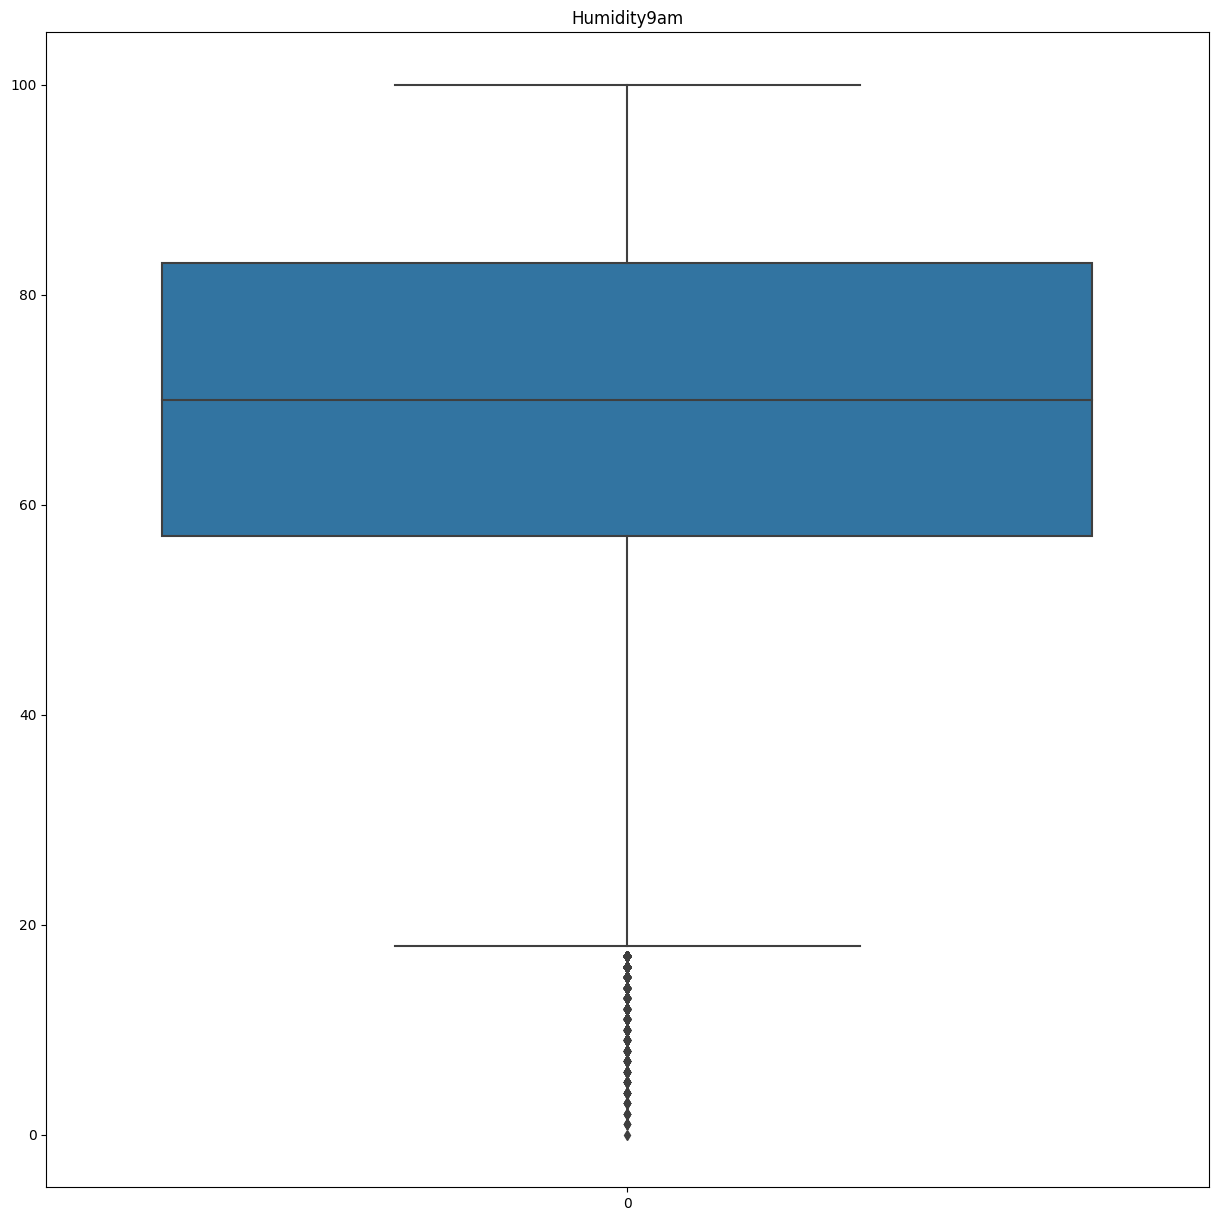

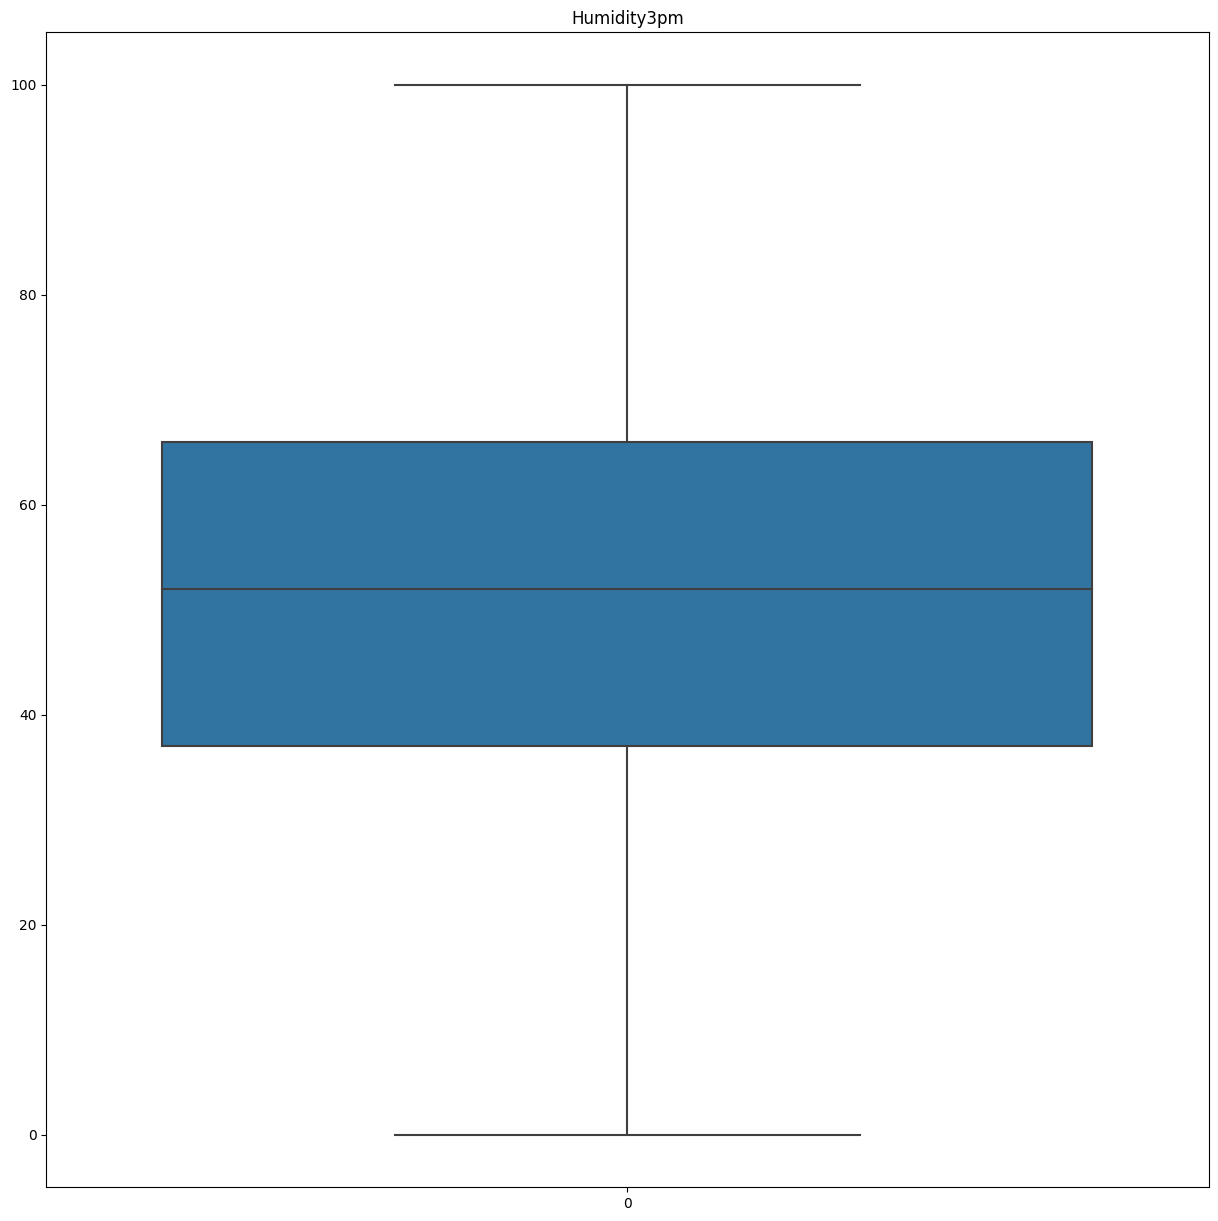

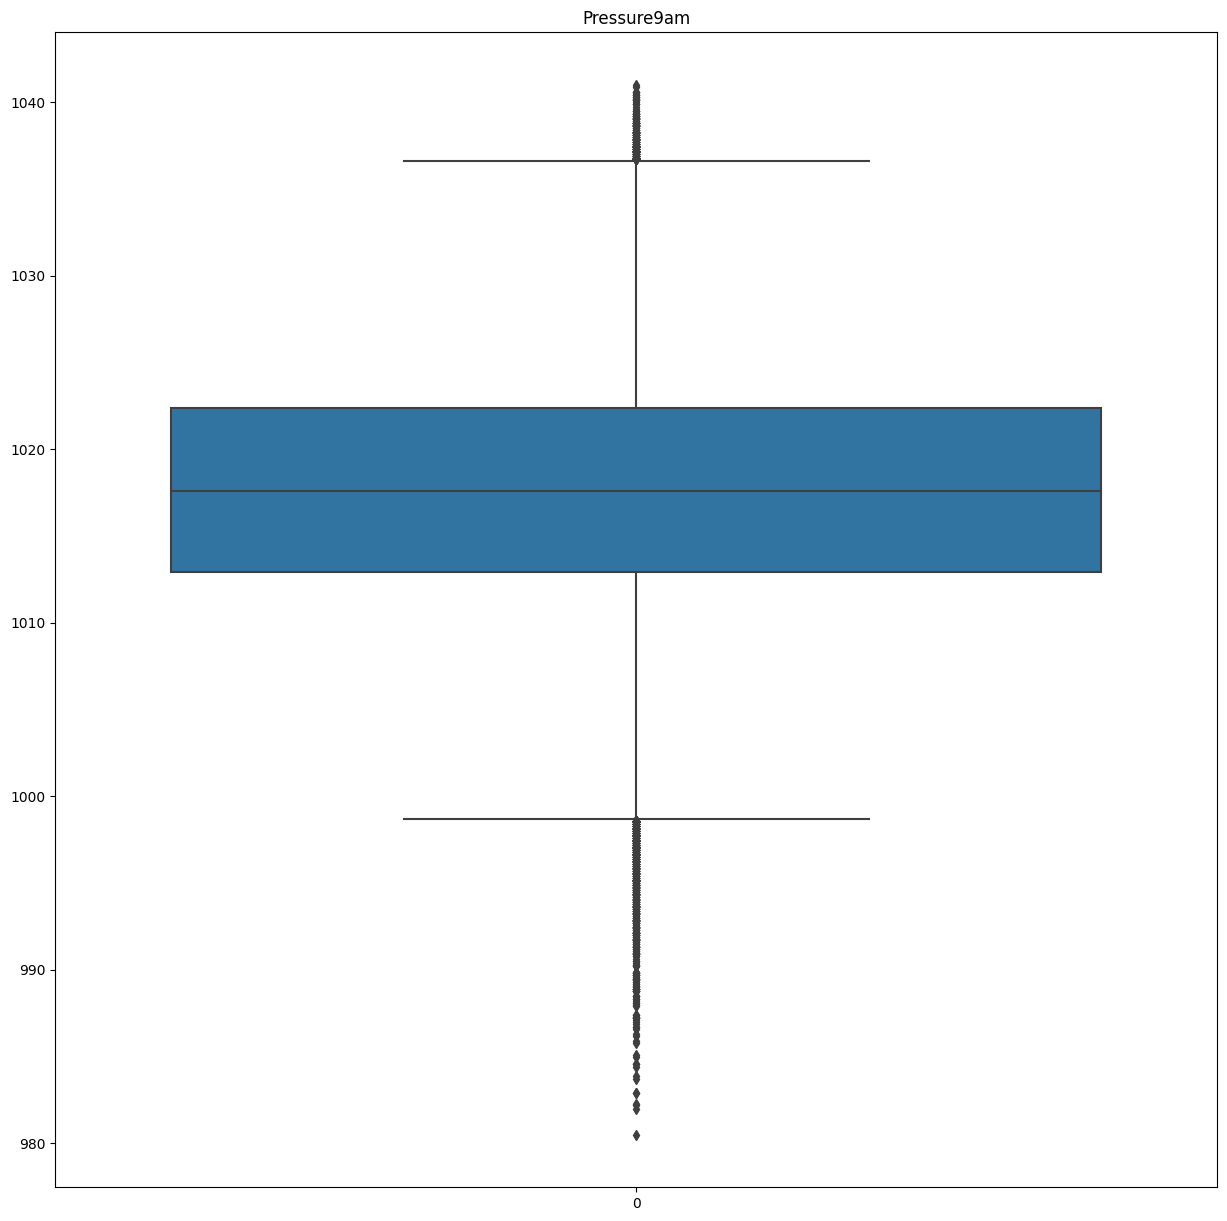

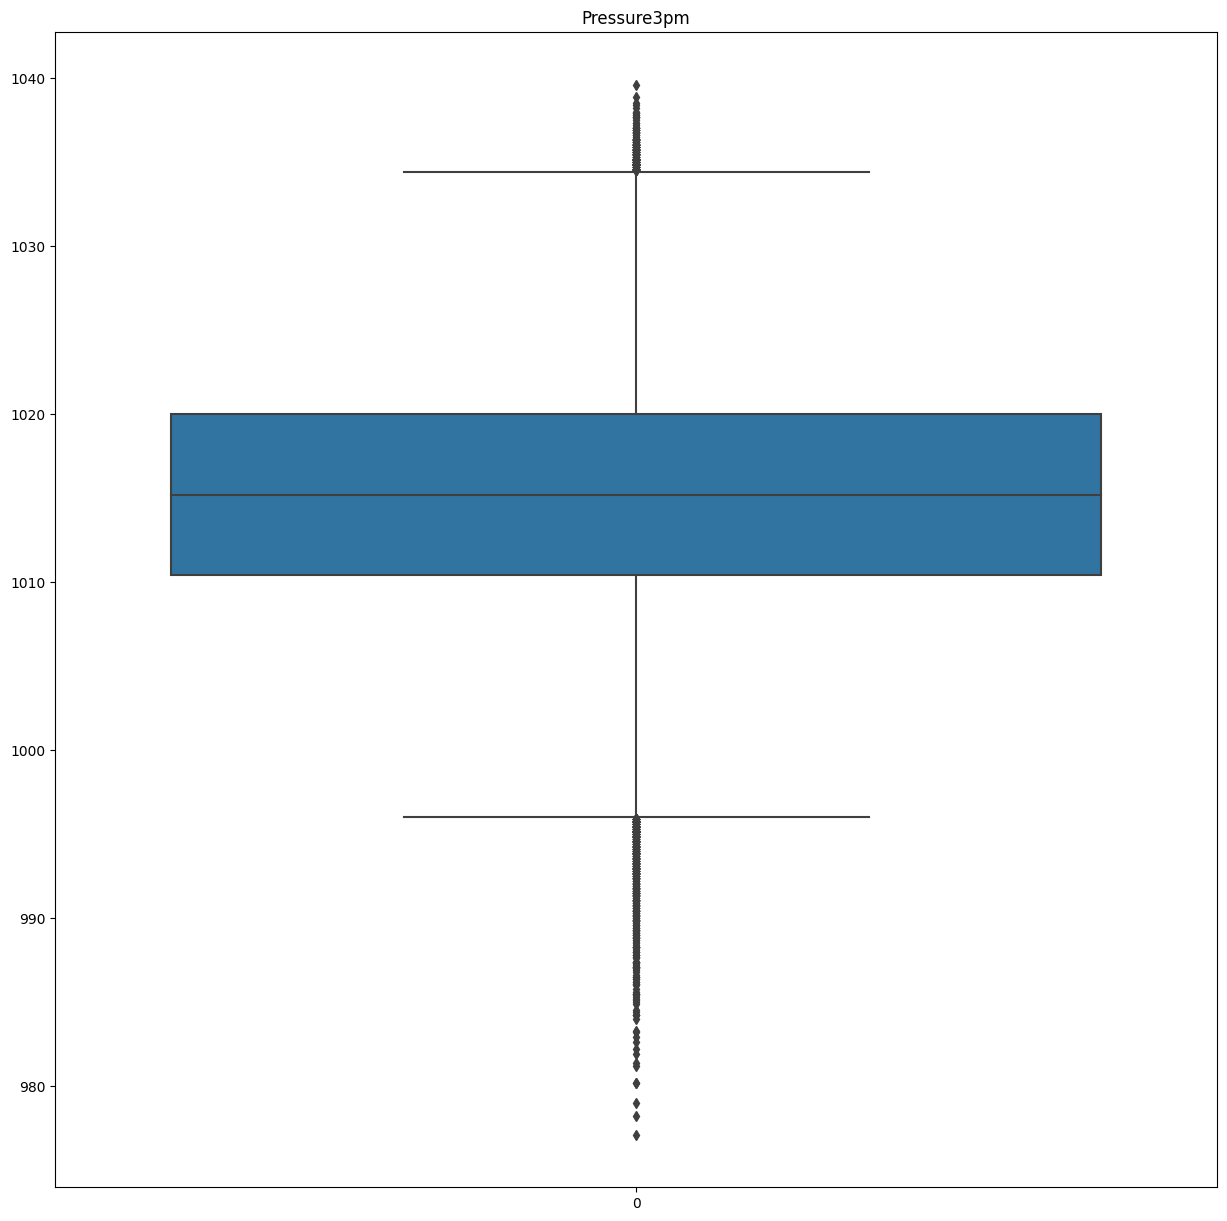

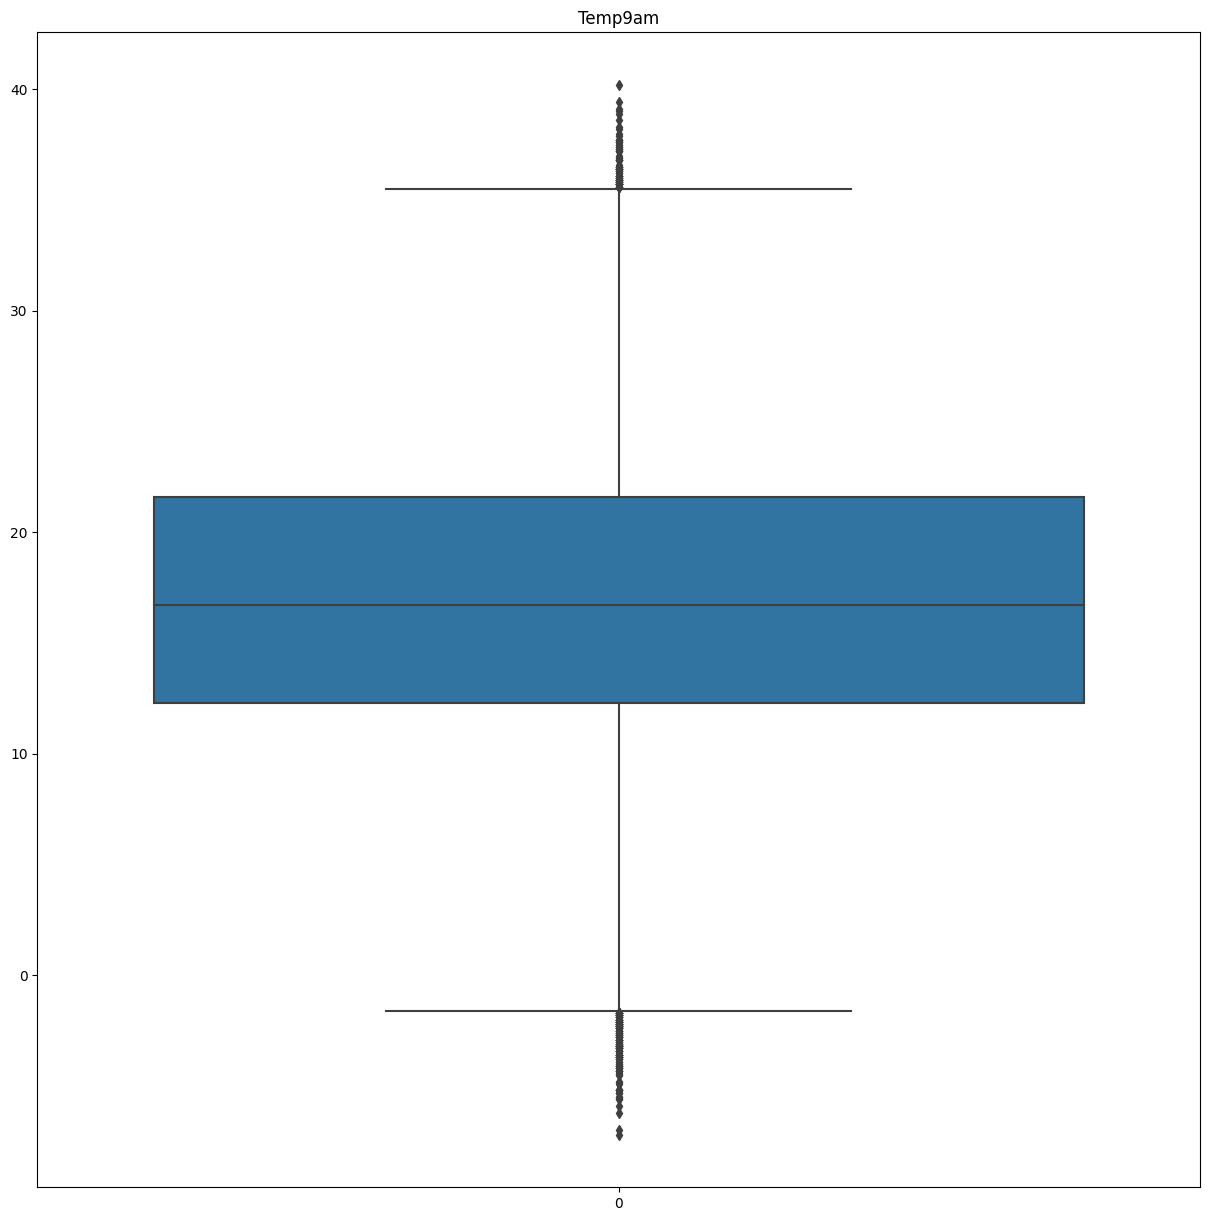

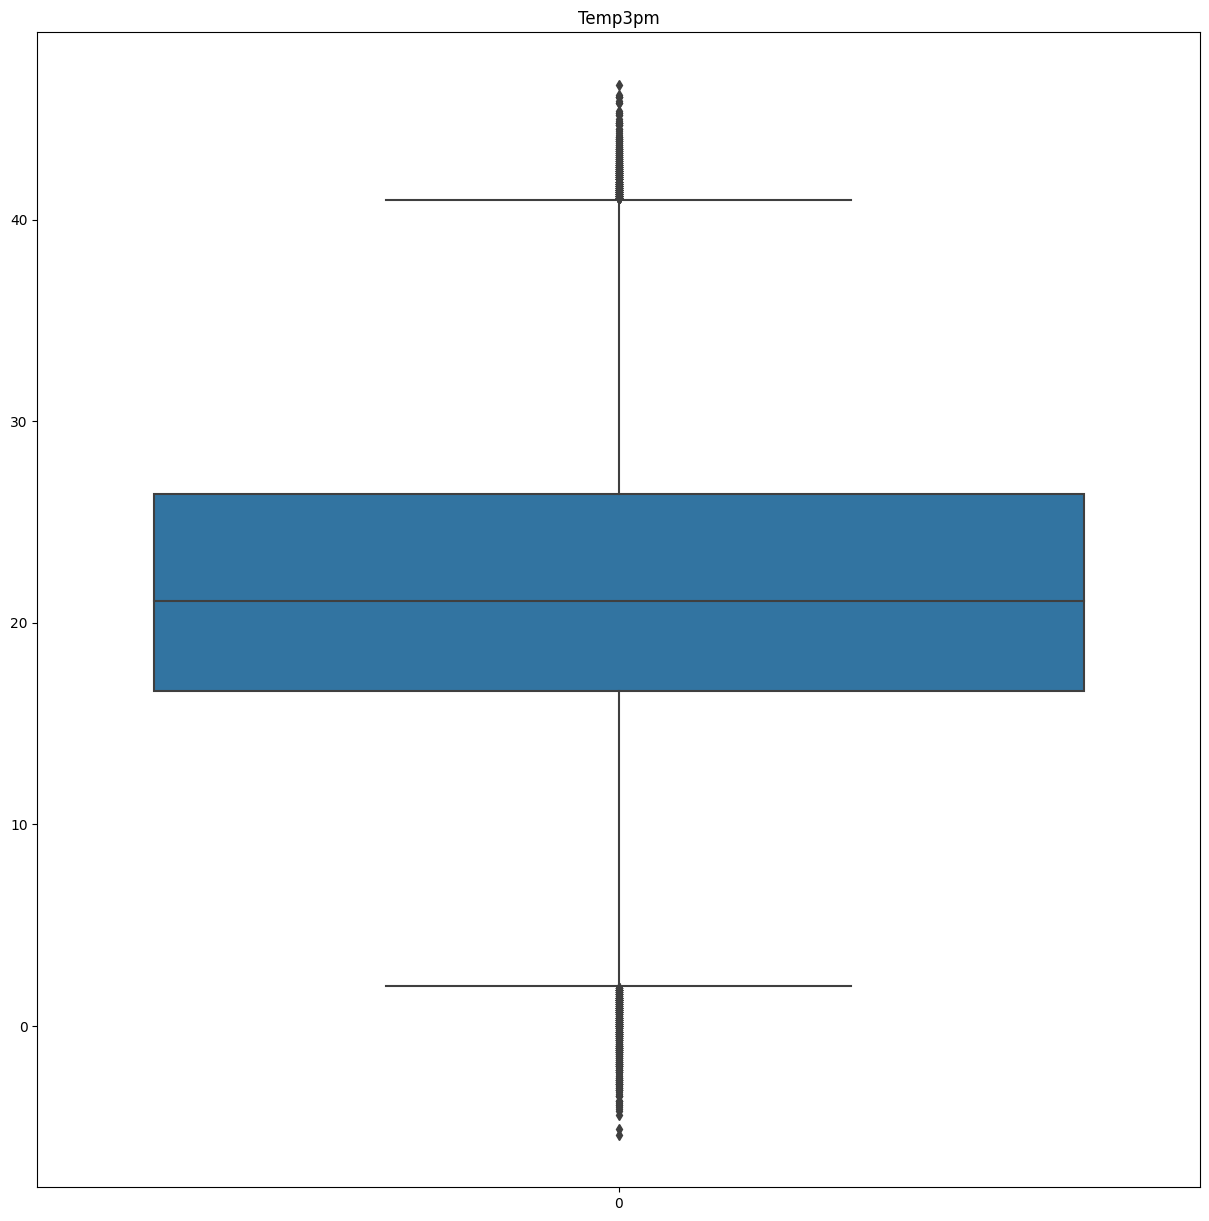

<Figure size 1500x1500 with 0 Axes>

In [11]:
#A for loop is used to plot a boxplot for all the continuous features to see the outliers
for feature in continuous_feature:
    data=df.copy()
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.figure(figsize=(15,15))

In [12]:
for feature in continuous_feature:
    if(df[feature].isnull().sum()*100/len(df))>0:
        df[feature] = df[feature].fillna(df[feature].median())

In [13]:
df.isnull().sum()*100/len(df)

Date                  0.000000
Location              0.000000
MinTemp               0.000000
MaxTemp               0.000000
Rainfall              0.000000
Evaporation           0.000000
Sunshine              0.000000
WindGustDir           7.098859
WindGustSpeed         0.000000
WindDir9am            7.263853
WindDir3pm            2.906641
WindSpeed9am          0.000000
WindSpeed3pm          0.000000
Humidity9am           0.000000
Humidity3pm           0.000000
Pressure9am           0.000000
Pressure3pm           0.000000
Cloud9am              0.000000
Cloud3pm              0.000000
Temp9am               0.000000
Temp3pm               0.000000
CloudBurst Today      2.241853
CloudBurstTomorrow    2.245978
dtype: float64

In [14]:
discrete_feature

['Cloud9am', 'Cloud3pm']

In [15]:
def mode_nan(df,variable):
    mode=df[variable].value_counts().index[0]
    df[variable].fillna(mode,inplace=True)
mode_nan(df,"Cloud9am")
mode_nan(df,"Cloud3pm")

In [16]:
df["CloudBurst Today"] = pd.get_dummies(df["CloudBurst Today"], drop_first = True)
df["CloudBurstTomorrow"] = pd.get_dummies(df["CloudBurstTomorrow"], drop_first = True)
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,CloudBurst Today,CloudBurstTomorrow
0,01-12-2008,Albury,13.4,22.9,0.6,2.4,8.3,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,0,0
1,02-12-2008,Albury,7.4,25.1,0.0,3.6,10.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,1.0,17.2,24.3,0,0
2,03-12-2008,Albury,12.9,25.7,0.0,2.6,4.4,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,0,0
3,04-12-2008,Albury,9.2,28.0,0.0,18.4,8.9,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,0.0,5.0,18.1,26.5,0,0
4,05-12-2008,Albury,17.5,32.3,1.0,5.4,3.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,21-06-2017,Uluru,2.8,23.4,0.0,1.4,7.8,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,1.0,1.0,10.1,22.4,0,0
145456,22-06-2017,Uluru,3.6,25.3,0.0,7.6,13.5,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,8.0,5.0,10.9,24.5,0,0
145457,23-06-2017,Uluru,5.4,26.9,0.0,6.8,11.0,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,8.0,1.0,12.5,26.1,0,0
145458,24-06-2017,Uluru,7.8,27.0,0.0,2.6,13.2,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,0,0


In [17]:
for feature in categorical_feature:
    print(feature, (df.groupby([feature])["CloudBurstTomorrow"].mean().sort_values(ascending = False)).index)

Date Index(['19-12-2007', '30-01-2008', '24-12-2007', '13-04-2008', '19-06-2008',
       '02-11-2007', '03-11-2007', '20-12-2007', '03-12-2007', '21-12-2007',
       ...
       '29-04-2008', '25-04-2008', '14-01-2008', '14-02-2008', '19-08-2008',
       '29-03-2008', '29-02-2008', '08-03-2008', '19-07-2008', '01-01-2008'],
      dtype='object', name='Date', length=3436)
Location Index(['Portland', 'Walpole', 'Cairns', 'Dartmoor', 'NorfolkIsland',
       'MountGambier', 'Albany', 'Witchcliffe', 'CoffsHarbour', 'MountGinini',
       'NorahHead', 'Darwin', 'Sydney', 'SydneyAirport', 'Ballarat',
       'GoldCoast', 'Watsonia', 'Newcastle', 'Hobart', 'Wollongong',
       'Williamtown', 'Launceston', 'Brisbane', 'MelbourneAirport', 'Adelaide',
       'Sale', 'Albury', 'Perth', 'Melbourne', 'Nuriootpa', 'Penrith',
       'BadgerysCreek', 'PerthAirport', 'Tuggeranong', 'Richmond', 'Bendigo',
       'Canberra', 'WaggaWagga', 'Townsville', 'Katherine', 'PearceRAAF',
       'SalmonGums', 'Nhil', 

In [18]:
windgustdir = {'NNW':0, 'NW':1, 'WNW':2, 'N':3, 'W':4, 'WSW':5, 'NNE':6, 'S':7, 'SSW':8, 'SW':9, 'SSE':10,
       'NE':11, 'SE':12, 'ESE':13, 'ENE':14, 'E':15}
winddir9am = {'NNW':0, 'N':1, 'NW':2, 'NNE':3, 'WNW':4, 'W':5, 'WSW':6, 'SW':7, 'SSW':8, 'NE':9, 'S':10,
       'SSE':11, 'ENE':12, 'SE':13, 'ESE':14, 'E':15}
winddir3pm = {'NW':0, 'NNW':1, 'N':2, 'WNW':3, 'W':4, 'NNE':5, 'WSW':6, 'SSW':7, 'S':8, 'SW':9, 'SE':10,
       'NE':11, 'SSE':12, 'ENE':13, 'E':14, 'ESE':15}
df["WindGustDir"] = df["WindGustDir"].map(windgustdir)
df["WindDir9am"] = df["WindDir9am"].map(winddir9am)
df["WindDir3pm"] = df["WindDir3pm"].map(winddir3pm)

In [19]:
df["WindGustDir"] = df["WindGustDir"].fillna(df["WindGustDir"].value_counts().index[0])
df["WindDir9am"] = df["WindDir9am"].fillna(df["WindDir9am"].value_counts().index[0])
df["WindDir3pm"] = df["WindDir3pm"].fillna(df["WindDir3pm"].value_counts().index[0])

In [20]:
df.isnull().sum()*100/len(df)

Date                  0.0
Location              0.0
MinTemp               0.0
MaxTemp               0.0
Rainfall              0.0
Evaporation           0.0
Sunshine              0.0
WindGustDir           0.0
WindGustSpeed         0.0
WindDir9am            0.0
WindDir3pm            0.0
WindSpeed9am          0.0
WindSpeed3pm          0.0
Humidity9am           0.0
Humidity3pm           0.0
Pressure9am           0.0
Pressure3pm           0.0
Cloud9am              0.0
Cloud3pm              0.0
Temp9am               0.0
Temp3pm               0.0
CloudBurst Today      0.0
CloudBurstTomorrow    0.0
dtype: float64

In [21]:
df1 = df.groupby(["Location"])["CloudBurstTomorrow"].value_counts().sort_values().unstack()

In [22]:
df1

CloudBurstTomorrow,0,1
Location,,
Adelaide,2505,688
Albany,2138,902
Albury,2422,618
AliceSprings,2796,244
BadgerysCreek,2426,583
Ballarat,2259,781
Bendigo,2478,562
Brisbane,2484,709
Cairns,2090,950


In [23]:
df1[1].sort_values(ascending = False)

Location
Portland            1095
Cairns               950
Walpole              949
Dartmoor             922
MountGambier         920
NorfolkIsland        919
Albany               902
Witchcliffe          879
CoffsHarbour         869
Sydney               865
Darwin               852
MountGinini          819
NorahHead            808
Ballarat             781
GoldCoast            775
SydneyAirport        774
Hobart               761
Watsonia             738
Newcastle            731
Wollongong           713
Brisbane             709
Williamtown          700
Launceston           699
Adelaide             688
MelbourneAirport     653
Perth                645
Sale                 643
Melbourne            636
Canberra             629
Albury               618
Penrith              595
Nuriootpa            592
BadgerysCreek        583
Tuggeranong          568
PerthAirport         567
Bendigo              562
Richmond             560
WaggaWagga           536
Townsville           519
PearceRAAF      

In [24]:
df1[1].sort_values(ascending = False).index

Index(['Portland', 'Cairns', 'Walpole', 'Dartmoor', 'MountGambier',
       'NorfolkIsland', 'Albany', 'Witchcliffe', 'CoffsHarbour', 'Sydney',
       'Darwin', 'MountGinini', 'NorahHead', 'Ballarat', 'GoldCoast',
       'SydneyAirport', 'Hobart', 'Watsonia', 'Newcastle', 'Wollongong',
       'Brisbane', 'Williamtown', 'Launceston', 'Adelaide', 'MelbourneAirport',
       'Perth', 'Sale', 'Melbourne', 'Canberra', 'Albury', 'Penrith',
       'Nuriootpa', 'BadgerysCreek', 'Tuggeranong', 'PerthAirport', 'Bendigo',
       'Richmond', 'WaggaWagga', 'Townsville', 'PearceRAAF', 'SalmonGums',
       'Moree', 'Cobar', 'Mildura', 'Katherine', 'AliceSprings', 'Nhil',
       'Woomera', 'Uluru'],
      dtype='object', name='Location')

In [25]:
len(df1[1].sort_values(ascending = False).index)

49

In [26]:
location = {'Portland':1, 'Cairns':2, 'Walpole':3, 'Dartmoor':4, 'MountGambier':5,
       'NorfolkIsland':6, 'Albany':7, 'Witchcliffe':8, 'CoffsHarbour':9, 'Sydney':10,
       'Darwin':11, 'MountGinini':12, 'NorahHead':13, 'Ballarat':14, 'GoldCoast':15,
       'SydneyAirport':16, 'Hobart':17, 'Watsonia':18, 'Newcastle':19, 'Wollongong':20,
       'Brisbane':21, 'Williamtown':22, 'Launceston':23, 'Adelaide':24, 'MelbourneAirport':25,
       'Perth':26, 'Sale':27, 'Melbourne':28, 'Canberra':29, 'Albury':30, 'Penrith':31,
       'Nuriootpa':32, 'BadgerysCreek':33, 'Tuggeranong':34, 'PerthAirport':35, 'Bendigo':36,
       'Richmond':37, 'WaggaWagga':38, 'Townsville':39, 'PearceRAAF':40, 'SalmonGums':41,
       'Moree':42, 'Cobar':43, 'Mildura':44, 'Katherine':45, 'AliceSprings':46, 'Nhil':47,
       'Woomera':48, 'Uluru':49}
df["Location"] = df["Location"].map(location)

In [27]:
df["Date"] = pd.to_datetime(df["Date"], format = "%Y-%m-%dT", errors = "coerce")

In [28]:
df["Date_month"] = df["Date"].dt.month
df["Date_day"] = df["Date"].dt.day

In [29]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,CloudBurst Today,CloudBurstTomorrow,Date_month,Date_day
0,NaT,30,13.4,22.9,0.6,2.4,8.3,4.0,44.0,5.0,3.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,0,0,NaN,NaN
1,NaT,30,7.4,25.1,0.0,3.6,10.0,2.0,44.0,0.0,6.0,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,1.0,17.2,24.3,0,0,NaN,NaN
2,NaT,30,12.9,25.7,0.0,2.6,4.4,5.0,46.0,5.0,6.0,19.0,26.0,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,0,0,NaN,NaN
3,NaT,30,9.2,28.0,0.0,18.4,8.9,11.0,24.0,13.0,14.0,11.0,9.0,45.0,16.0,1017.6,1012.8,0.0,5.0,18.1,26.5,0,0,NaN,NaN
4,NaT,30,17.5,32.3,1.0,5.4,3.0,4.0,41.0,12.0,0.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,NaT,49,2.8,23.4,0.0,1.4,7.8,15.0,31.0,13.0,13.0,13.0,11.0,51.0,24.0,1024.6,1020.3,1.0,1.0,10.1,22.4,0,0,NaN,NaN
145456,NaT,49,3.6,25.3,0.0,7.6,13.5,0.0,22.0,13.0,2.0,13.0,9.0,56.0,21.0,1023.5,1019.1,8.0,5.0,10.9,24.5,0,0,NaN,NaN
145457,NaT,49,5.4,26.9,0.0,6.8,11.0,3.0,37.0,13.0,3.0,9.0,9.0,53.0,24.0,1021.0,1016.8,8.0,1.0,12.5,26.1,0,0,NaN,NaN
145458,NaT,49,7.8,27.0,0.0,2.6,13.2,12.0,28.0,11.0,2.0,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,0,0,NaN,NaN


C:\Users\gubil\AppData\Local\Temp\ipykernel_9872\3423568062.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = df.corr()


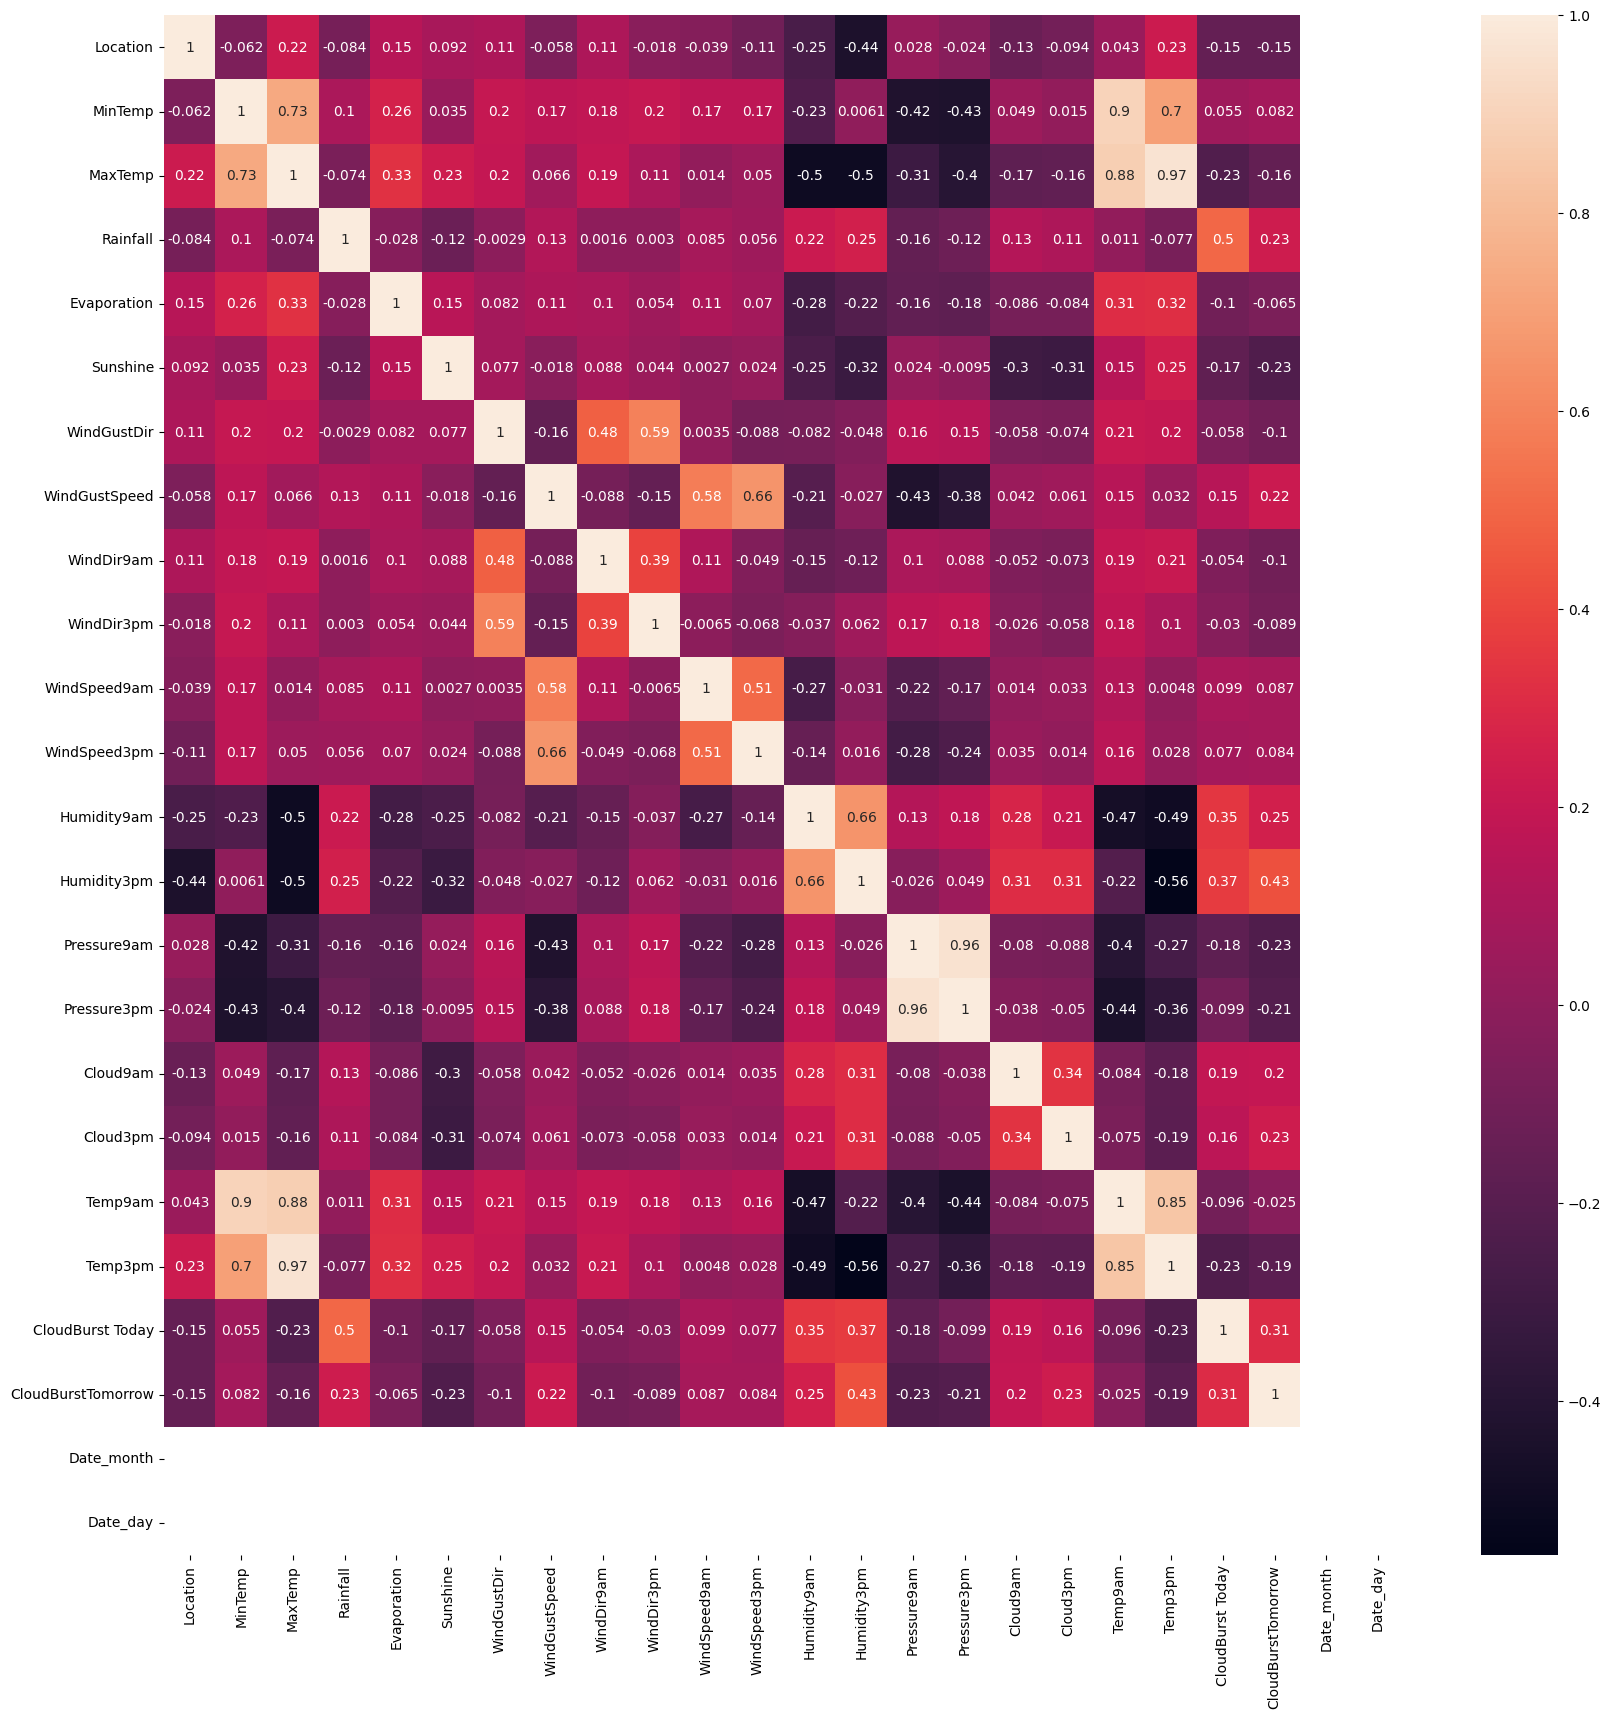

In [30]:
corrmat = df.corr()
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(corrmat,annot=True)

<Axes: ylabel='count'>

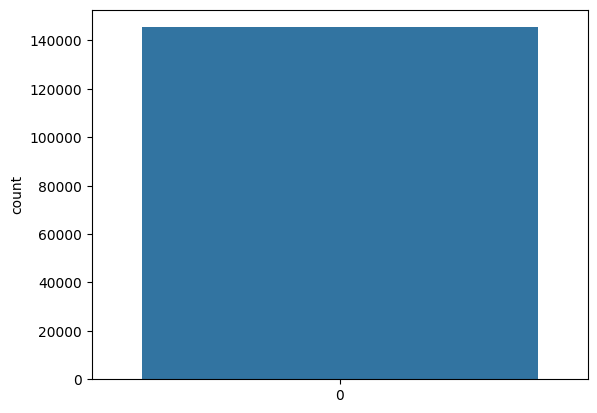

In [31]:
sns.countplot(df["CloudBurstTomorrow"])

In [32]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,CloudBurst Today,CloudBurstTomorrow,Date_month,Date_day
0,NaT,30,13.4,22.9,0.6,2.4,8.3,4.0,44.0,5.0,3.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,0,0,NaN,NaN
1,NaT,30,7.4,25.1,0.0,3.6,10.0,2.0,44.0,0.0,6.0,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,1.0,17.2,24.3,0,0,NaN,NaN
2,NaT,30,12.9,25.7,0.0,2.6,4.4,5.0,46.0,5.0,6.0,19.0,26.0,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,0,0,NaN,NaN
3,NaT,30,9.2,28.0,0.0,18.4,8.9,11.0,24.0,13.0,14.0,11.0,9.0,45.0,16.0,1017.6,1012.8,0.0,5.0,18.1,26.5,0,0,NaN,NaN
4,NaT,30,17.5,32.3,1.0,5.4,3.0,4.0,41.0,12.0,0.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,NaT,49,2.8,23.4,0.0,1.4,7.8,15.0,31.0,13.0,13.0,13.0,11.0,51.0,24.0,1024.6,1020.3,1.0,1.0,10.1,22.4,0,0,NaN,NaN
145456,NaT,49,3.6,25.3,0.0,7.6,13.5,0.0,22.0,13.0,2.0,13.0,9.0,56.0,21.0,1023.5,1019.1,8.0,5.0,10.9,24.5,0,0,NaN,NaN
145457,NaT,49,5.4,26.9,0.0,6.8,11.0,3.0,37.0,13.0,3.0,9.0,9.0,53.0,24.0,1021.0,1016.8,8.0,1.0,12.5,26.1,0,0,NaN,NaN
145458,NaT,49,7.8,27.0,0.0,2.6,13.2,12.0,28.0,11.0,2.0,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,0,0,NaN,NaN


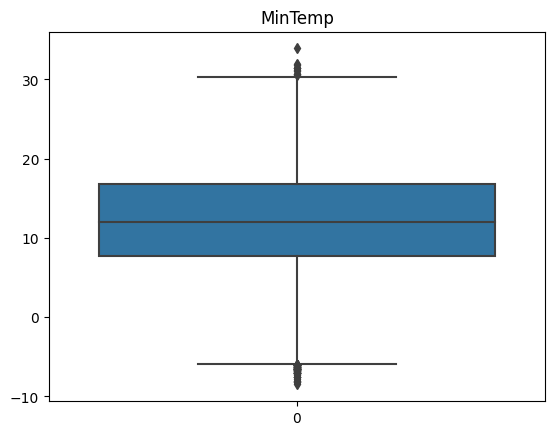

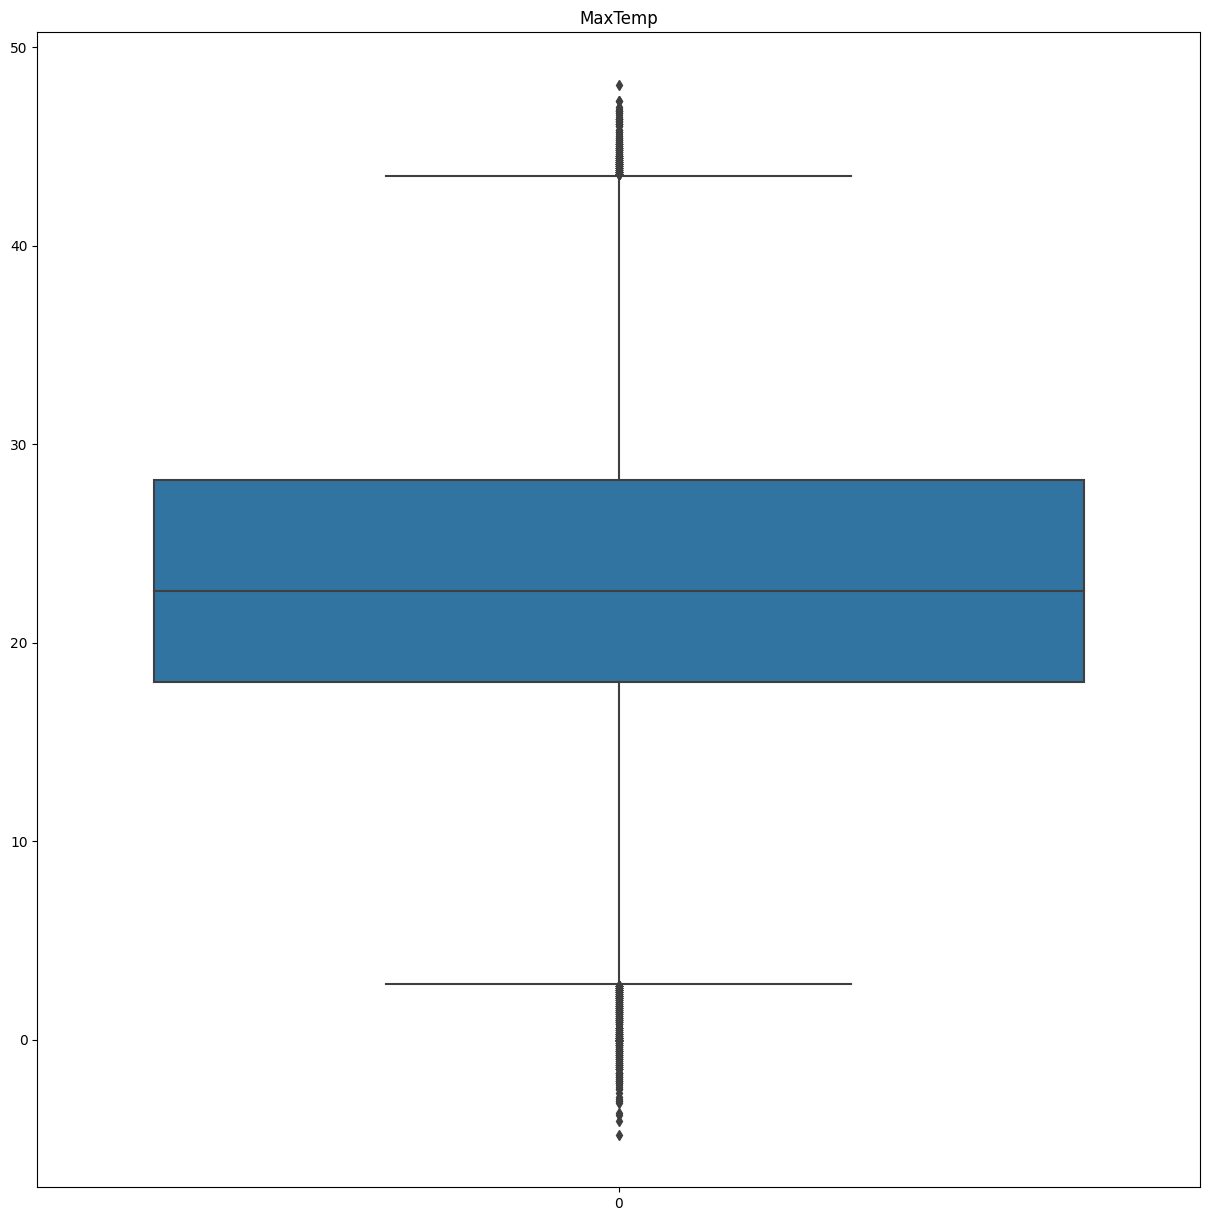

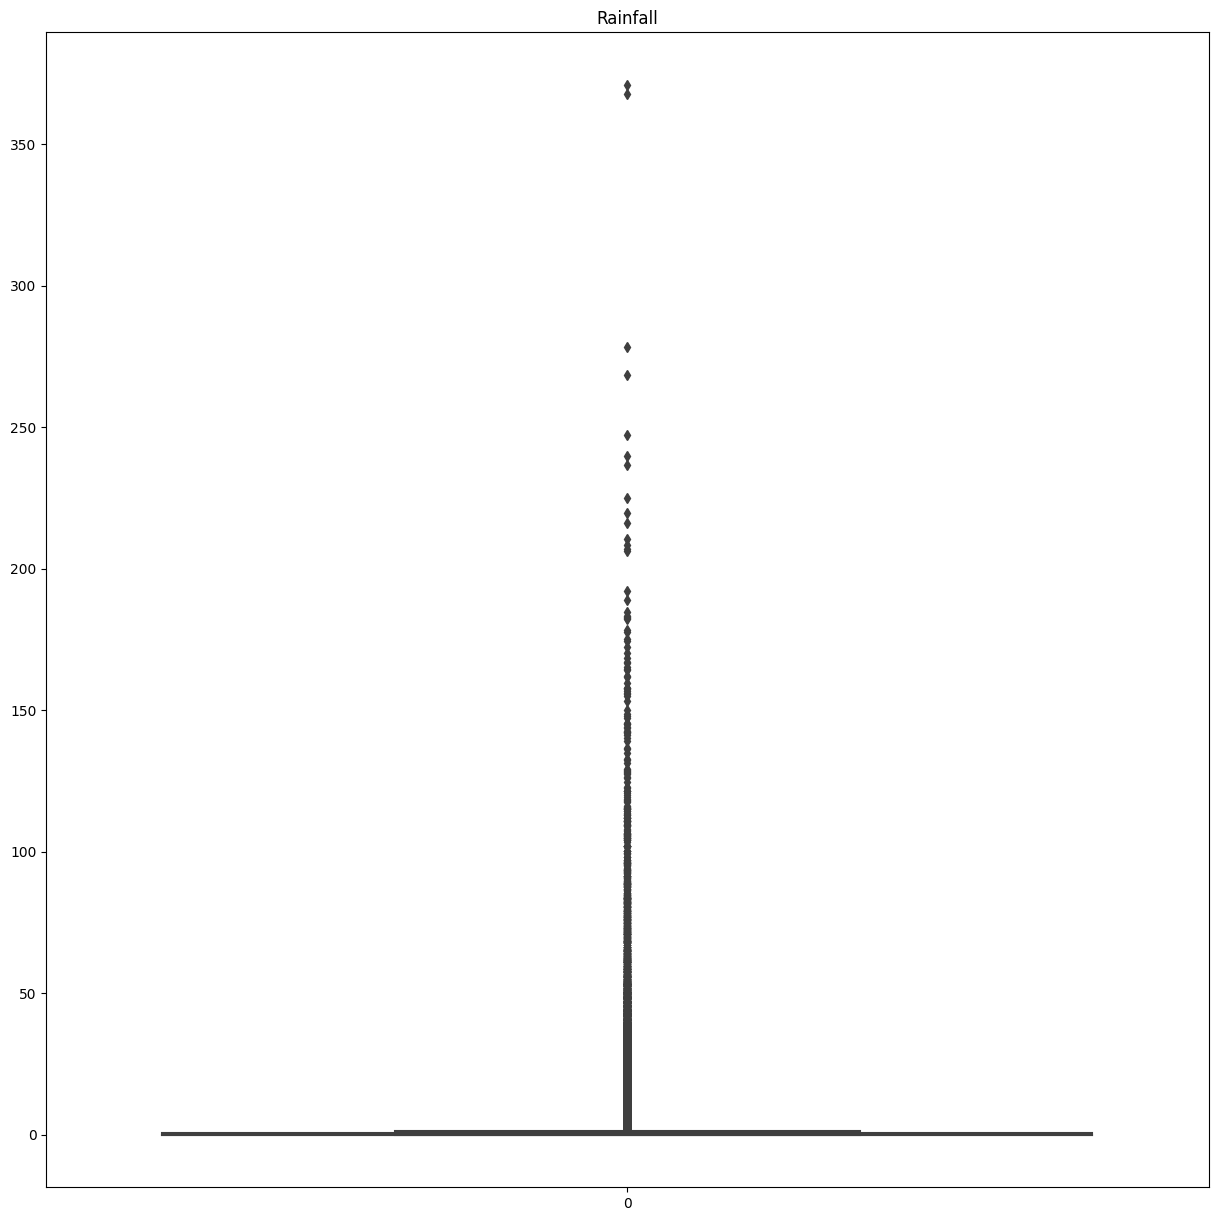

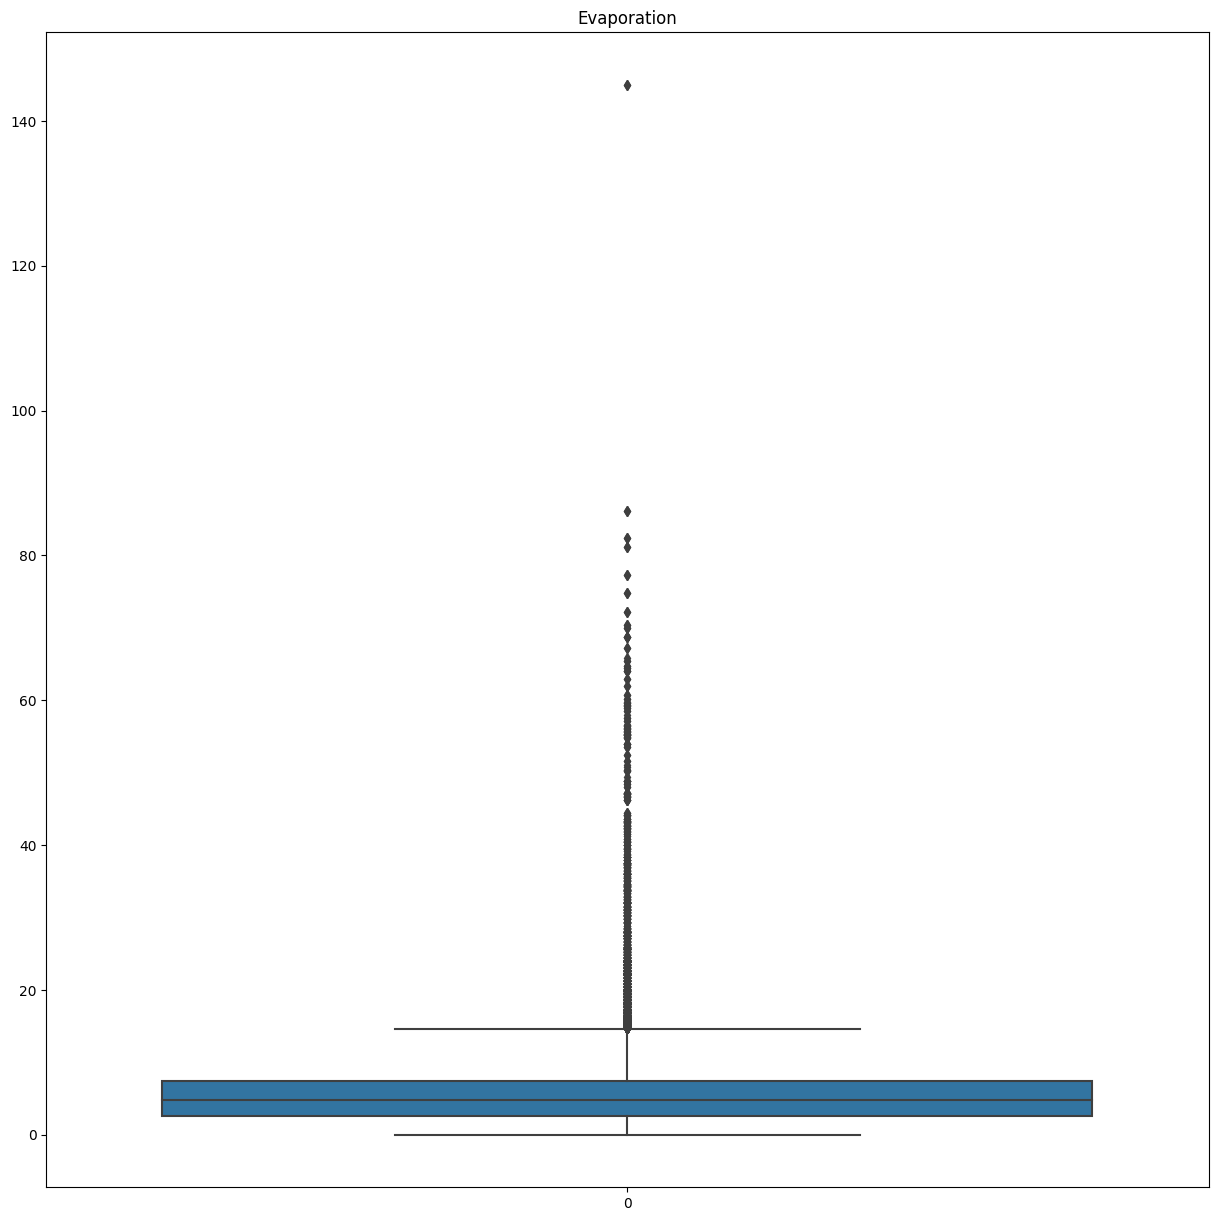

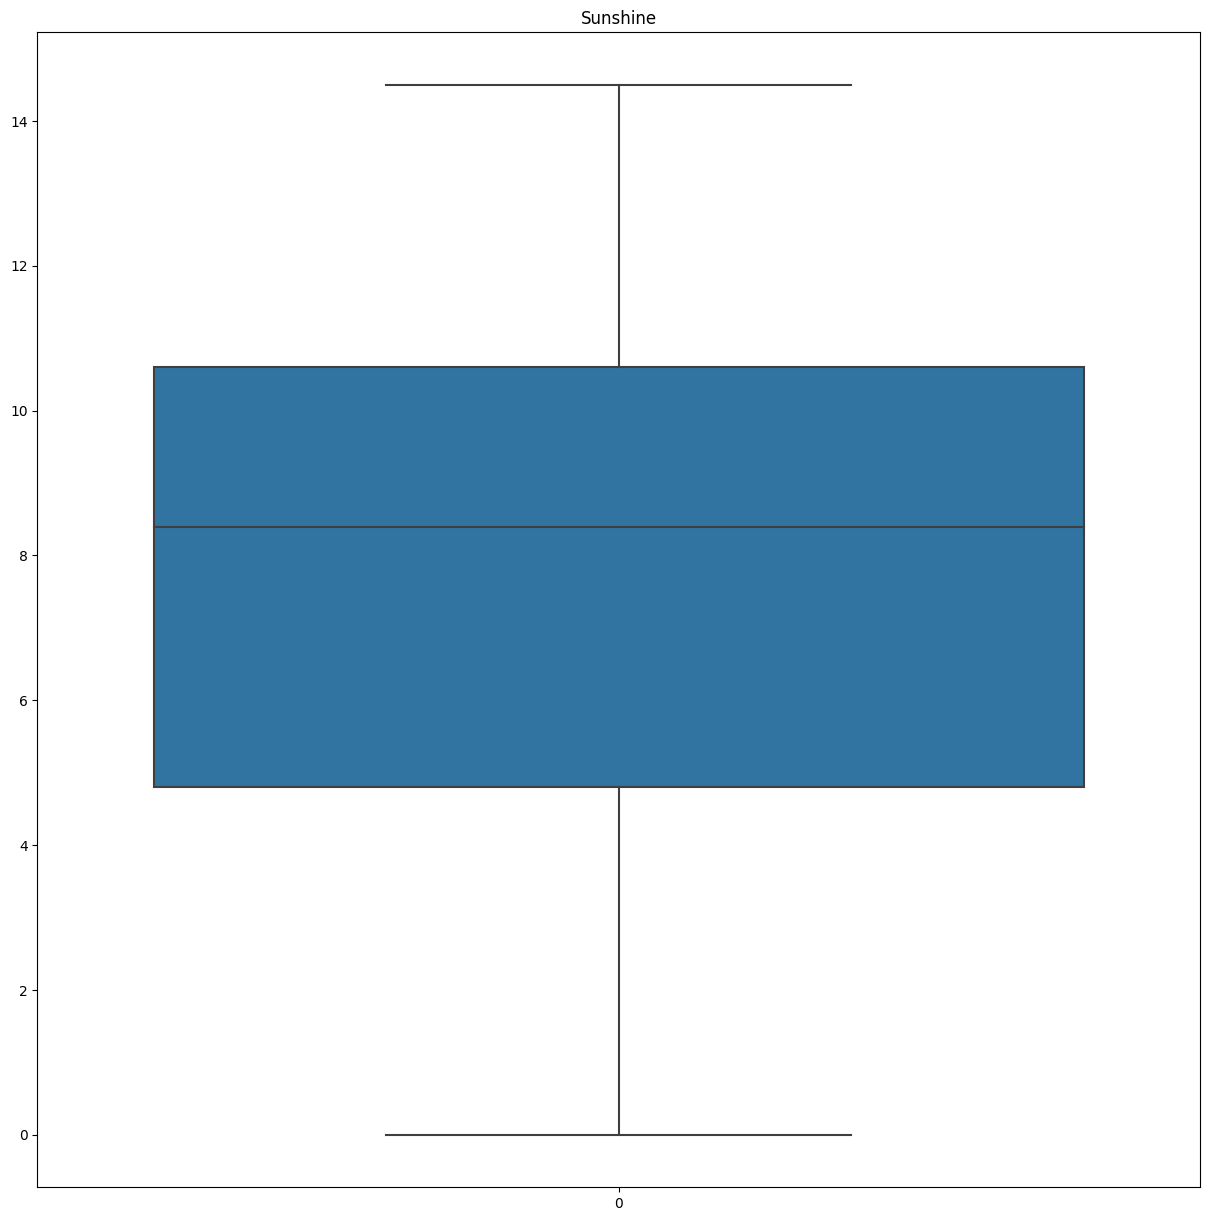

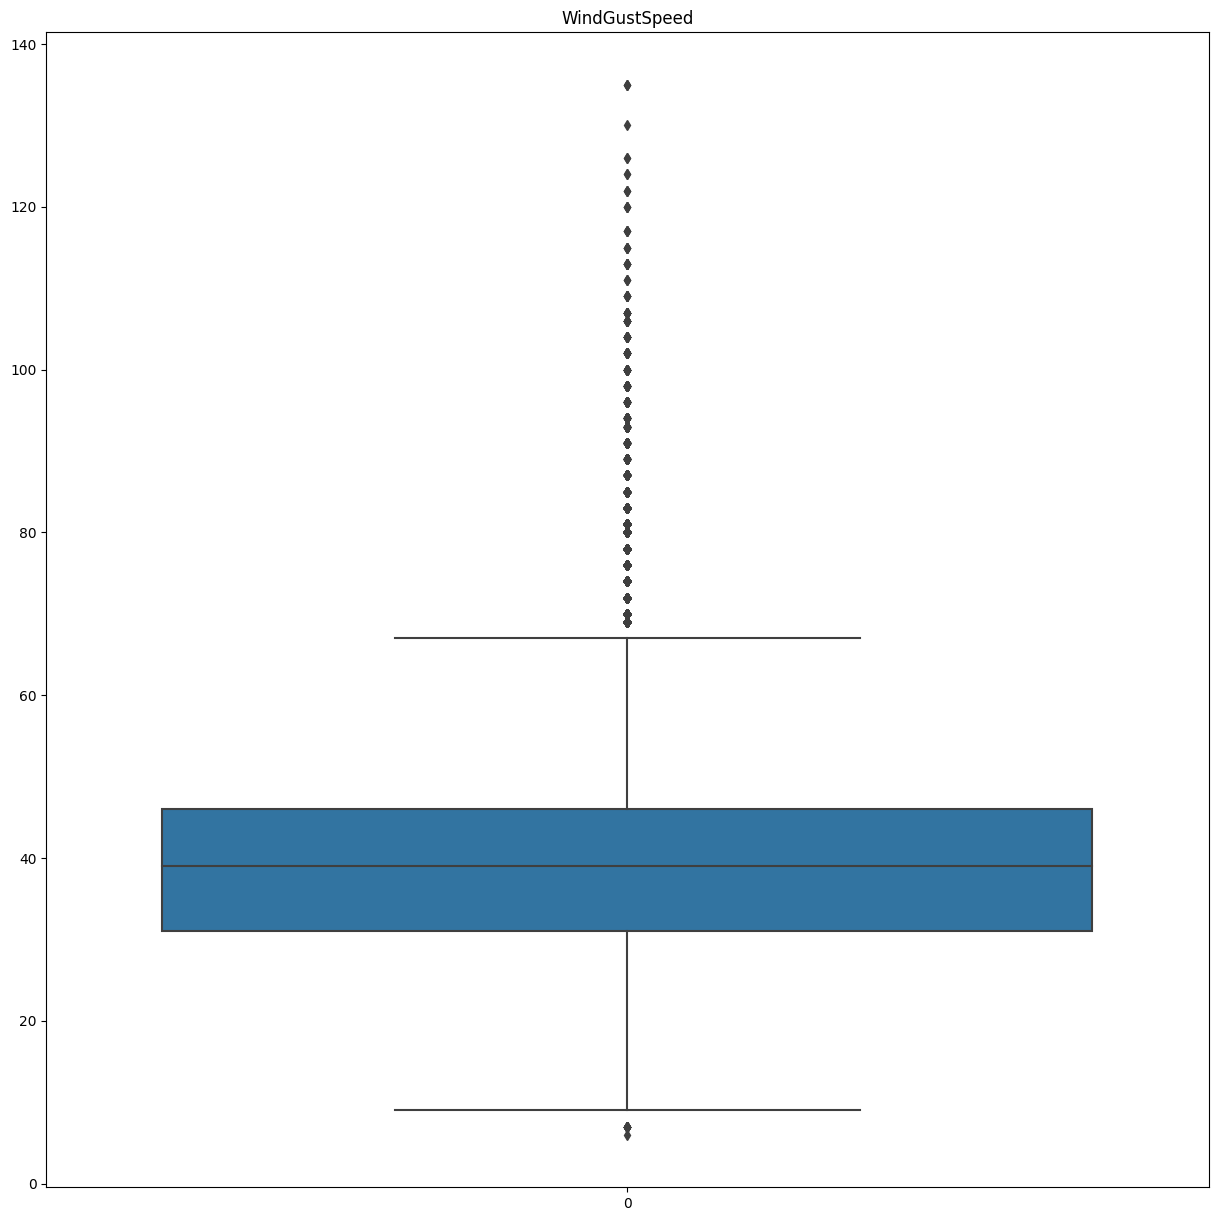

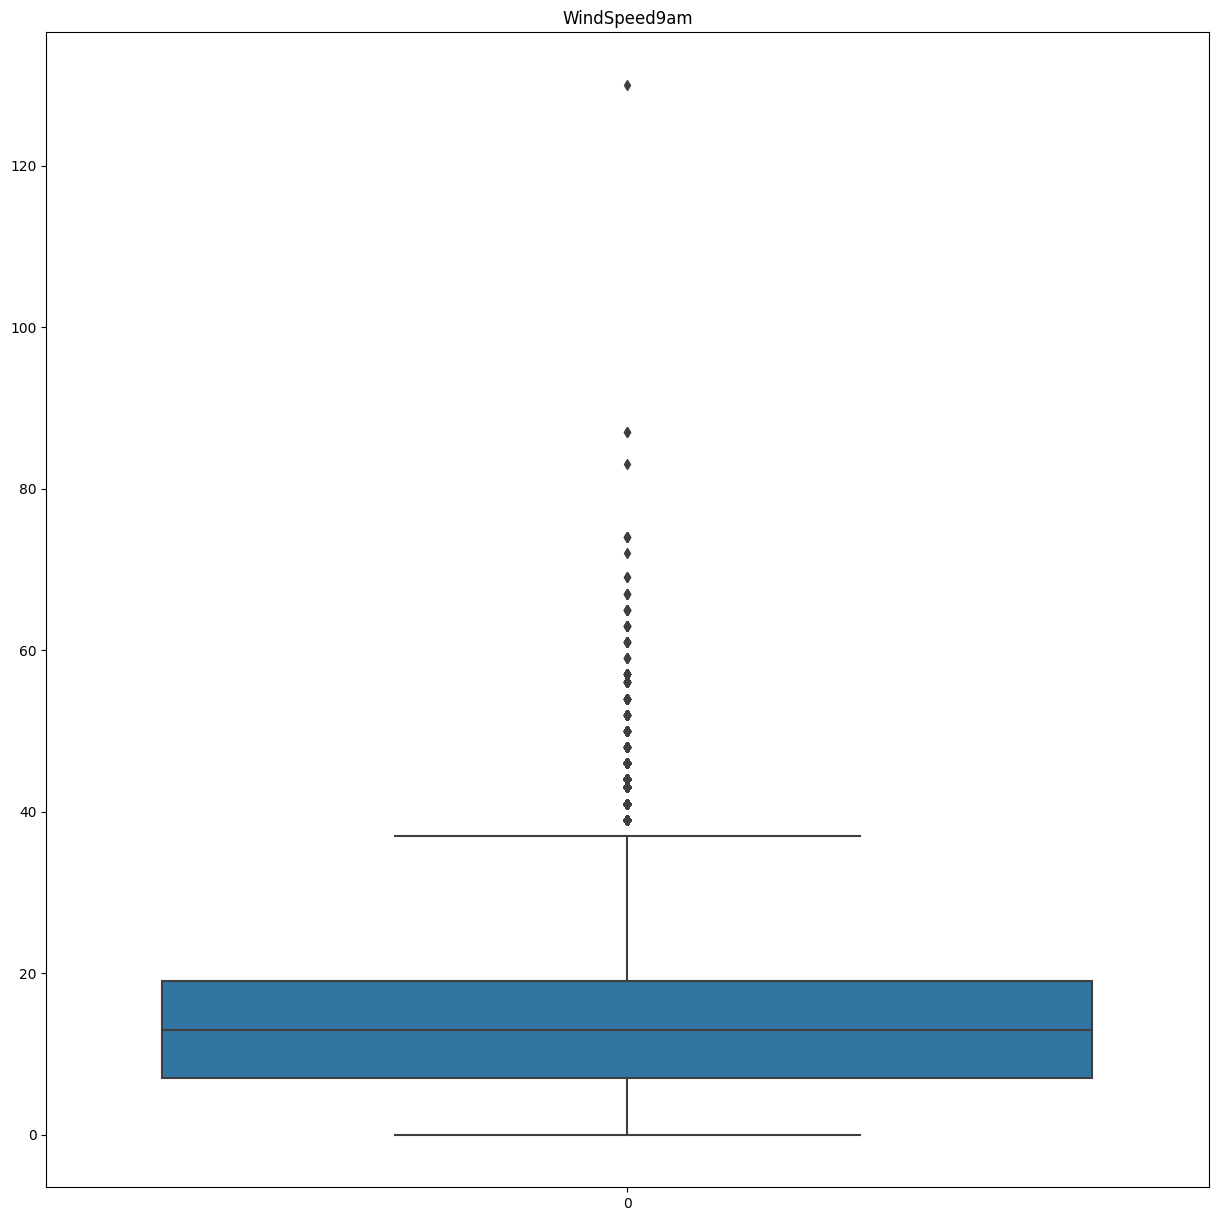

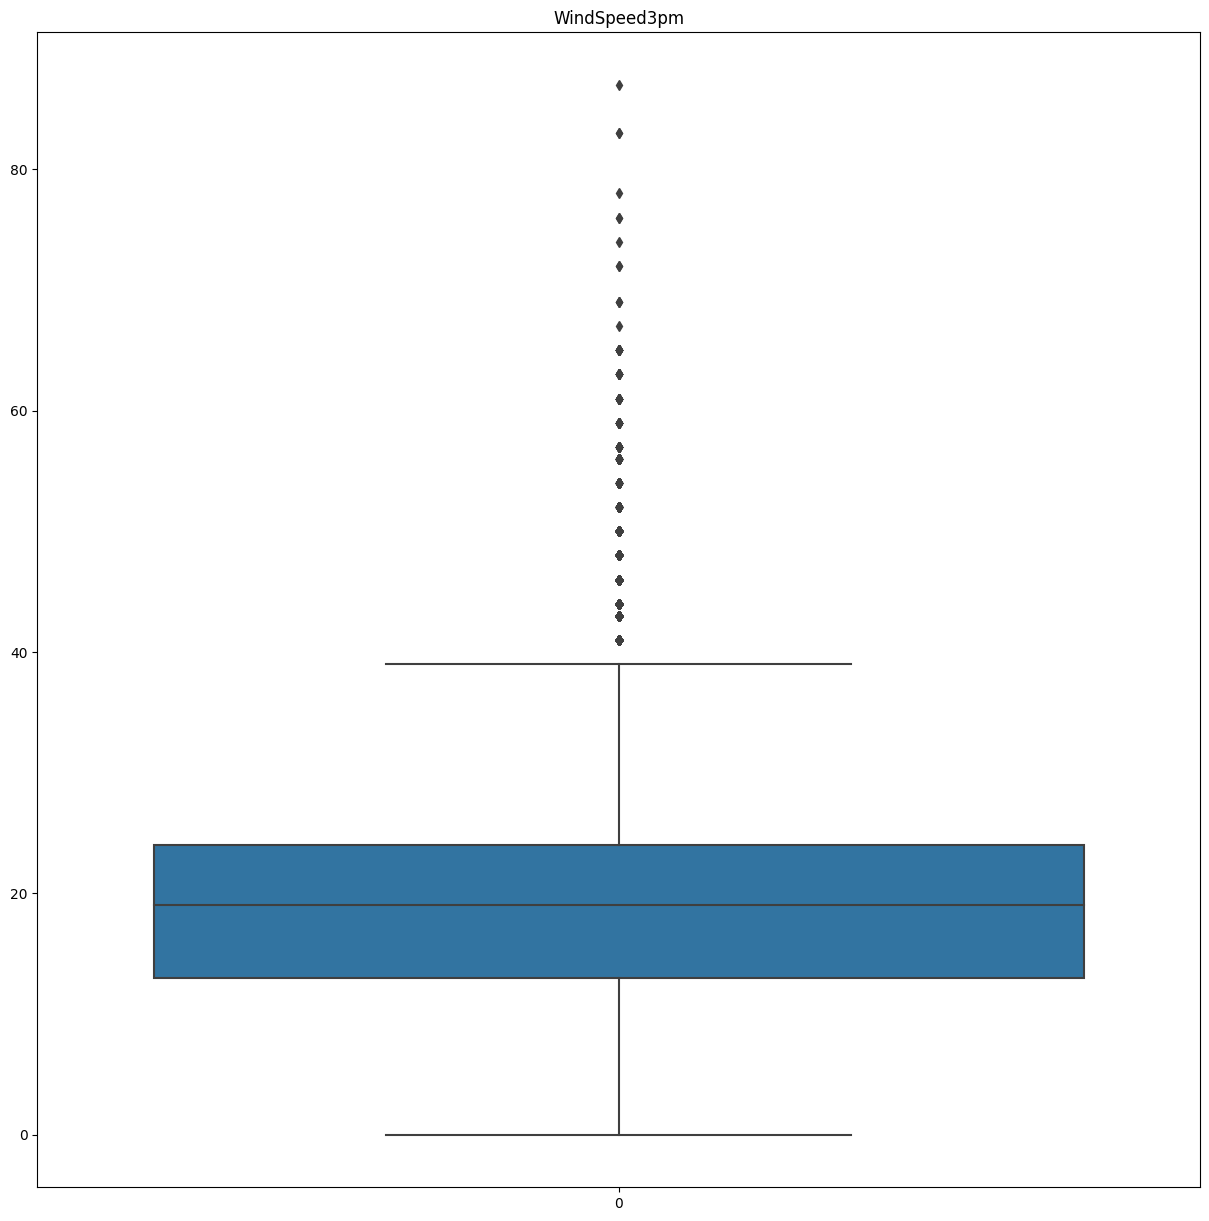

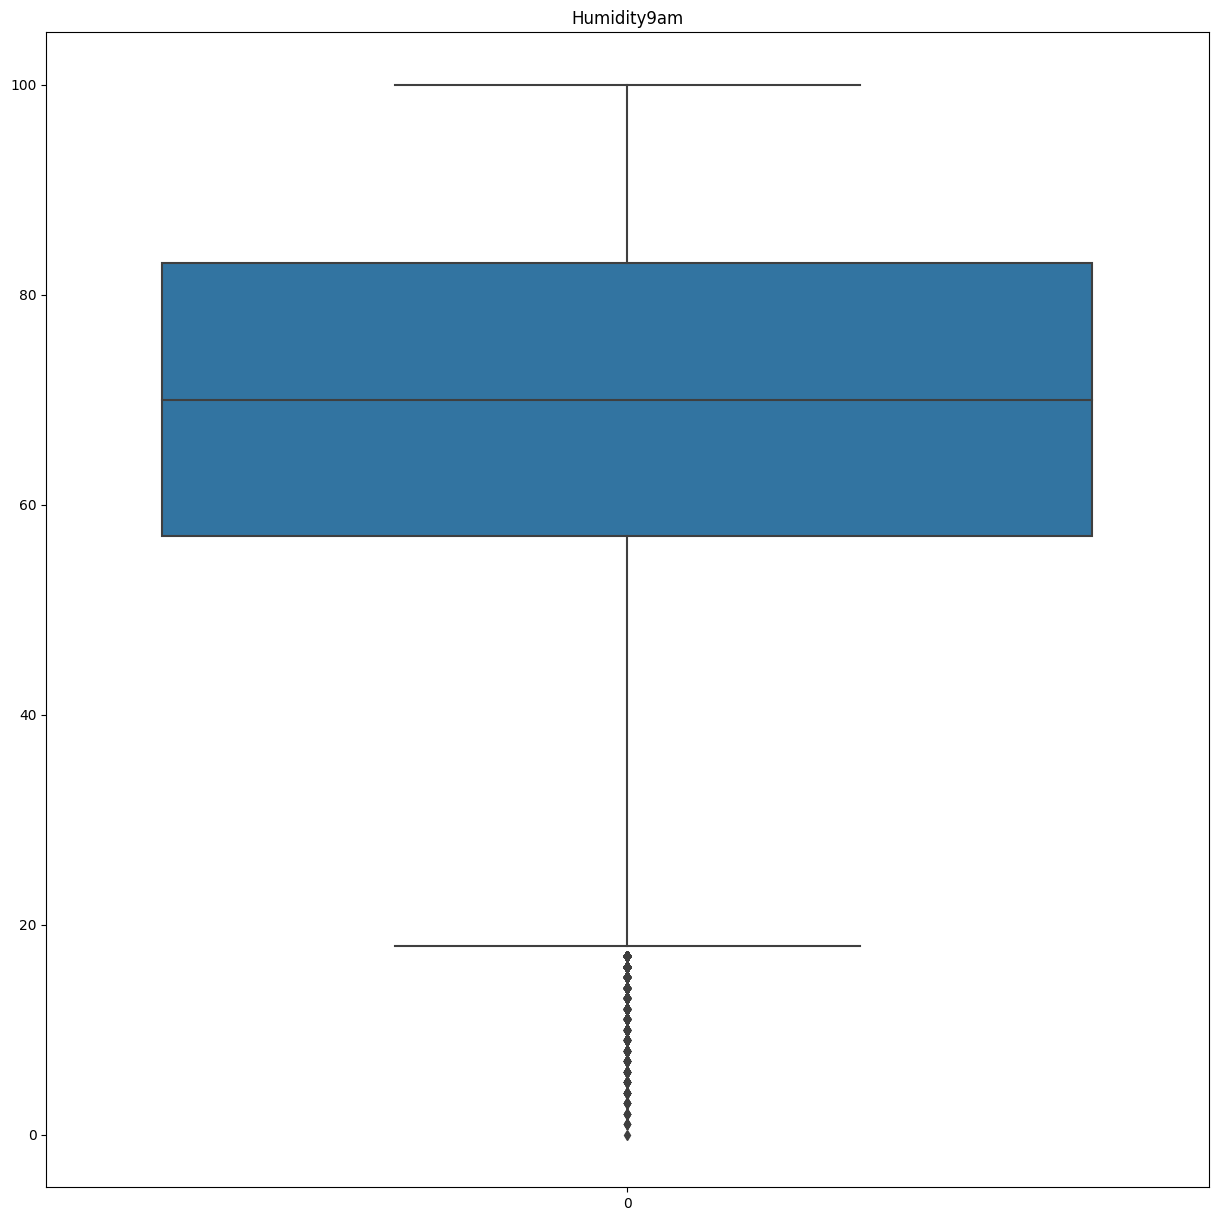

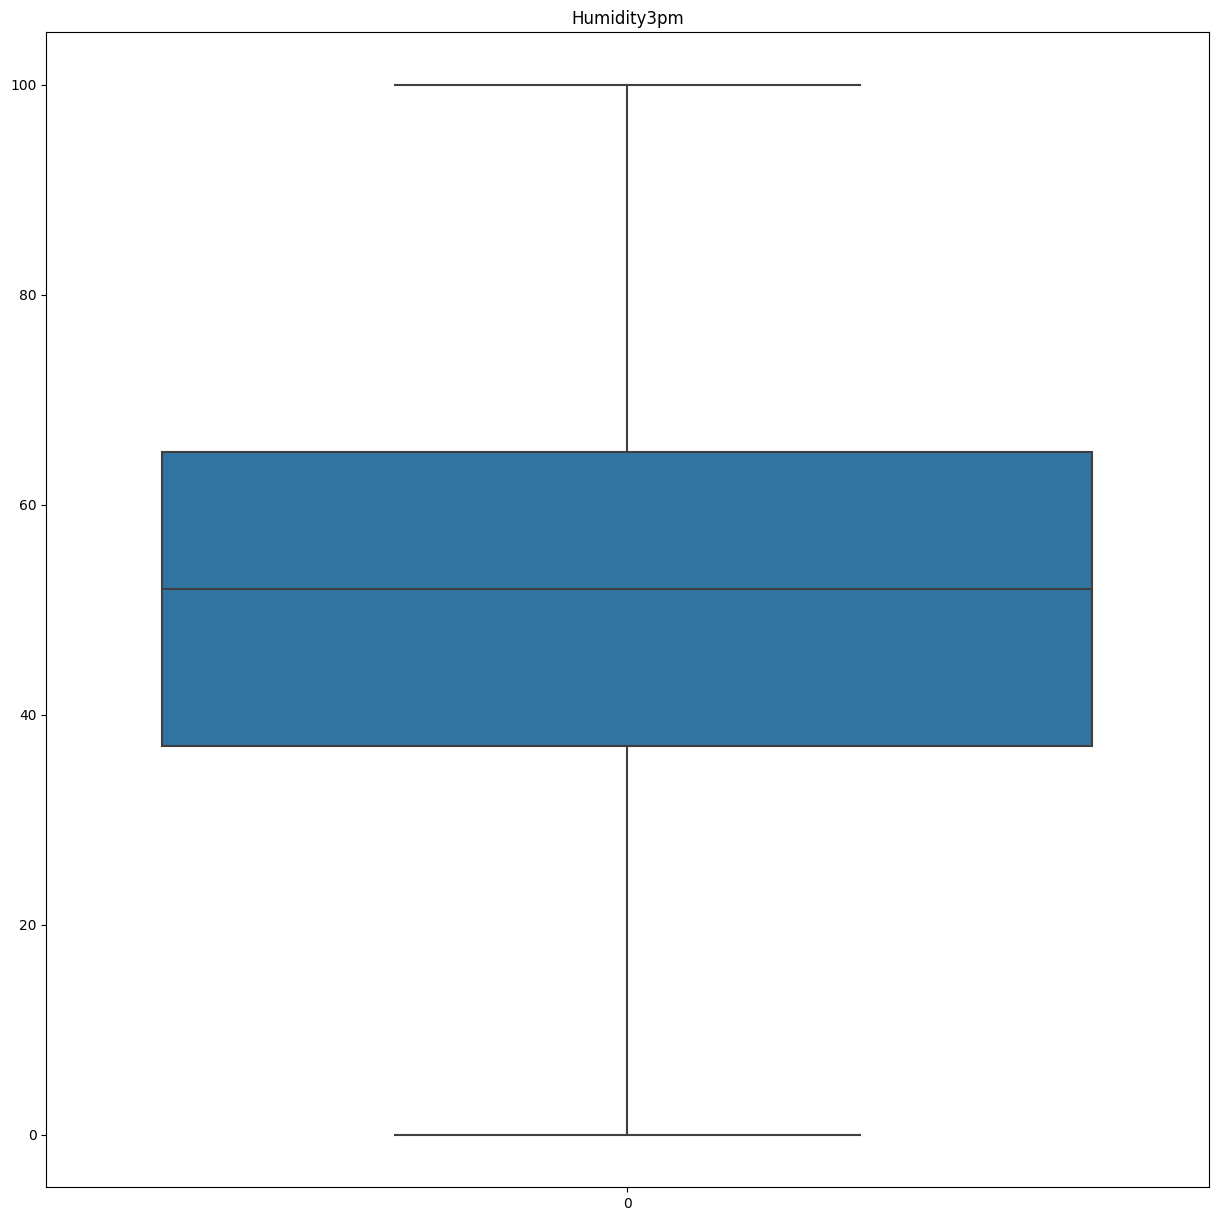

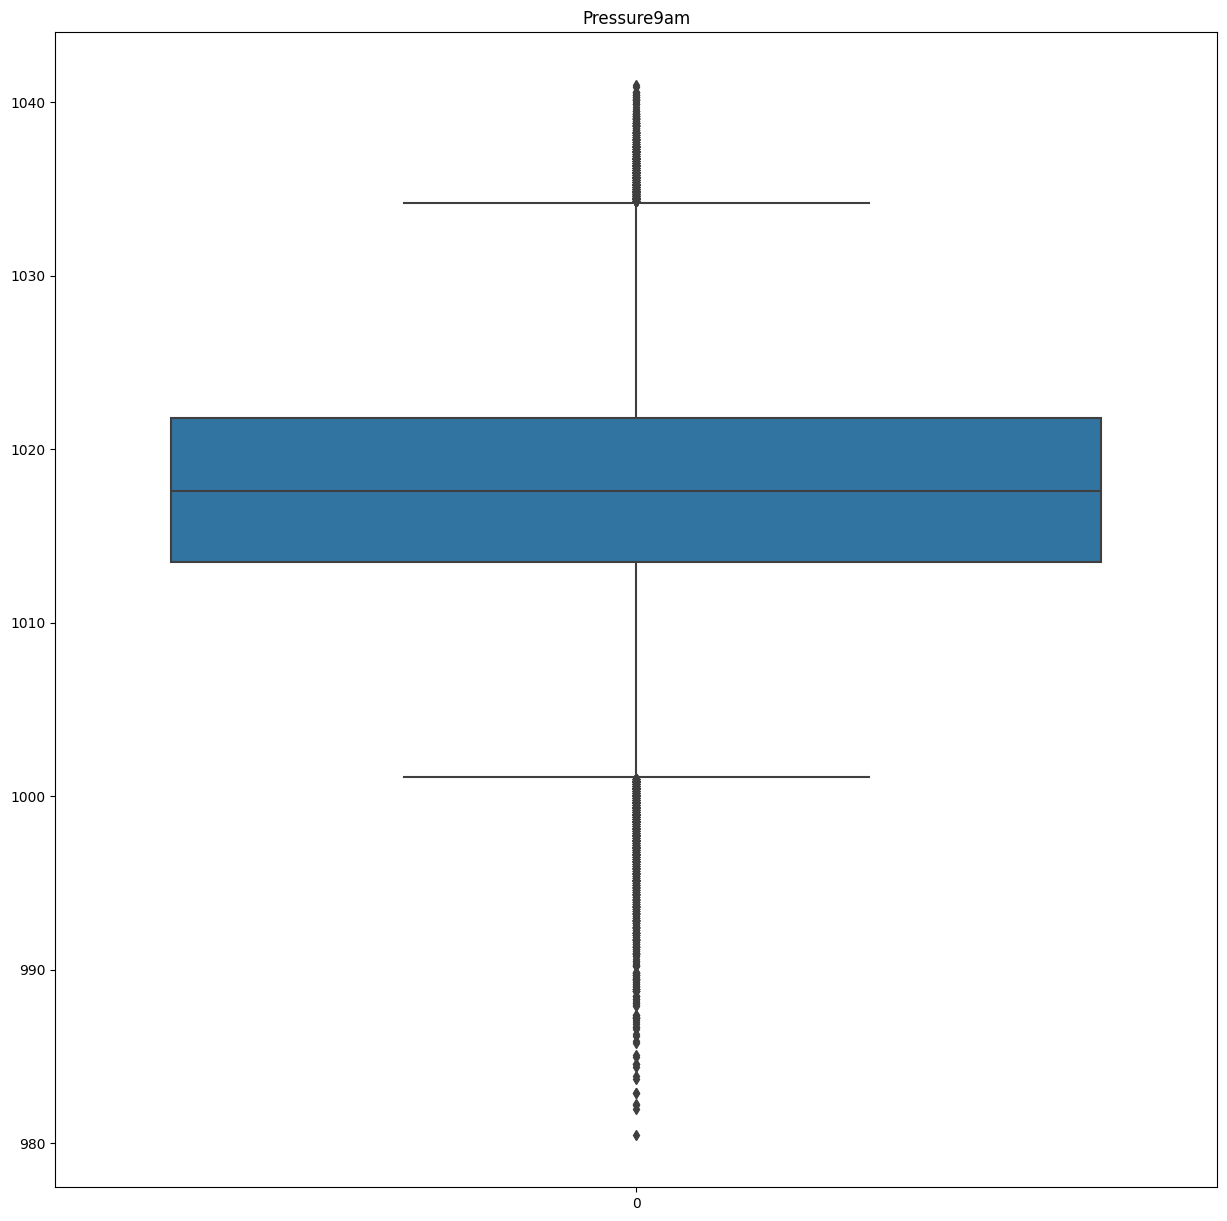

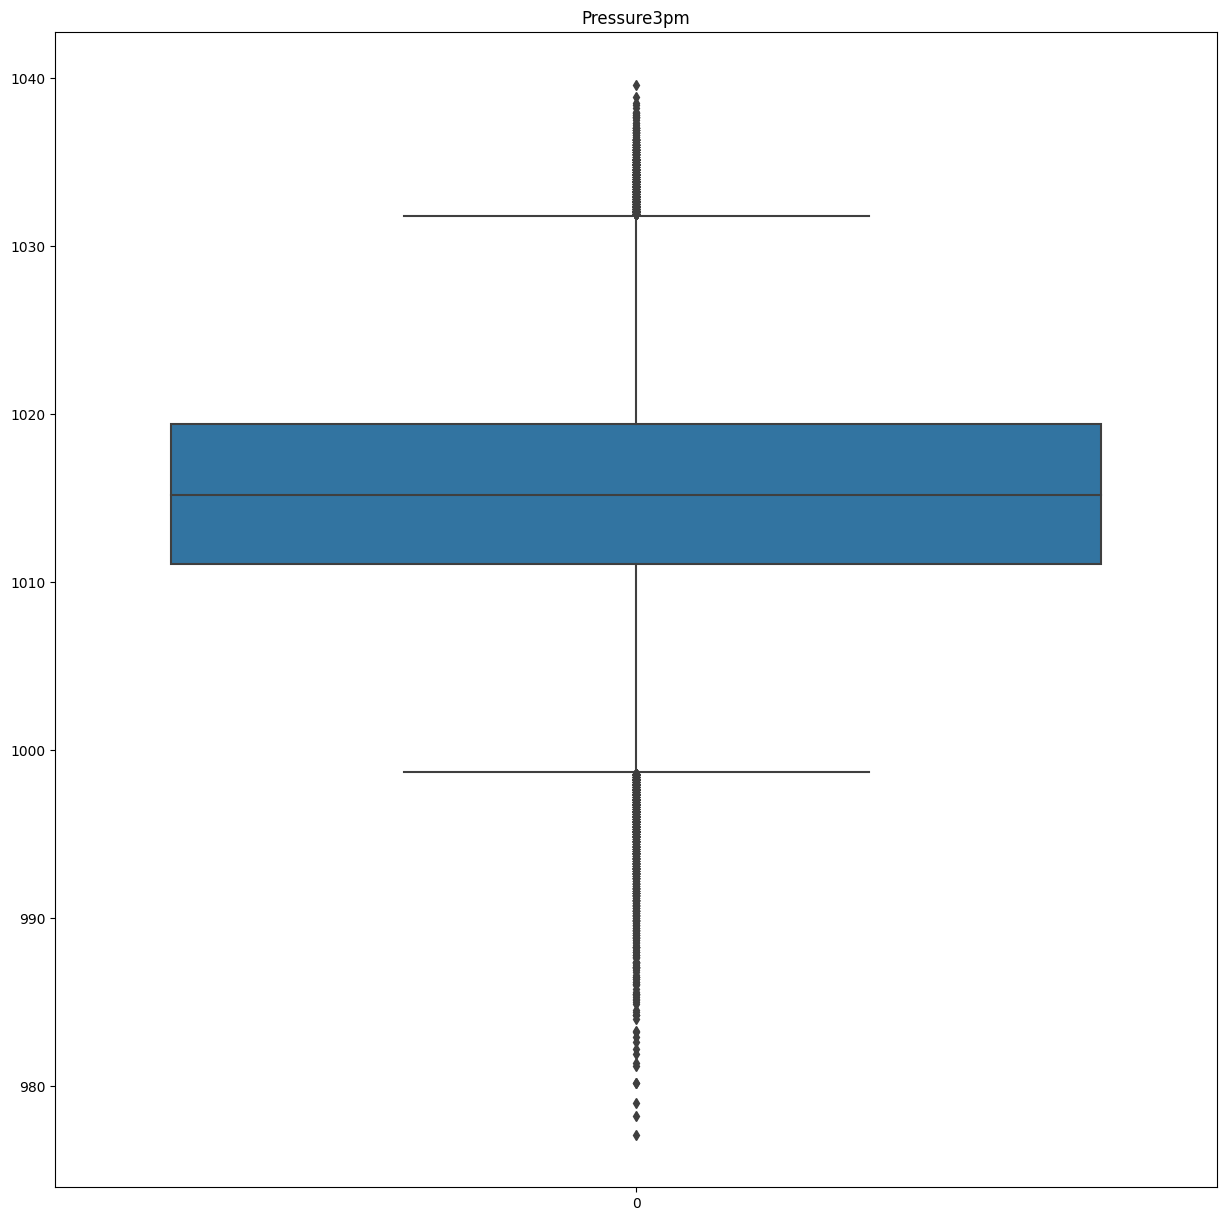

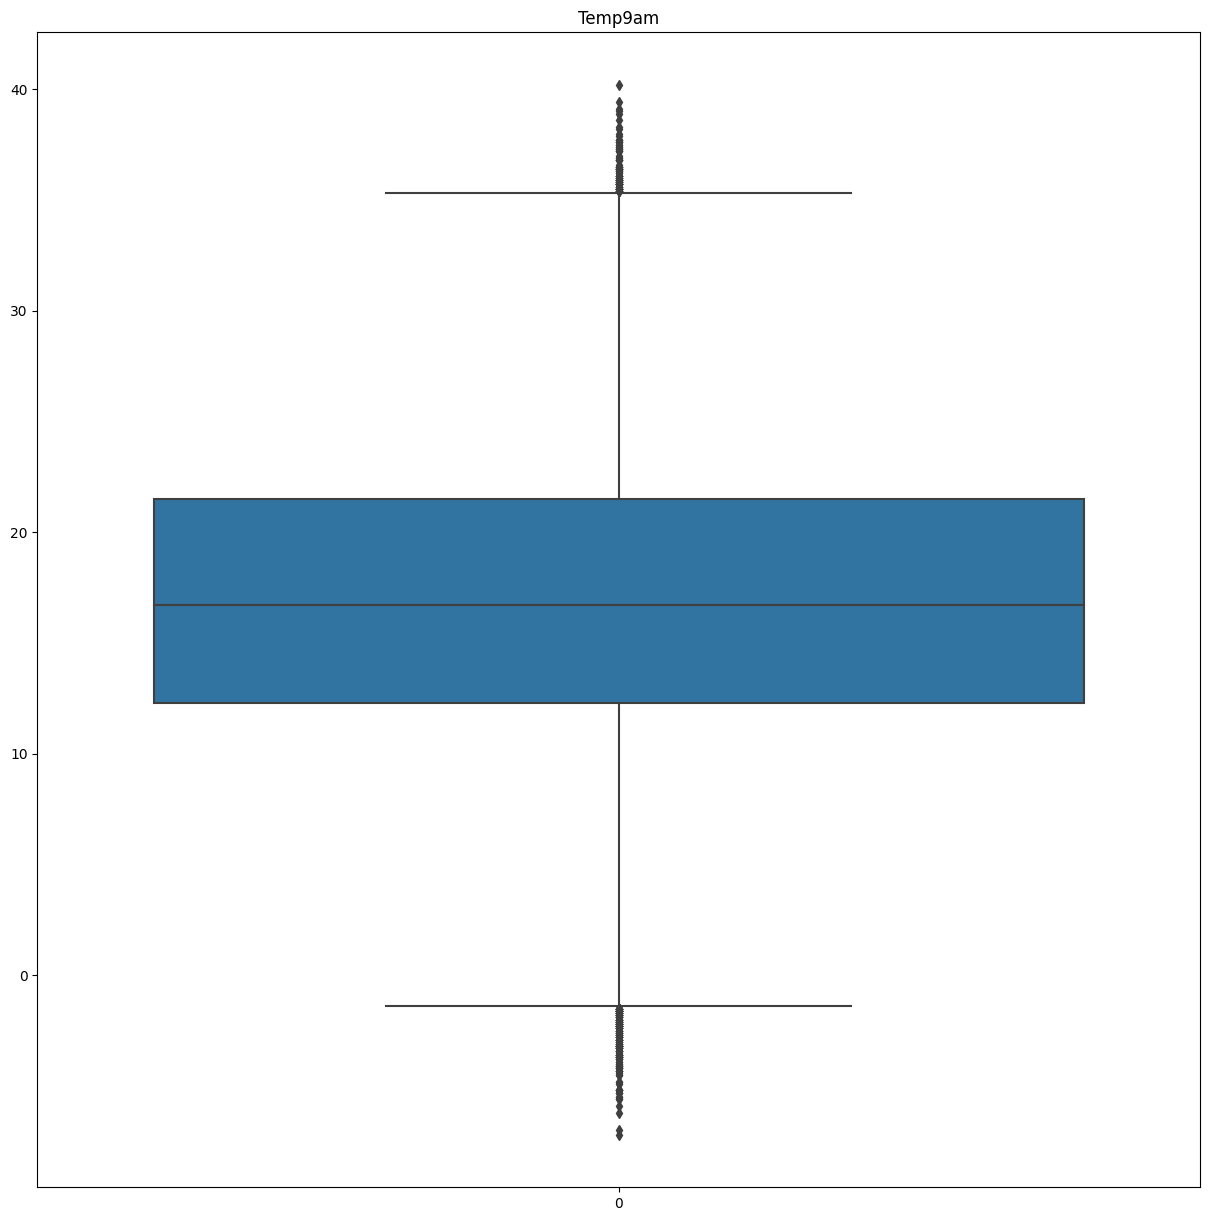

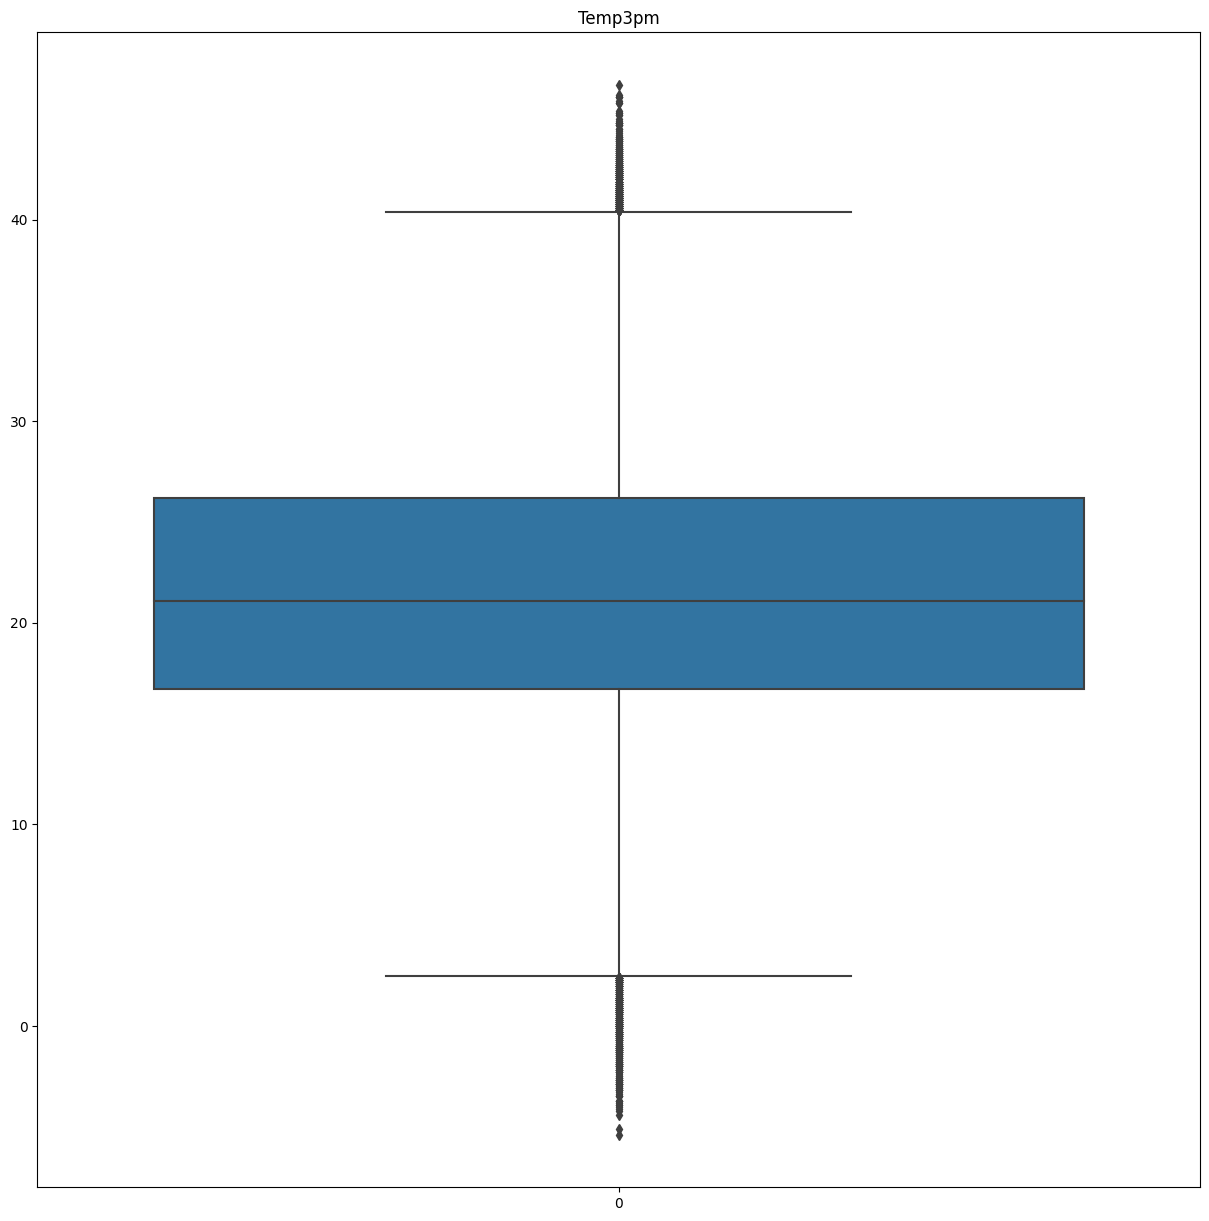

<Figure size 1500x1500 with 0 Axes>

In [33]:
for feature in continuous_feature:
    data=df.copy()
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.figure(figsize=(15,15))

In [34]:
for feature in continuous_feature:
    print(feature)

MinTemp
MaxTemp
Rainfall
Evaporation
Sunshine
WindGustSpeed
WindSpeed9am
WindSpeed3pm
Humidity9am
Humidity3pm
Pressure9am
Pressure3pm
Temp9am
Temp3pm


In [35]:
IQR=df.MinTemp.quantile(0.75)-df.MinTemp.quantile(0.25)
lower_bridge=df.MinTemp.quantile(0.25)-(IQR*1.5)
upper_bridge=df.MinTemp.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-5.950000000000002 30.450000000000003


In [36]:
df.loc[df['MinTemp']>=30.45,'MinTemp']=30.45
df.loc[df['MinTemp']<=-5.95,'MinTemp']=-5.95

In [37]:
IQR=df.MaxTemp.quantile(0.75)-df.MaxTemp.quantile(0.25)
lower_bridge=df.MaxTemp.quantile(0.25)-(IQR*1.5)
upper_bridge=df.MaxTemp.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

2.700000000000001 43.5


In [38]:
df.loc[df['MaxTemp']>=43.5,'MaxTemp']=43.5
df.loc[df['MaxTemp']<=2.7,'MaxTemp']=2.7

In [39]:
IQR=df.Rainfall.quantile(0.75)-df.Rainfall.quantile(0.25)
lower_bridge=df.Rainfall.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Rainfall.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-0.8999999999999999 1.5


In [40]:
df.loc[df['Rainfall']>=1.5,'Rainfall']=1.5
df.loc[df['Rainfall']<=-0.89,'Rainfall']=-0.89

In [41]:
IQR=df.Evaporation.quantile(0.75)-df.Evaporation.quantile(0.25)
lower_bridge=df.Evaporation.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Evaporation.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-4.600000000000001 14.600000000000001


In [42]:
df.loc[df['Evaporation']>=14.6,'Evaporation']=14.6
df.loc[df['Evaporation']<=-4.6,'Evaporation']=-4.6

In [43]:
IQR=df.WindGustSpeed.quantile(0.75)-df.WindGustSpeed.quantile(0.25)
lower_bridge=df.WindGustSpeed.quantile(0.25)-(IQR*1.5)
upper_bridge=df.WindGustSpeed.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

8.5 68.5


In [44]:
df.loc[df['WindGustSpeed']>=68.5,'WindGustSpeed']=68.5
df.loc[df['WindGustSpeed']<=8.5,'WindGustSpeed']=8.5

In [45]:
IQR=df.WindSpeed9am.quantile(0.75)-df.WindSpeed9am.quantile(0.25)
lower_bridge=df.WindSpeed9am.quantile(0.25)-(IQR*1.5)
upper_bridge=df.WindSpeed9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-11.0 37.0


In [46]:
df.loc[df['WindSpeed9am']>=37,'WindSpeed9am']=37
df.loc[df['WindSpeed9am']<=-11,'WindSpeed9am']=-11

In [47]:
IQR=df.WindSpeed3pm.quantile(0.75)-df.WindSpeed3pm.quantile(0.25)
lower_bridge=df.WindSpeed3pm.quantile(0.25)-(IQR*1.5)
upper_bridge=df.WindSpeed3pm.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-3.5 40.5


In [48]:
df.loc[df['WindSpeed3pm']>40.5,'WindSpeed3pm']=40.5
df.loc[df['WindSpeed3pm']<=-3.5,'WindSpeed3pm']=-3.5

In [49]:
IQR=df.Humidity9am.quantile(0.75)-df.Humidity9am.quantile(0.25)
lower_bridge=df.Humidity9am.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Humidity9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

18.0 122.0


In [50]:
df.loc[df['Humidity9am']>=122,'Humidity9am']=122
df.loc[df['Humidity9am']<=18,'Humidity9am']=18

In [51]:
IQR=df.Pressure9am.quantile(0.75)-df.Pressure9am.quantile(0.25)
lower_bridge=df.Pressure9am.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Pressure9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

1001.0500000000001 1034.25


In [52]:
df.loc[df['Pressure9am']>=1034.25,'Pressure9am']=1034.25
df.loc[df['Pressure9am']<=1001.05,'Pressure9am']=1001.05

In [53]:
IQR=df.Pressure3pm.quantile(0.75)-df.Pressure3pm.quantile(0.25)
lower_bridge=df.Pressure3pm.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Pressure3pm.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

998.6500000000001 1031.85


In [54]:
df.loc[df['Pressure3pm']>=1031.85,'Pressure3pm']=1031.85
df.loc[df['Pressure3pm']<=998.65,'Pressure3pm']=998.65

In [55]:
IQR=df.Temp9am.quantile(0.75)-df.Temp9am.quantile(0.25)
lower_bridge=df.Temp9am.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Temp9am.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

-1.4999999999999982 35.3


In [56]:
df.loc[df['Temp9am']>=35.3,'Temp9am']=35.3
df.loc[df['Temp9am']<=-1.49,'Temp9am']=-1.49

In [57]:
IQR=df.Temp3pm.quantile(0.75)-df.Temp3pm.quantile(0.25)
lower_bridge=df.Temp3pm.quantile(0.25)-(IQR*1.5)
upper_bridge=df.Temp3pm.quantile(0.75)+(IQR*1.5)
print(lower_bridge, upper_bridge)

2.4499999999999993 40.45


In [58]:
df.loc[df['Temp3pm']>=40.45,'Temp3pm']=40.45
df.loc[df['Temp3pm']<=2.45,'Temp3pm']=2.45

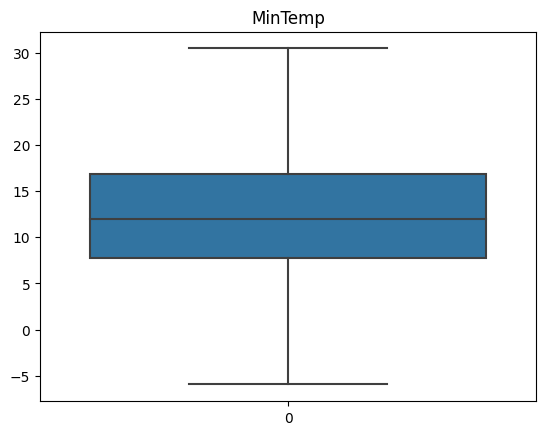

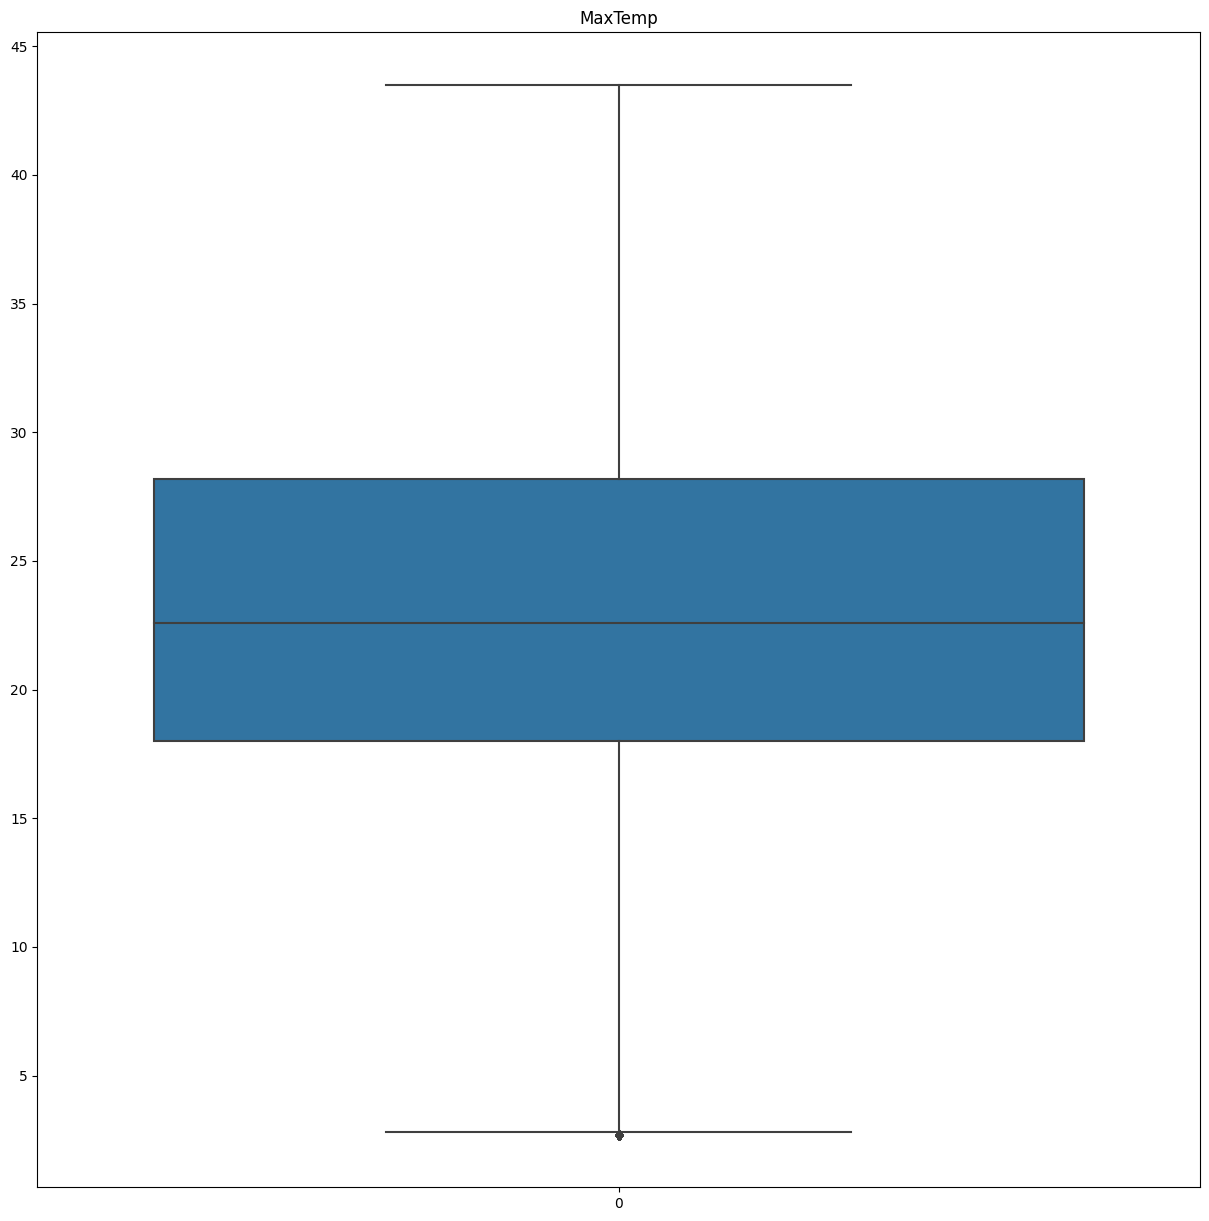

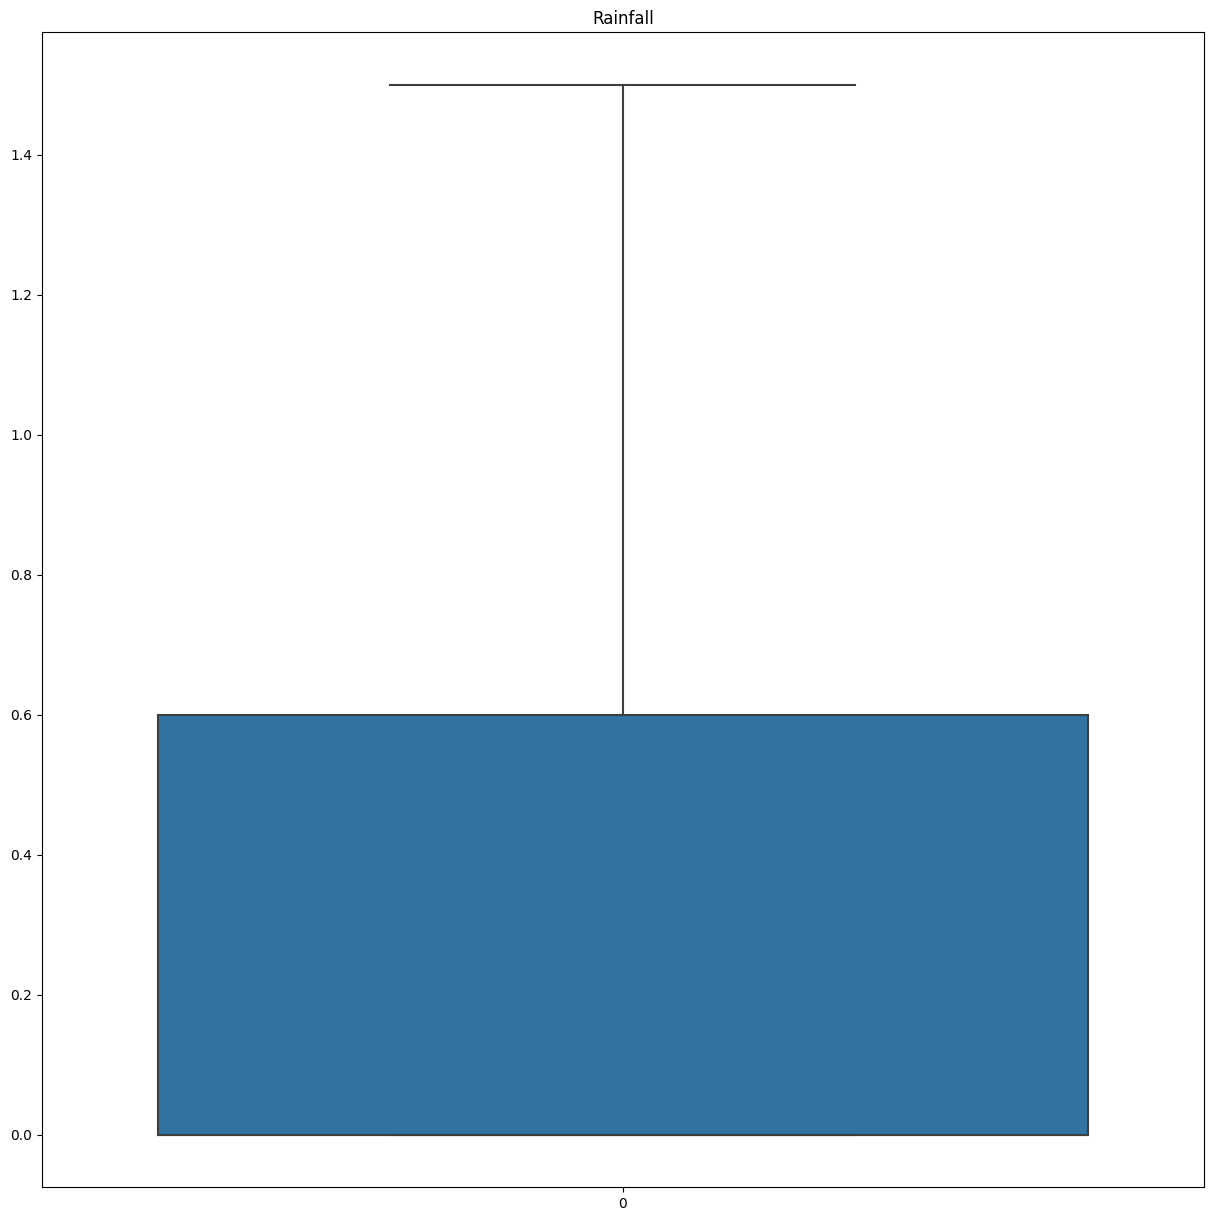

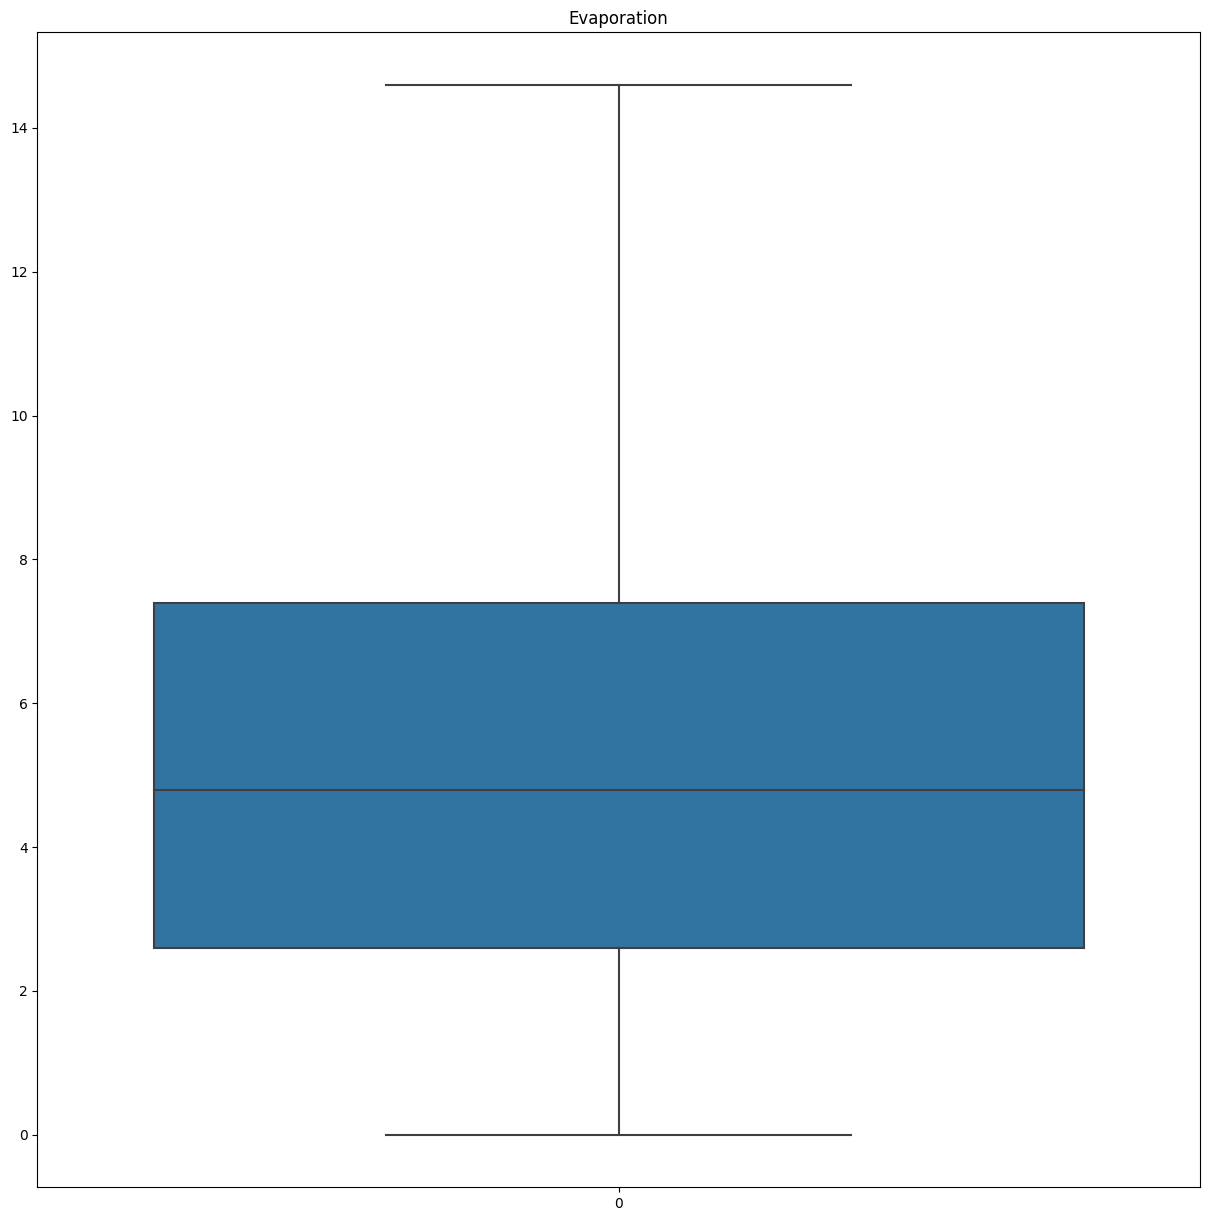

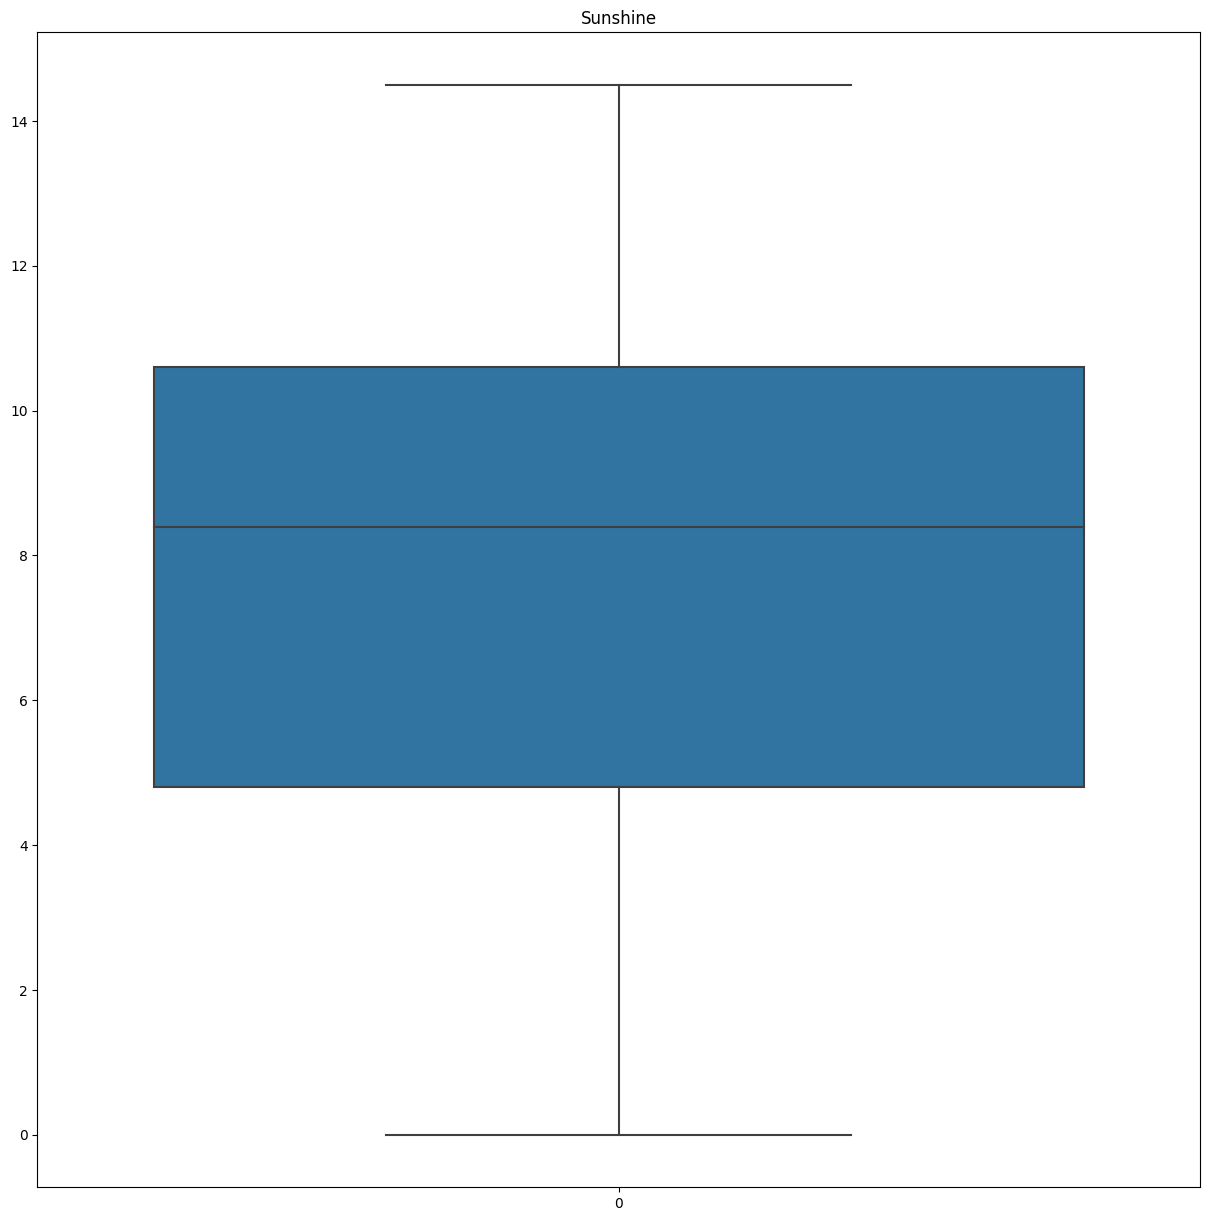

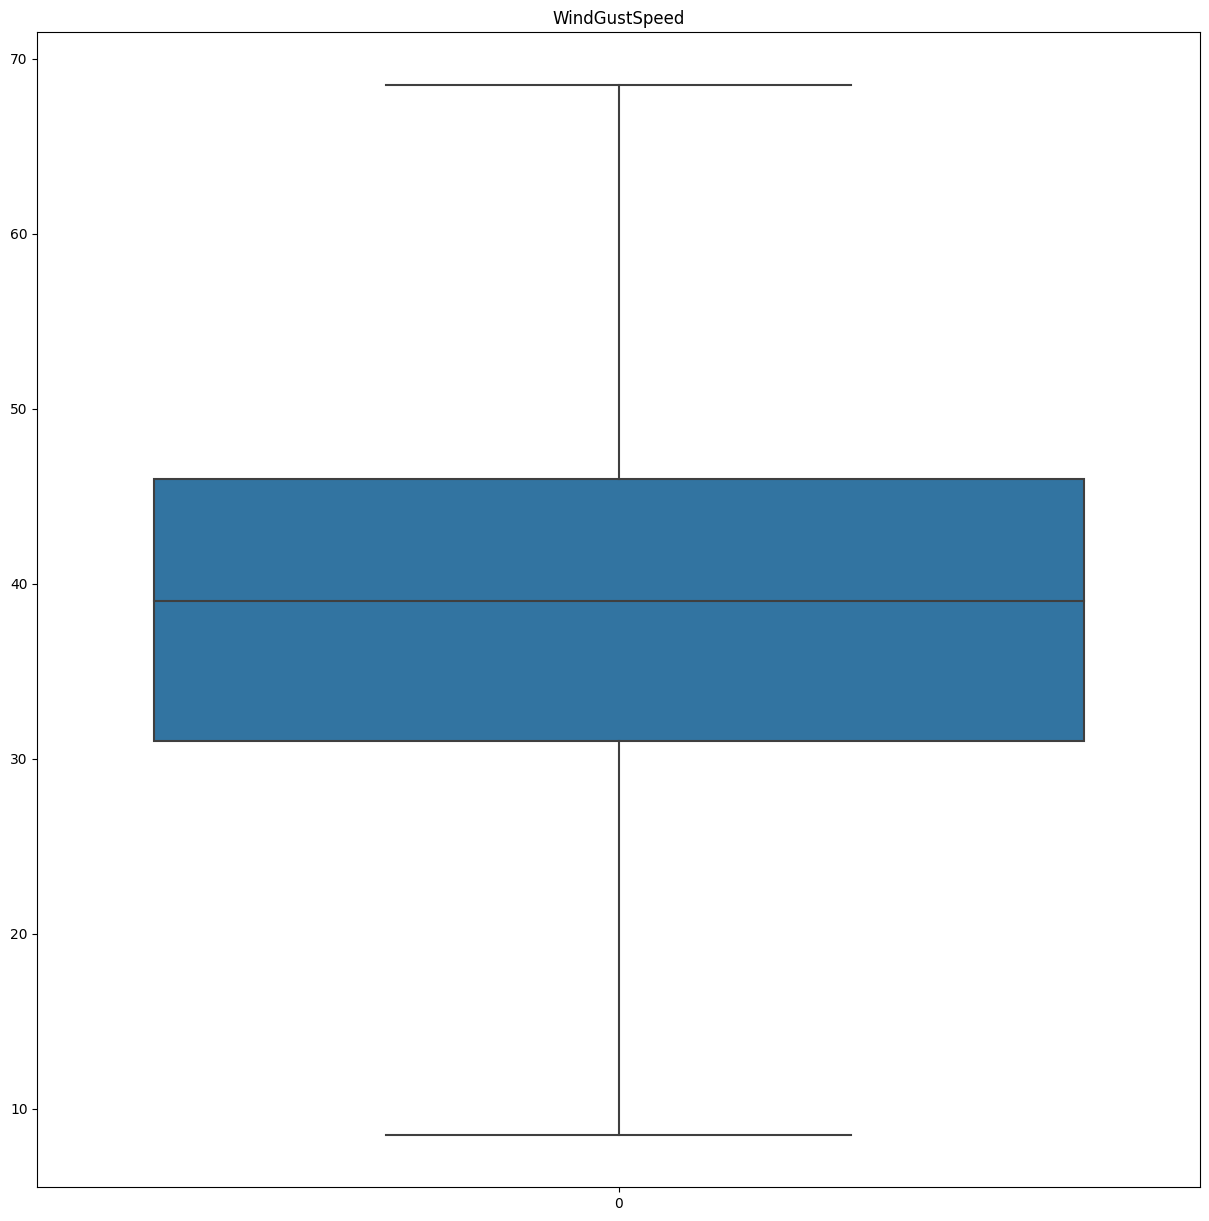

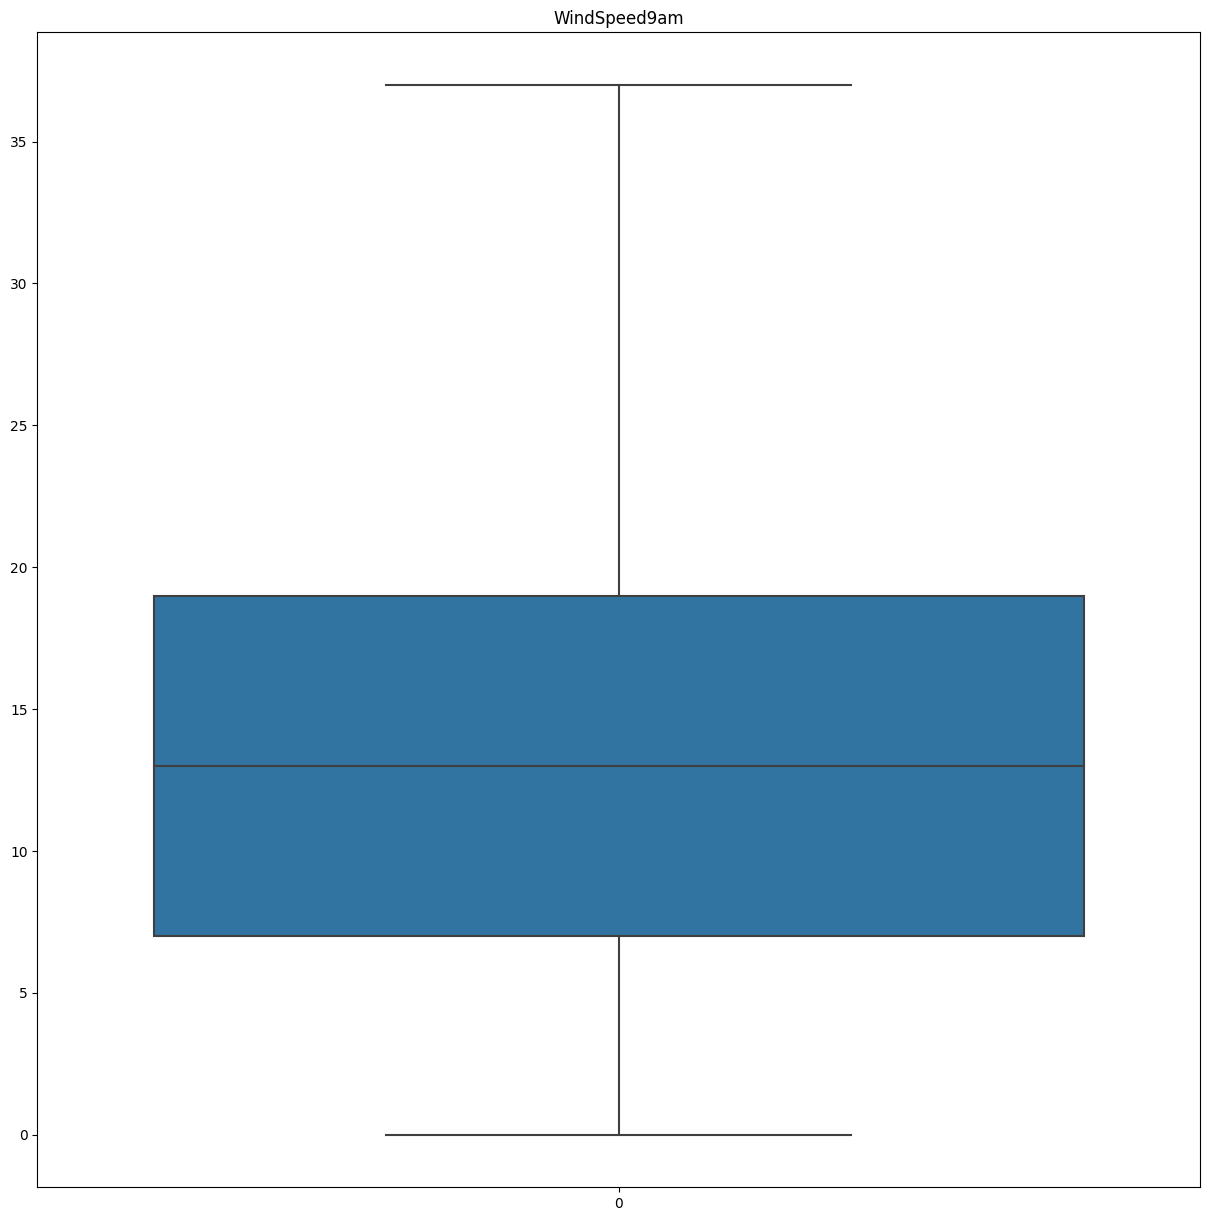

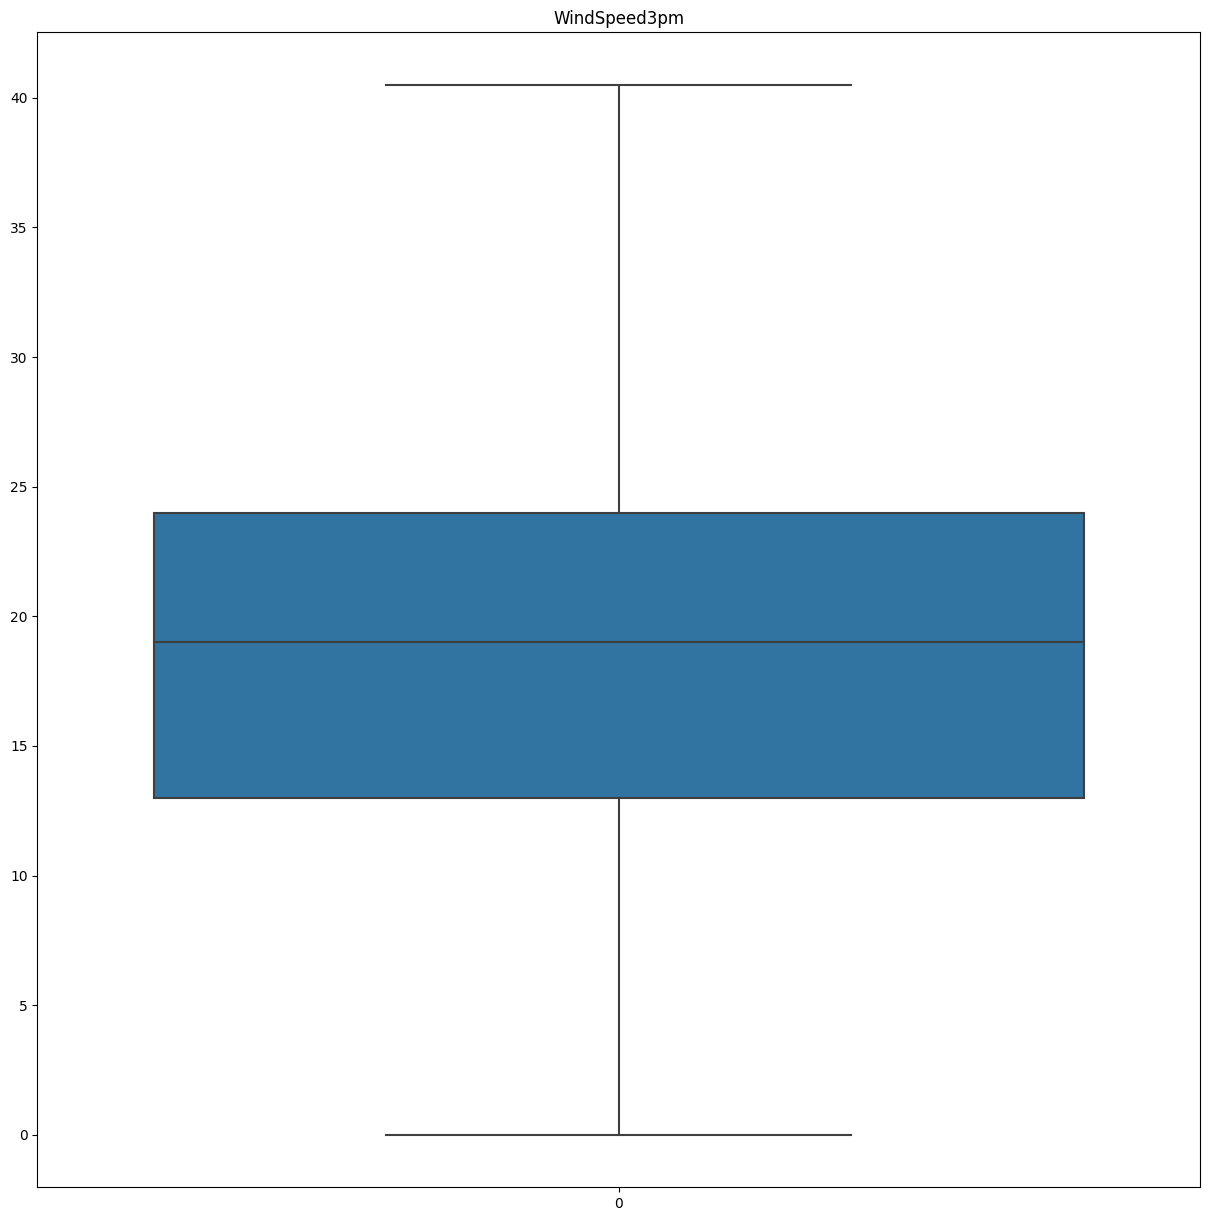

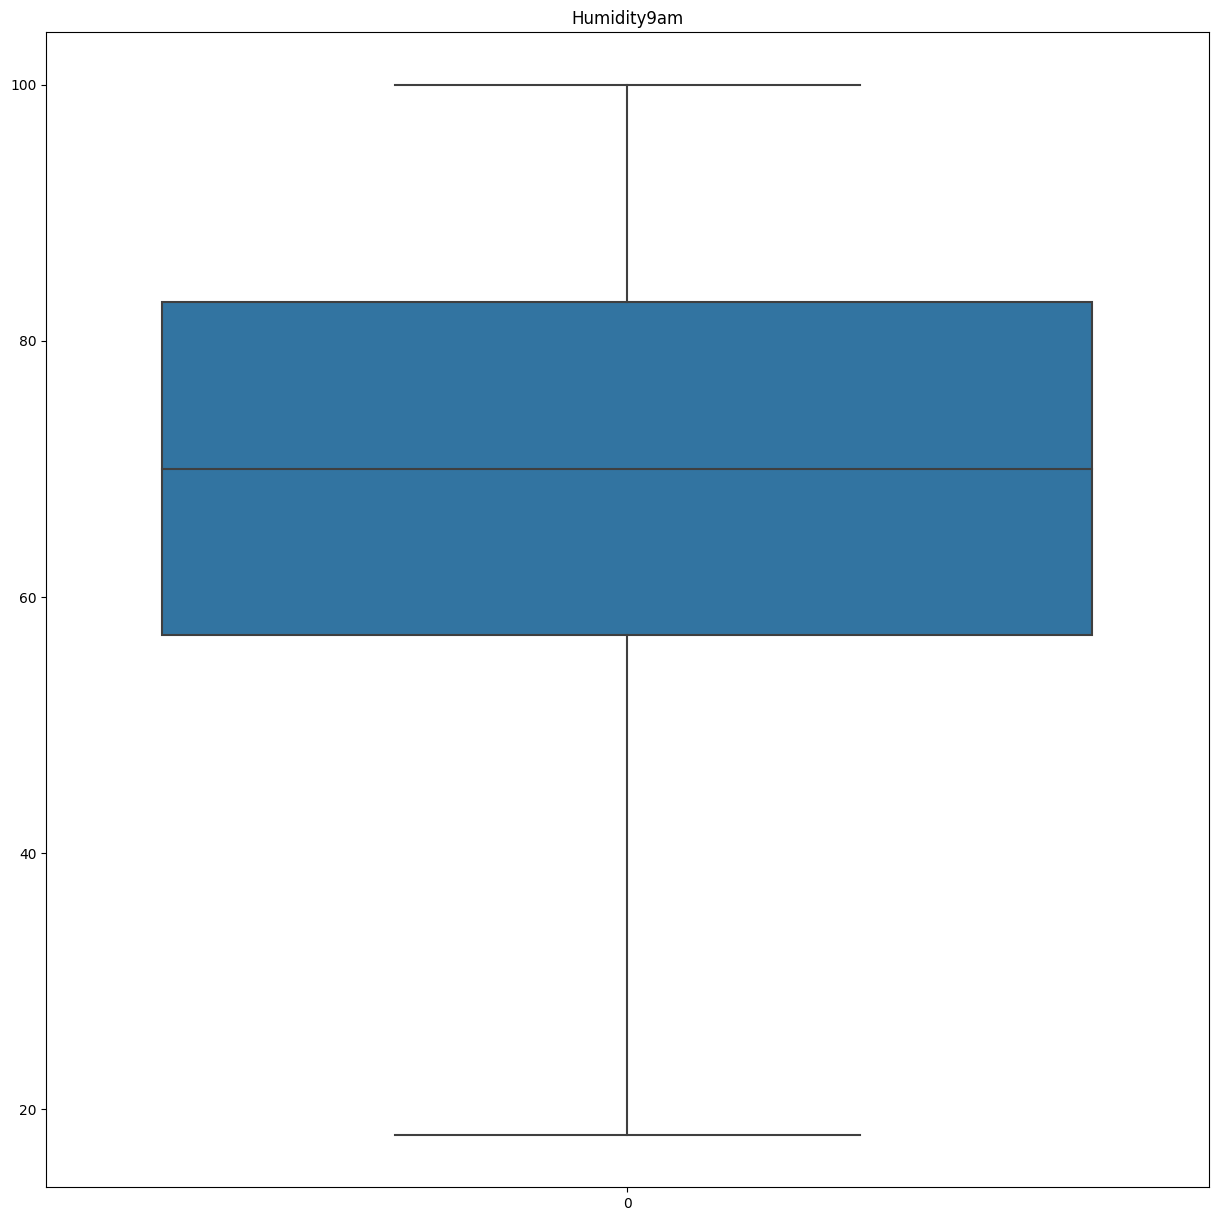

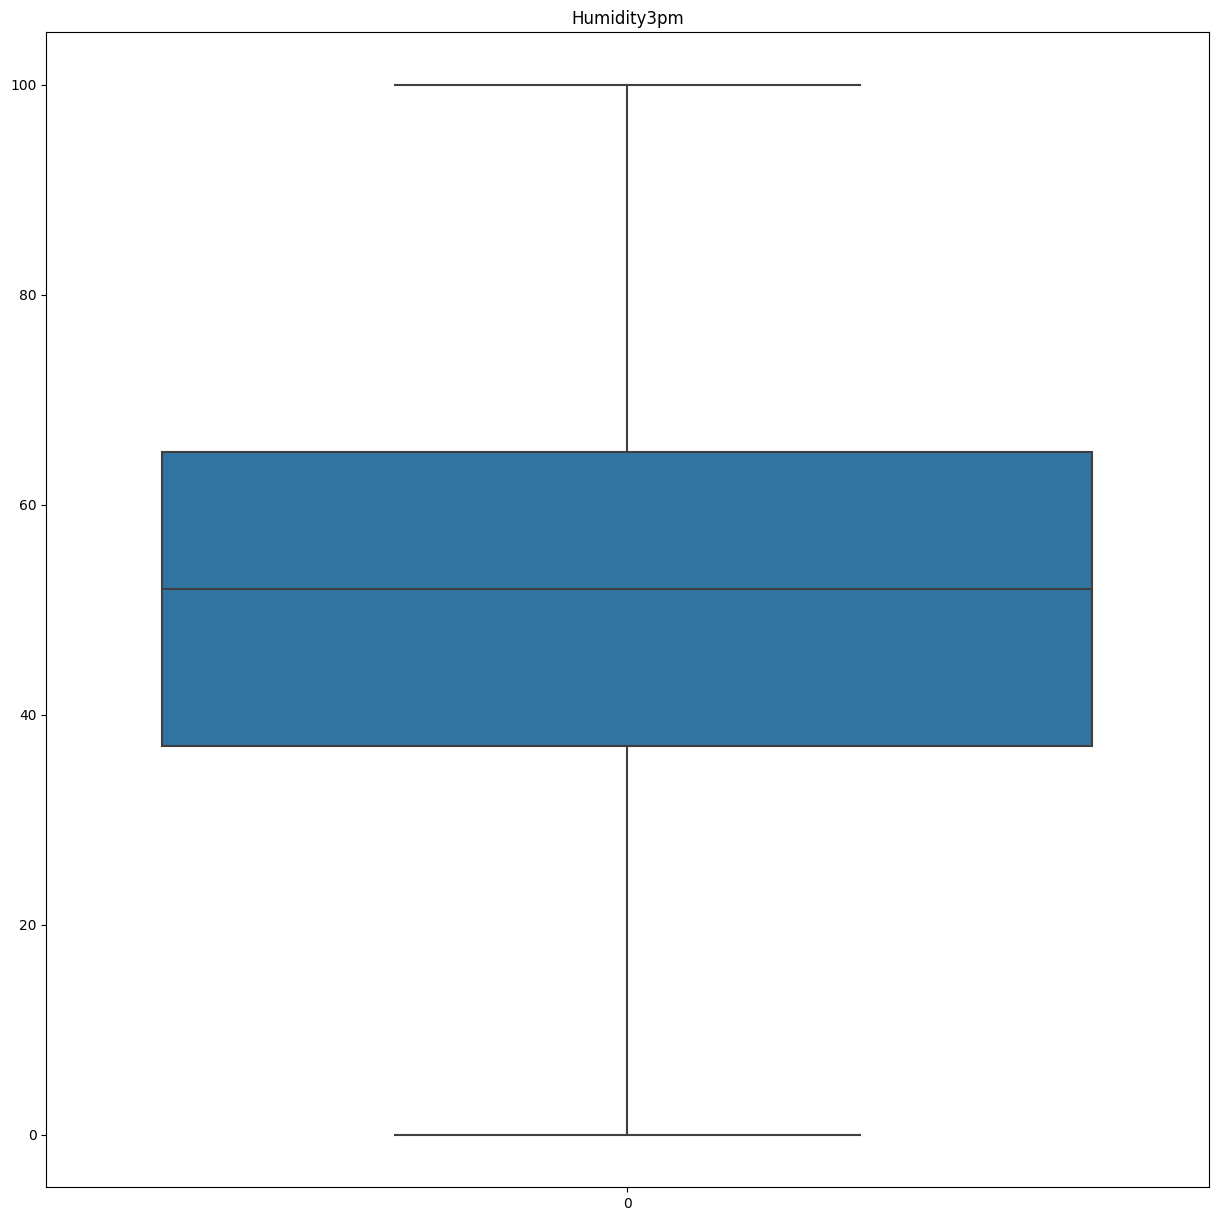

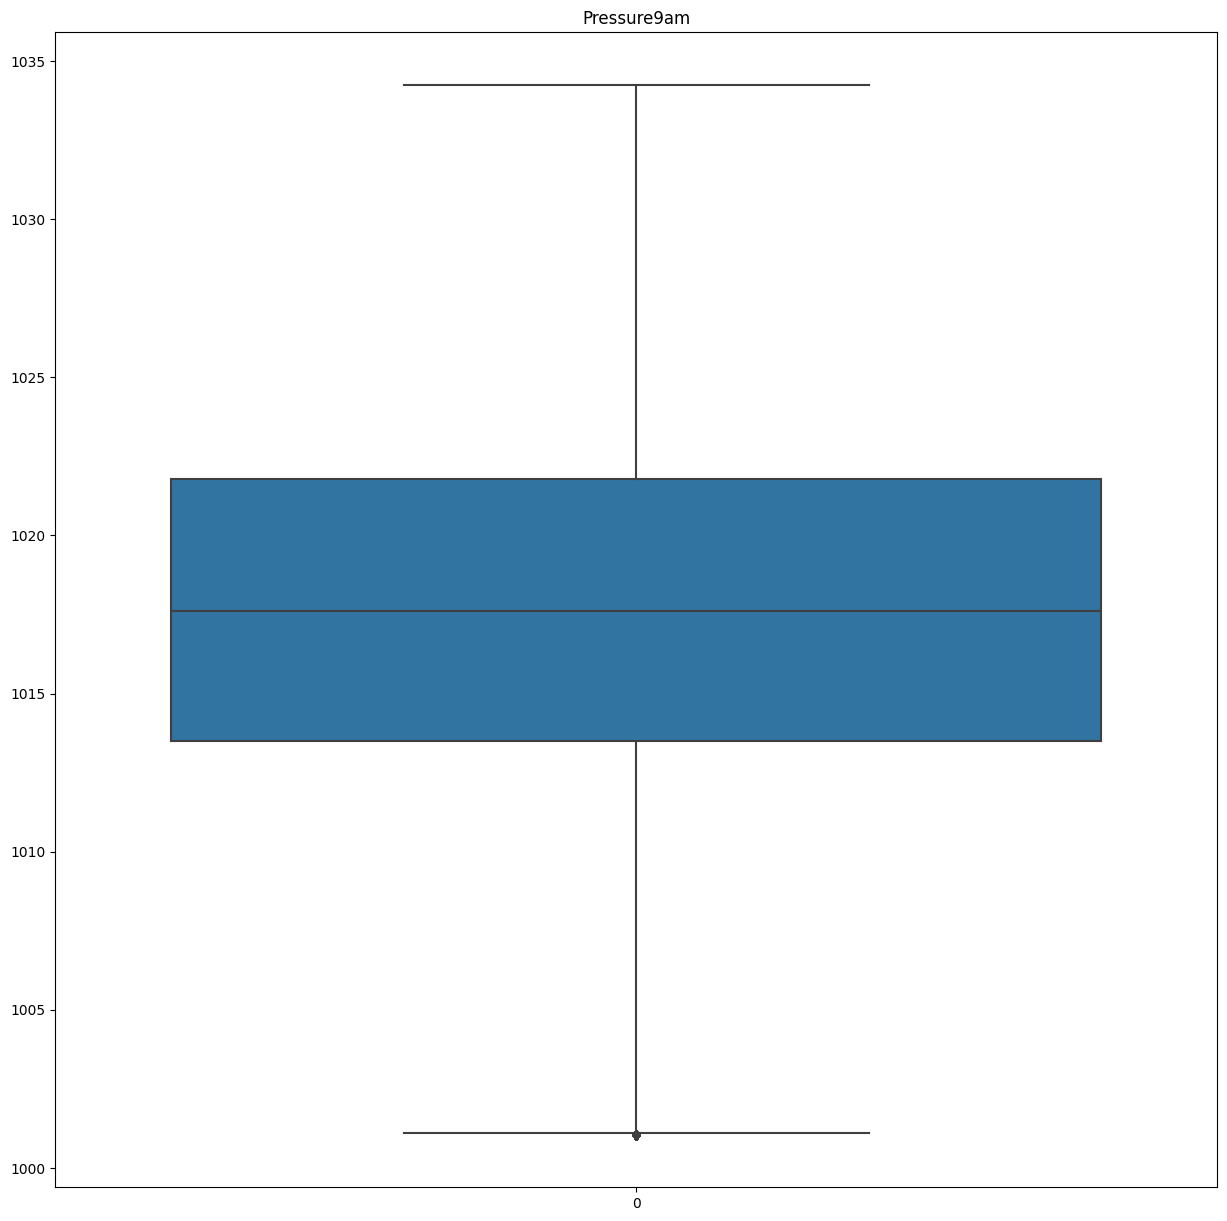

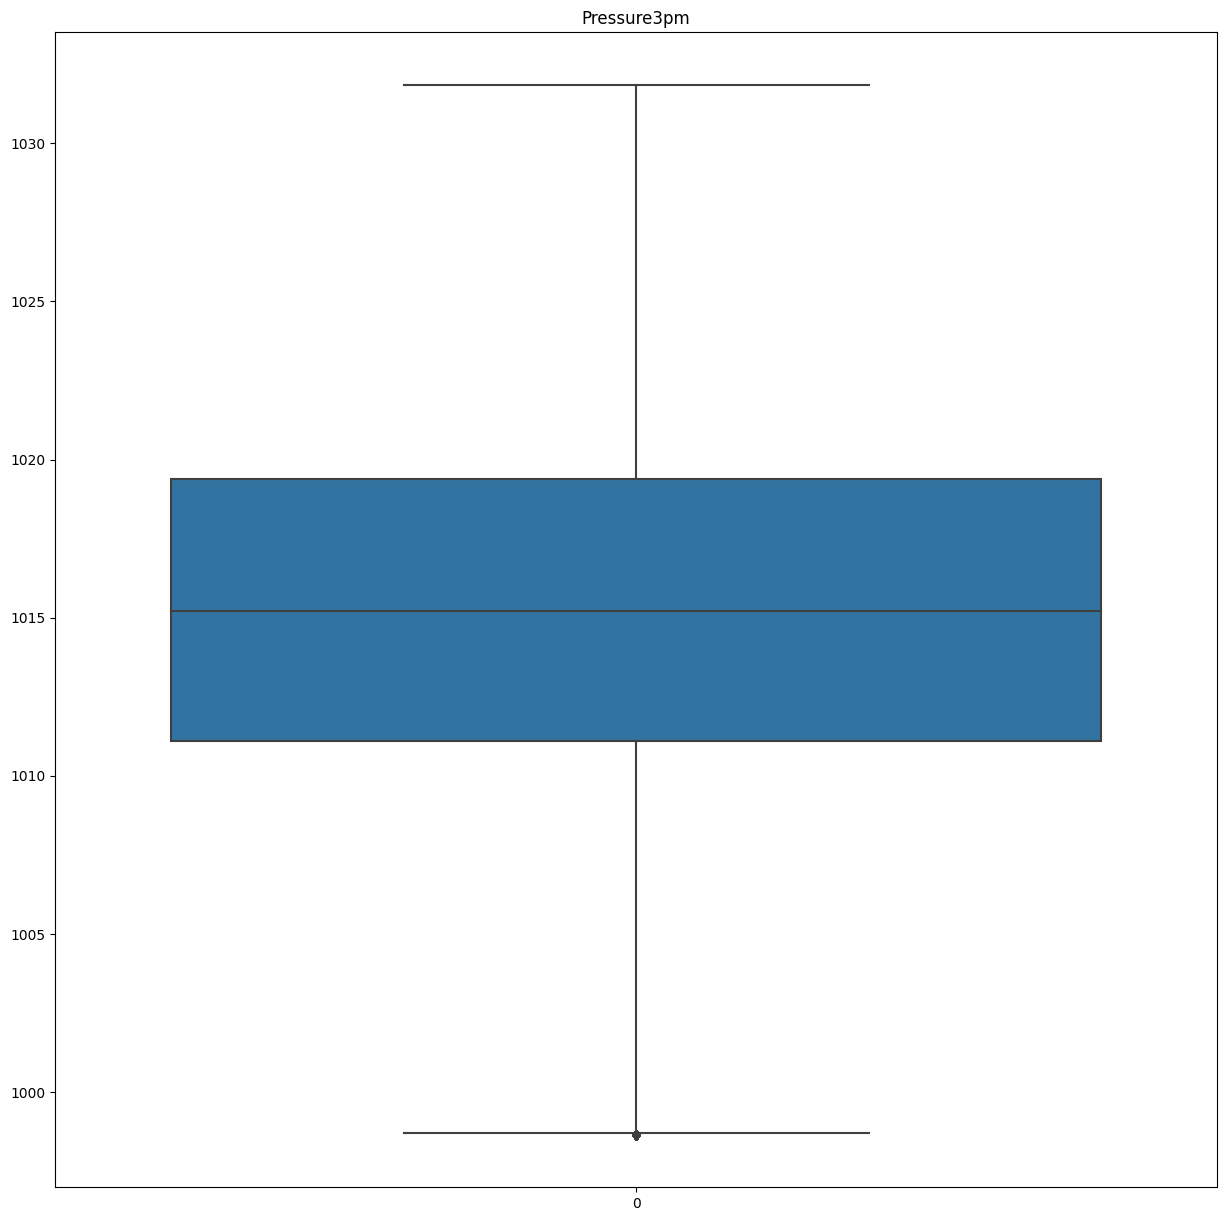

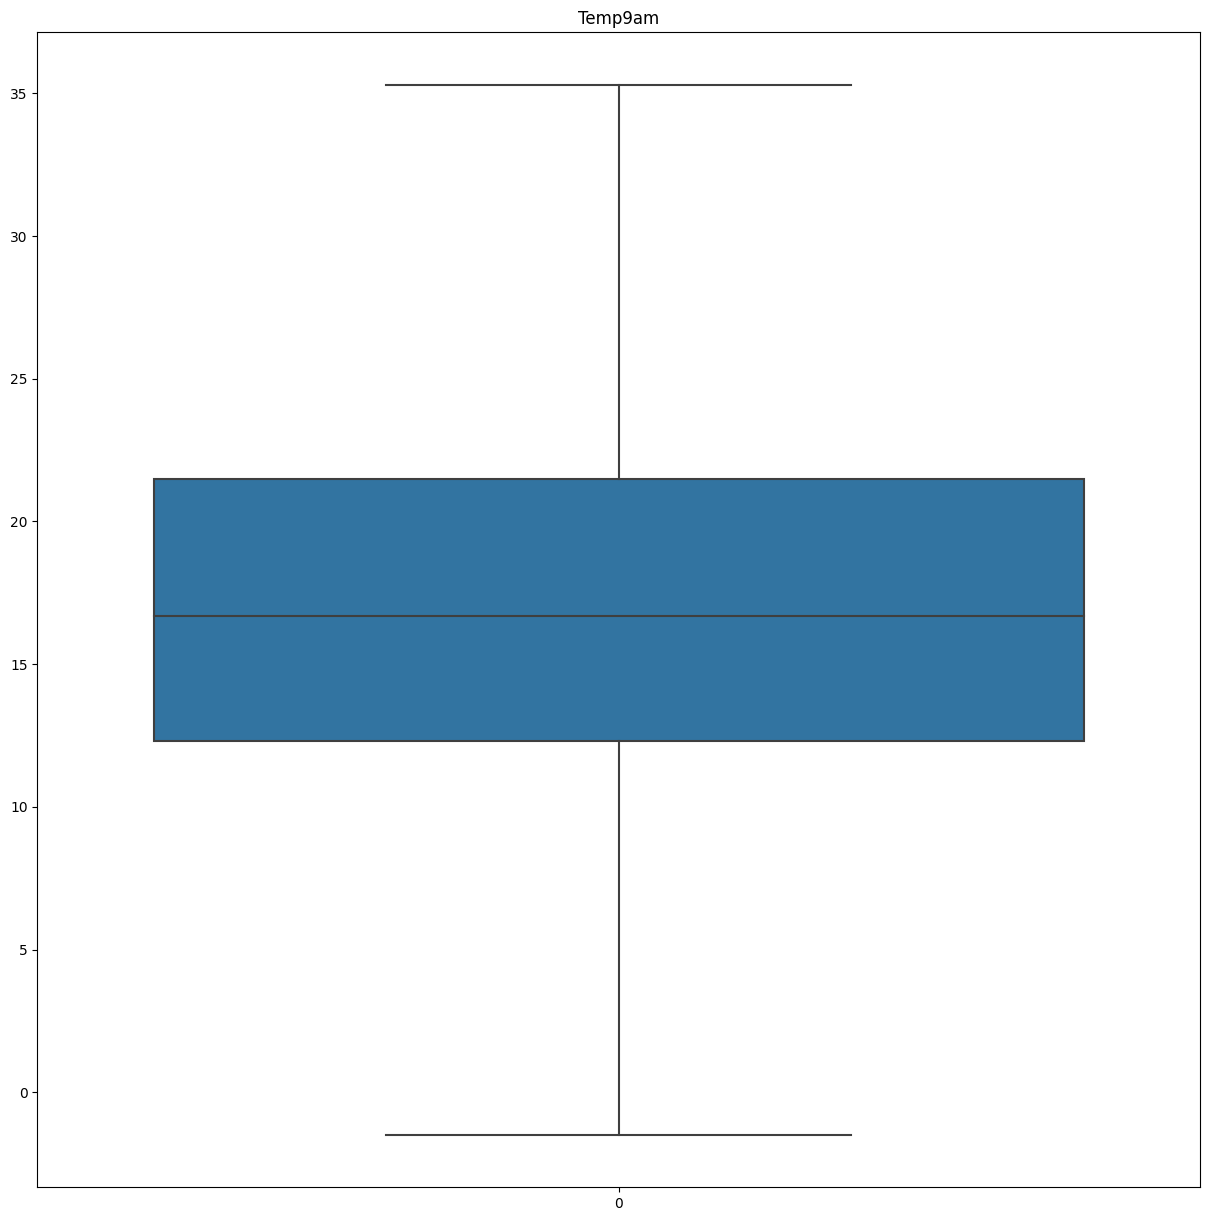

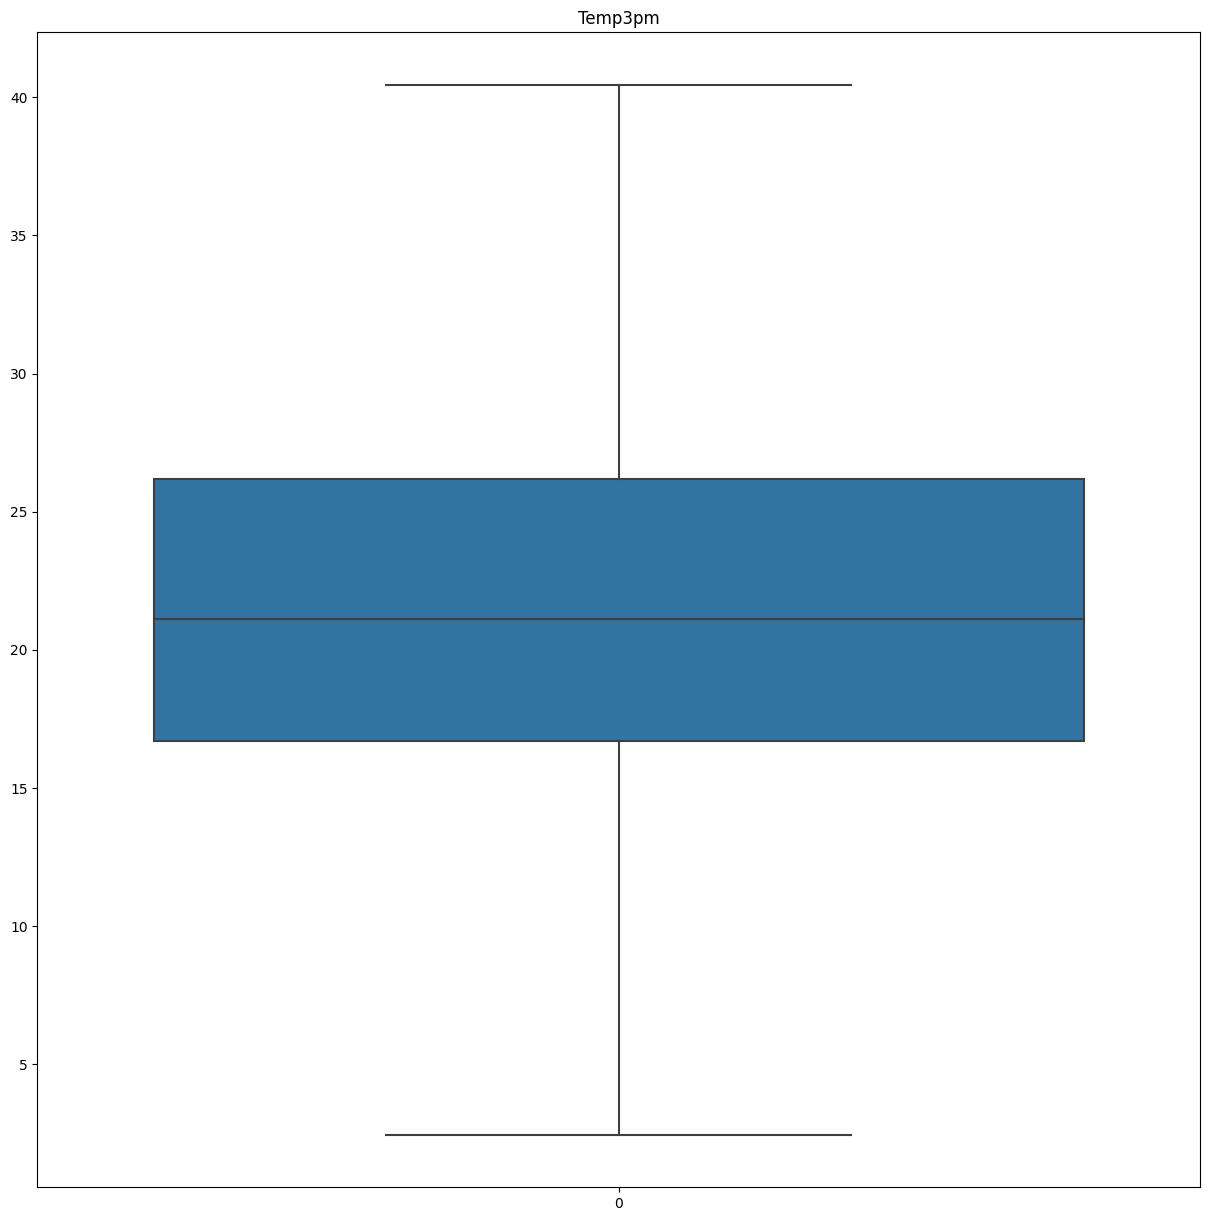

<Figure size 1500x1500 with 0 Axes>

In [59]:
for feature in continuous_feature:
    data=df.copy()
    sns.boxplot(data[feature])
    plt.title(feature)
    plt.figure(figsize=(15,15))

In [60]:
def qq_plots(df, variable):
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist()
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()

MinTemp


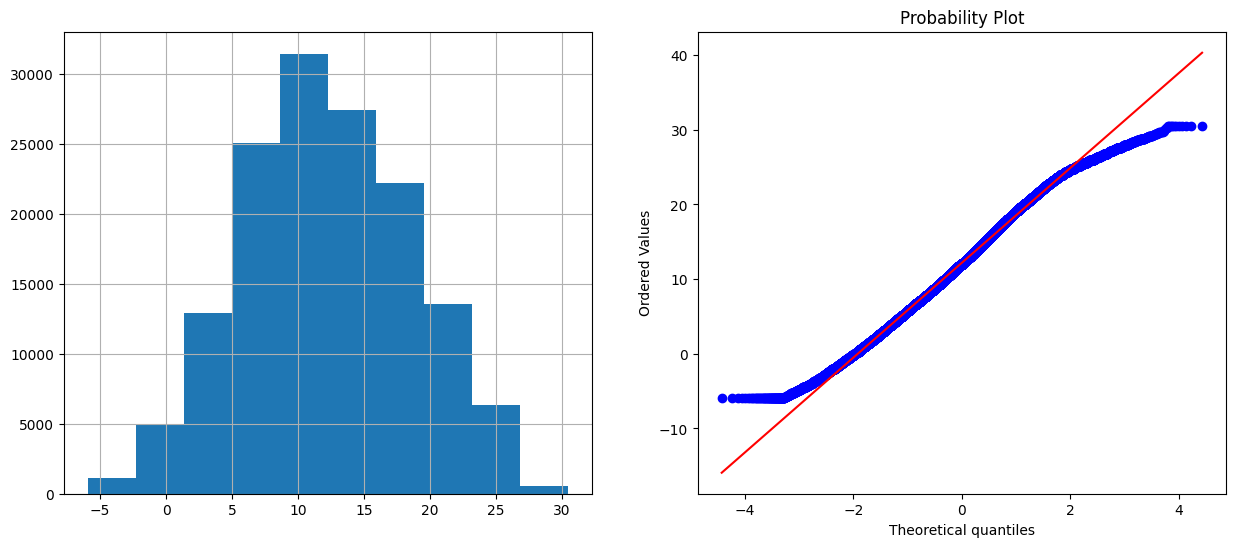

MaxTemp


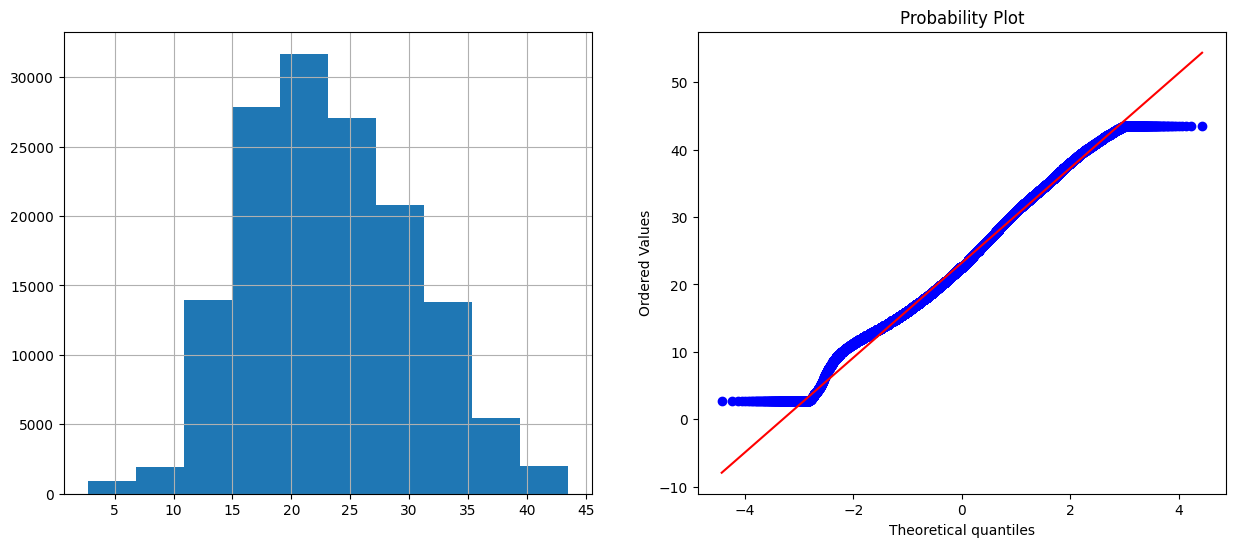

Rainfall


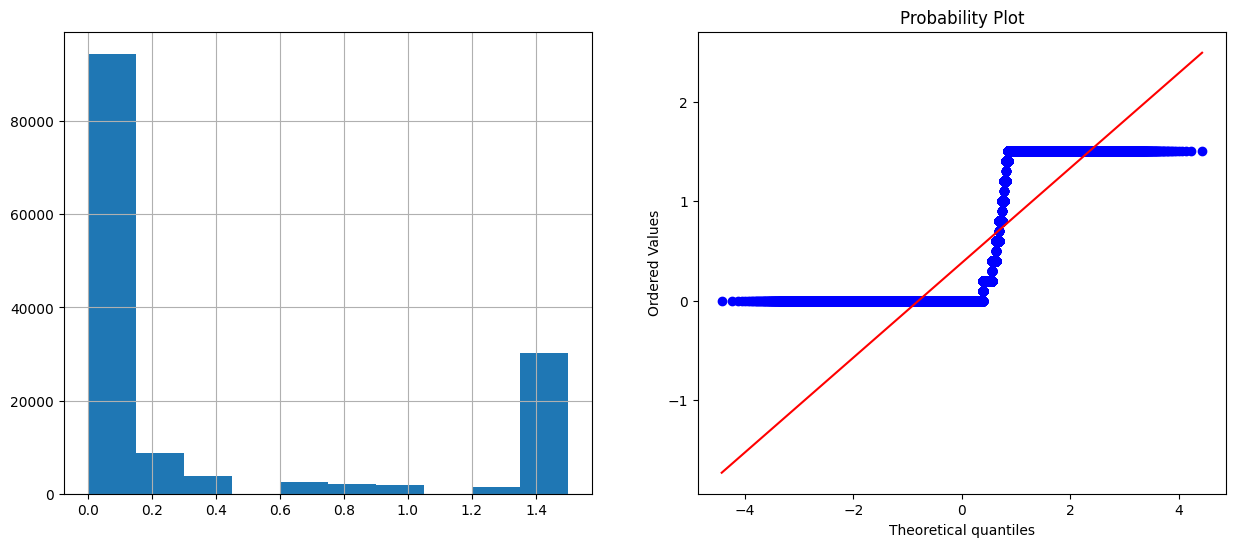

Evaporation


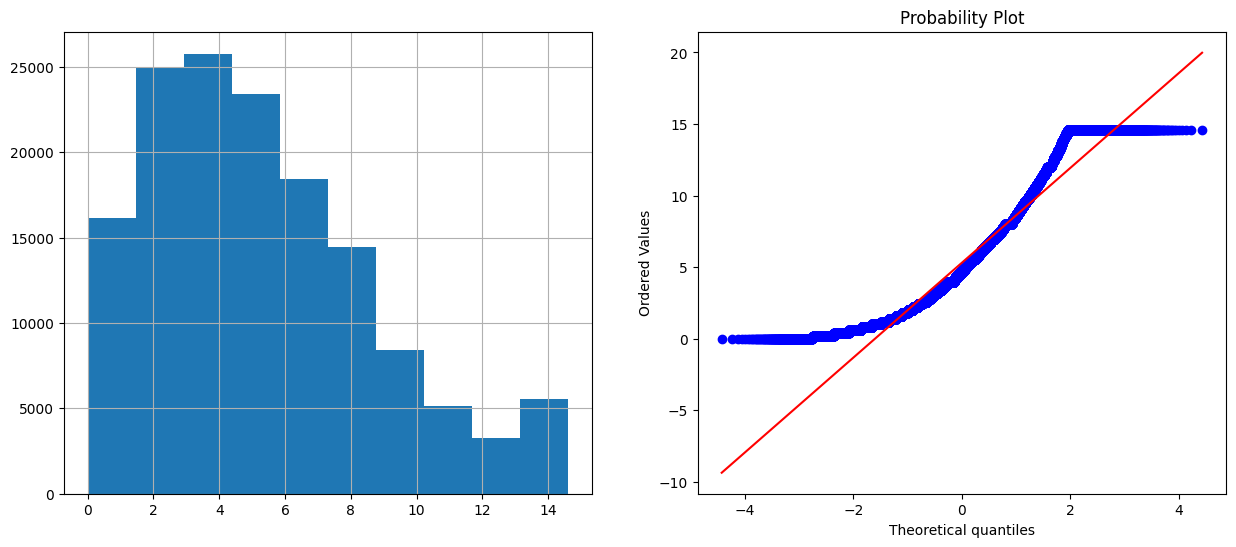

Sunshine


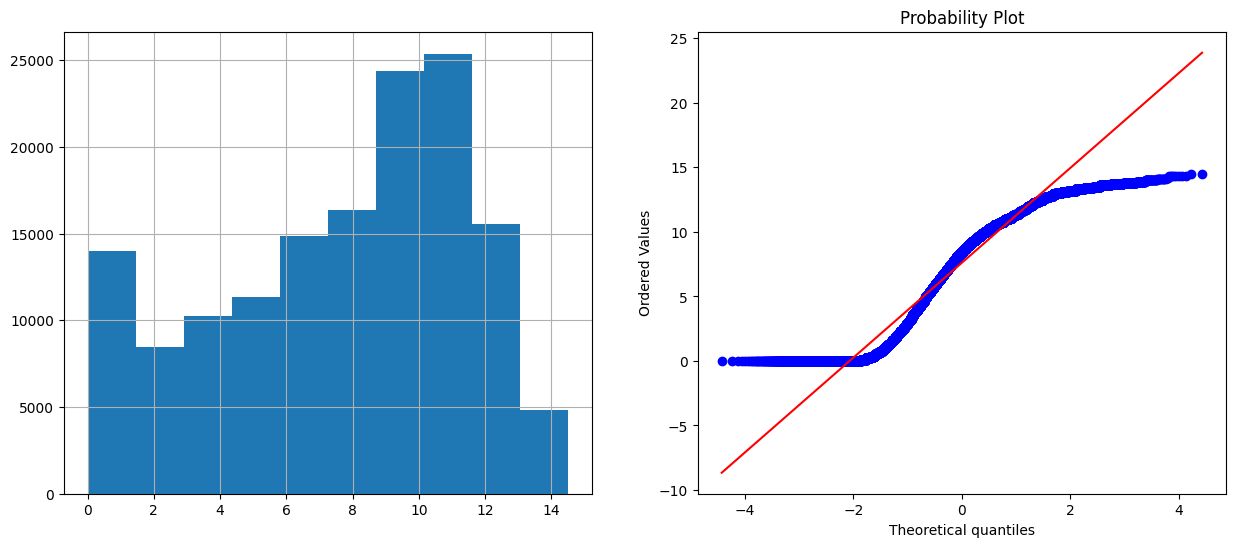

WindGustSpeed


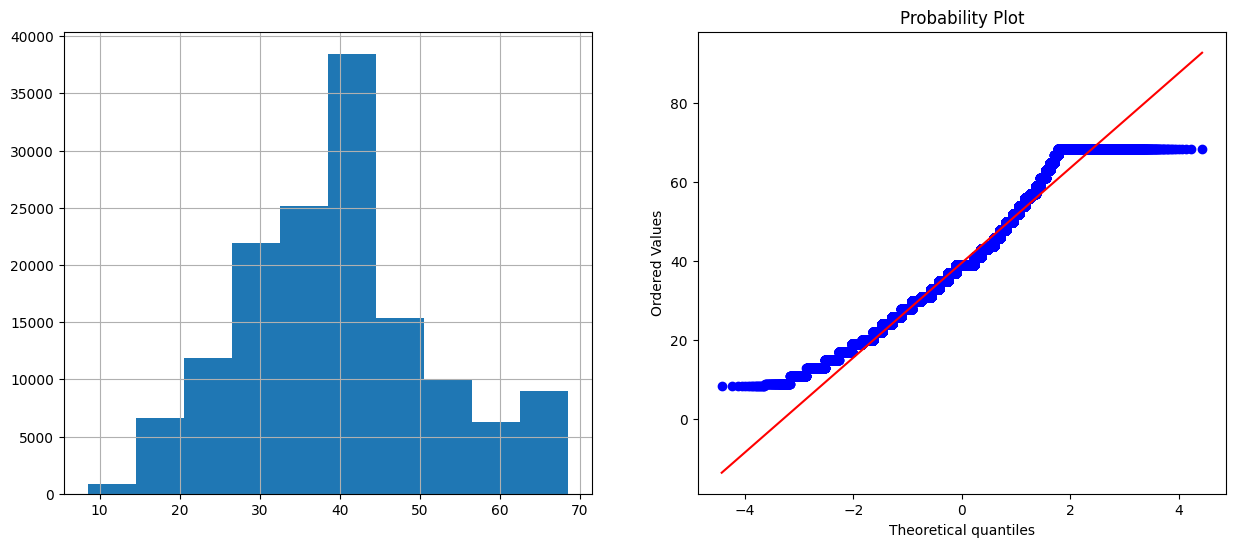

WindSpeed9am


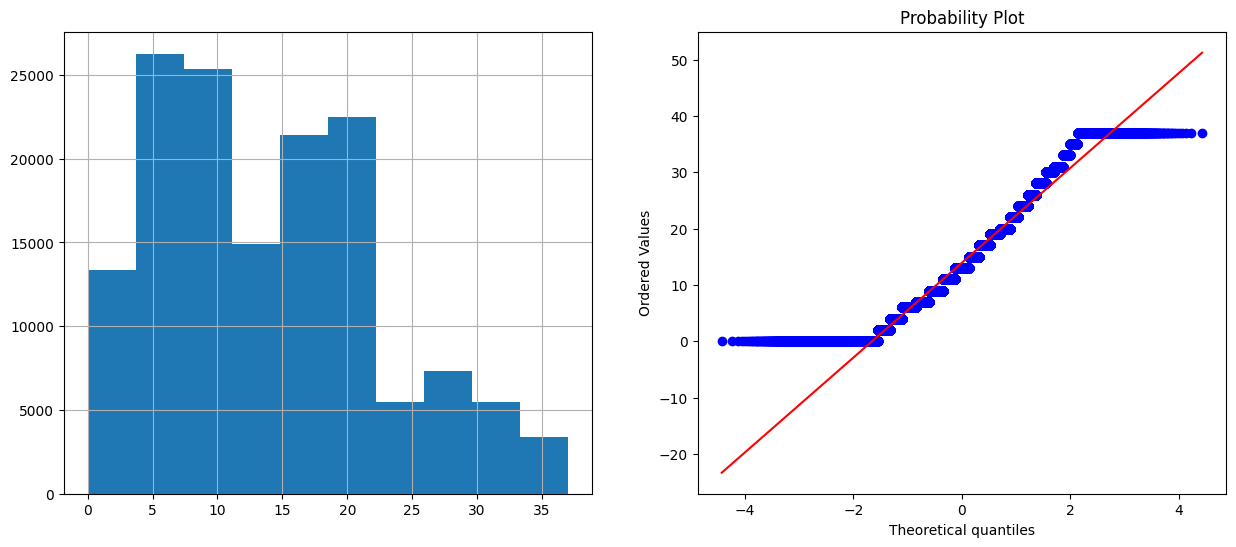

WindSpeed3pm


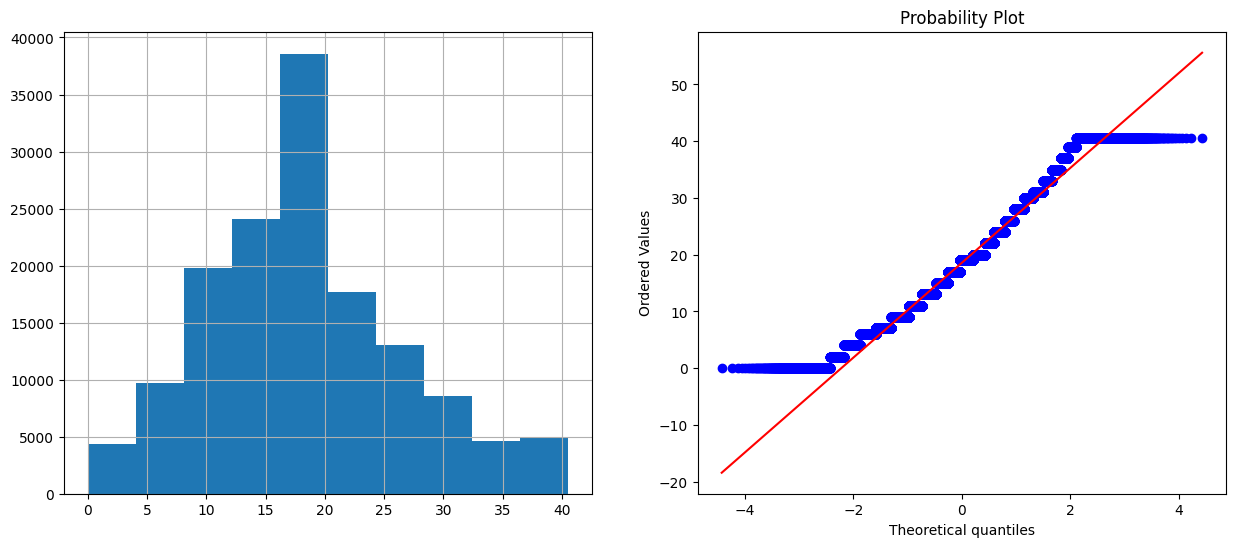

Humidity9am


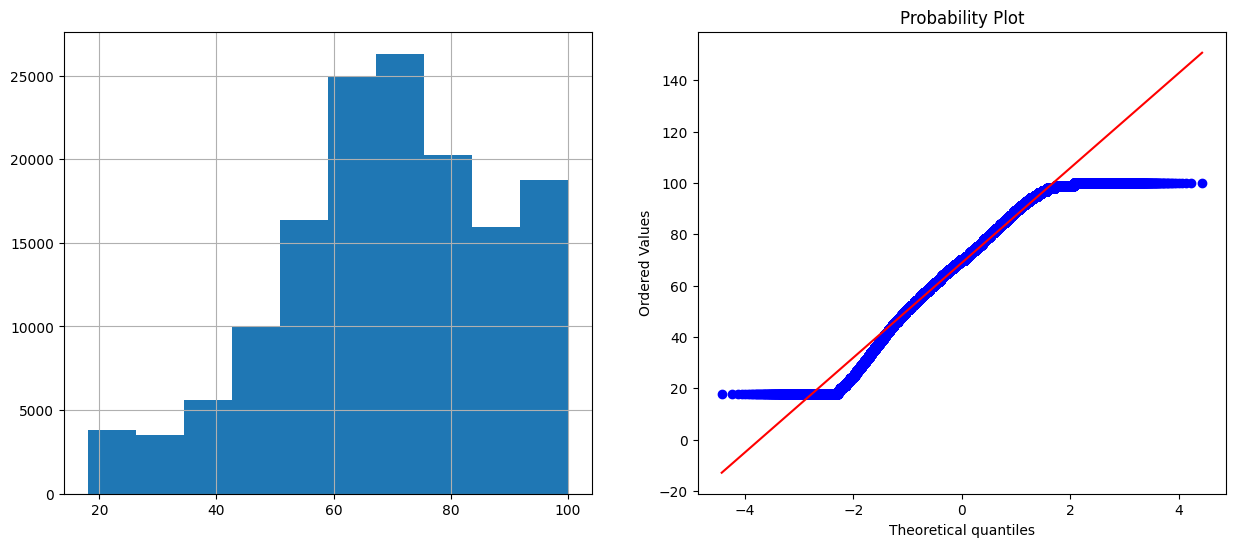

Humidity3pm


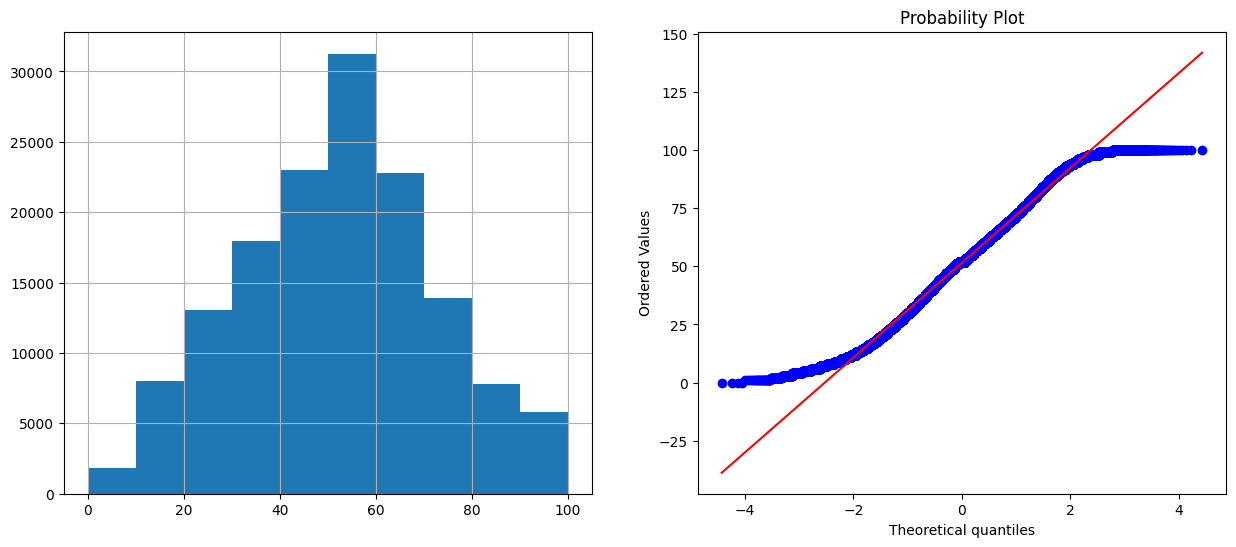

Pressure9am


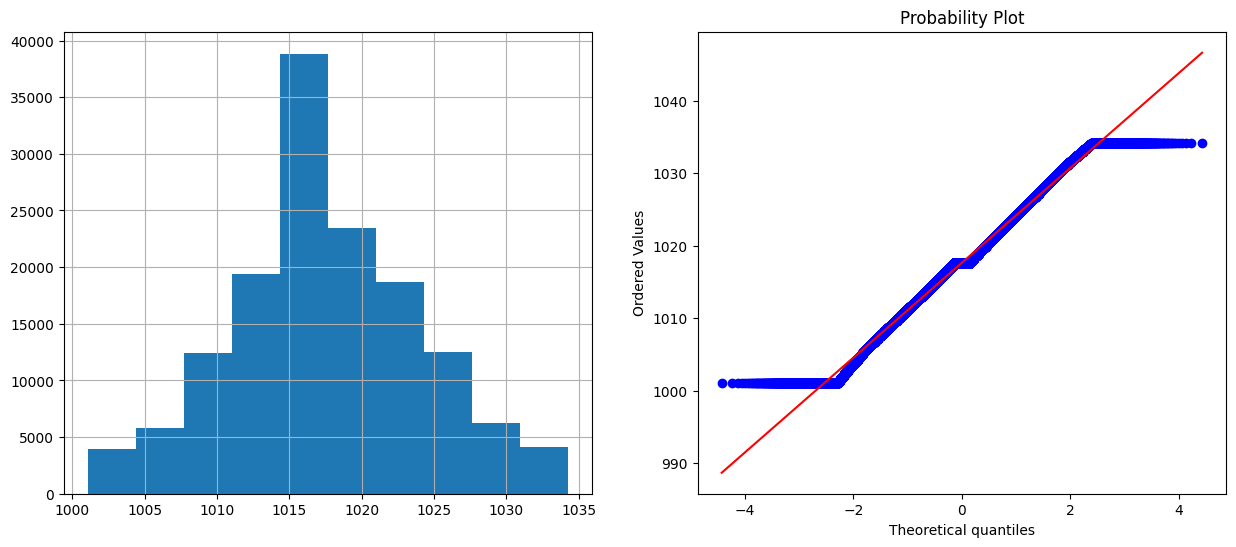

Pressure3pm


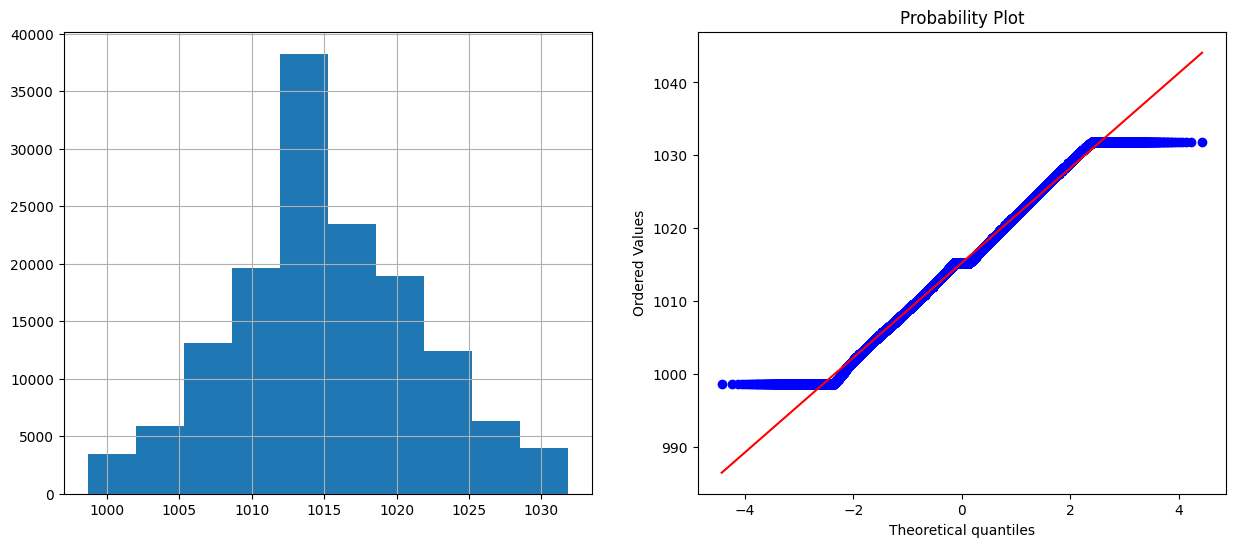

Temp9am


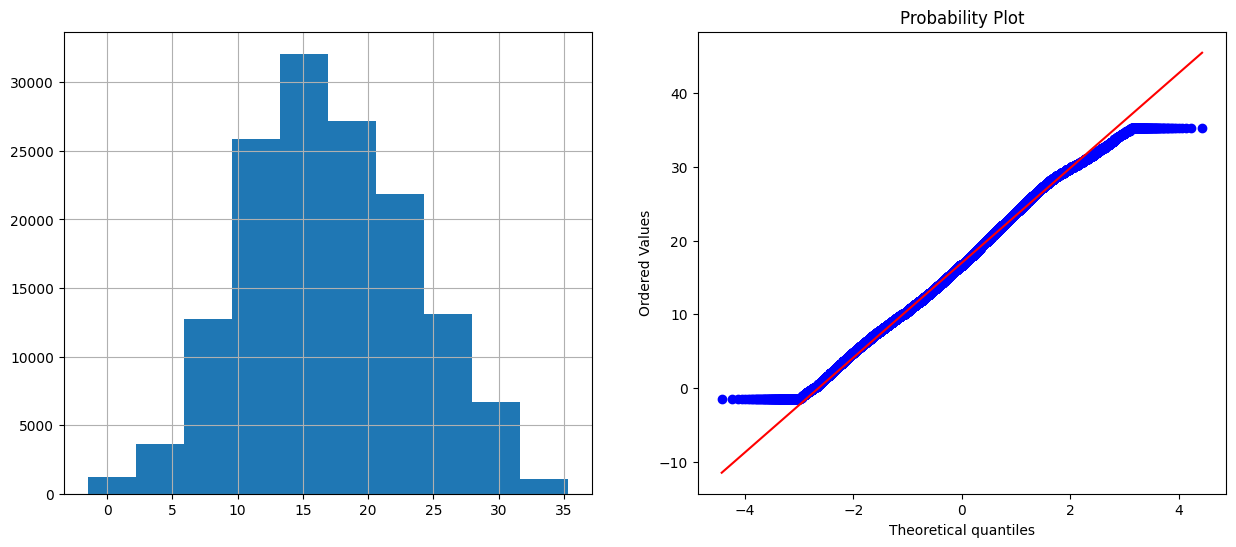

Temp3pm


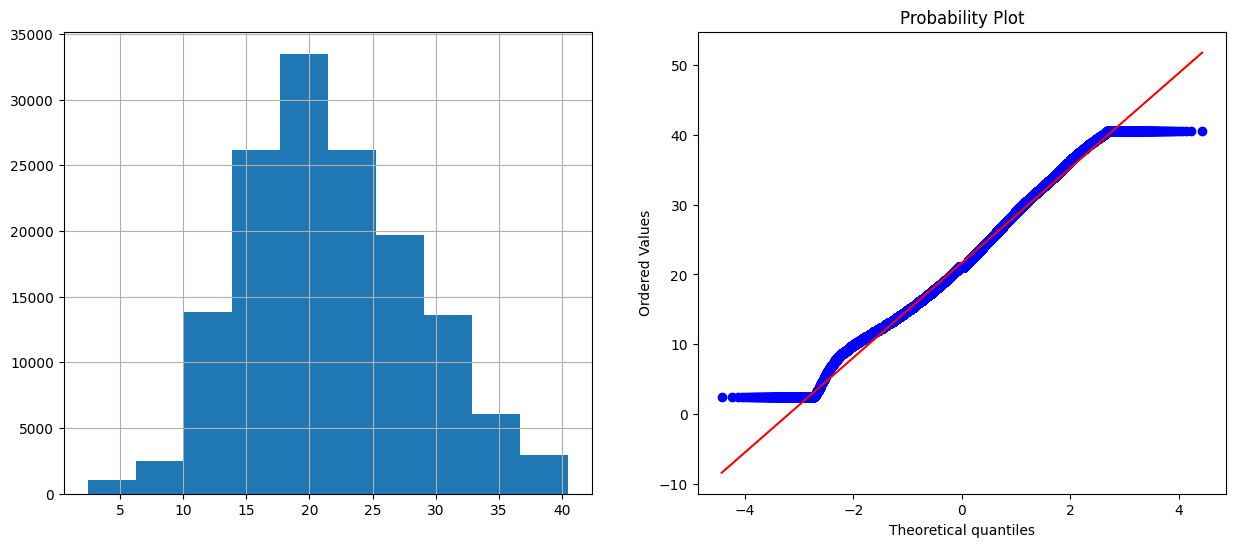

In [61]:
for feature in continuous_feature:
    print(feature)
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[feature].hist()
    plt.subplot(1, 2, 2)
    stats.probplot(df[feature], dist="norm", plot=plt)
    plt.show()

In [62]:
df.to_csv("preprocessed_1.csv", index=False)

In [63]:
X = df.drop(["CloudBurstTomorrow", "Date"], axis=1)
Y = df["CloudBurstTomorrow"]

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size =0.2, stratify = Y, random_state = 0)
X_train = X_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)
X_test = X_test.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [68]:
y_train

43447     0
140904    0
54615     0
109793    0
74462     0
         ..
106567    0
52791     1
56339     0
82299     1
115175    0
Name: CloudBurstTomorrow, Length: 116368, dtype: uint8

In [69]:
sm=SMOTE(random_state=0)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_res)))

The number of classes before fit Counter({0: 90866, 1: 25502})
The number of classes after fit Counter({0: 90866, 1: 90866})


In [70]:
cat = CatBoostClassifier(iterations=2000, eval_metric = "AUC")
cat.fit(X_train_res, y_train_res)

Learning rate set to 0.050311
0:	total: 220ms	remaining: 7m 19s
1:	total: 263ms	remaining: 4m 22s
2:	total: 305ms	remaining: 3m 22s
3:	total: 348ms	remaining: 2m 53s
4:	total: 390ms	remaining: 2m 35s
5:	total: 429ms	remaining: 2m 22s
6:	total: 473ms	remaining: 2m 14s
7:	total: 515ms	remaining: 2m 8s
8:	total: 555ms	remaining: 2m 2s
9:	total: 598ms	remaining: 1m 59s
10:	total: 640ms	remaining: 1m 55s
11:	total: 681ms	remaining: 1m 52s
12:	total: 722ms	remaining: 1m 50s
13:	total: 766ms	remaining: 1m 48s
14:	total: 804ms	remaining: 1m 46s
15:	total: 847ms	remaining: 1m 45s
16:	total: 894ms	remaining: 1m 44s
17:	total: 940ms	remaining: 1m 43s
18:	total: 983ms	remaining: 1m 42s
19:	total: 1.03s	remaining: 1m 41s
20:	total: 1.08s	remaining: 1m 41s
21:	total: 1.12s	remaining: 1m 40s
22:	total: 1.17s	remaining: 1m 40s
23:	total: 1.21s	remaining: 1m 39s
24:	total: 1.25s	remaining: 1m 39s
25:	total: 1.29s	remaining: 1m 38s
26:	total: 1.33s	remaining: 1m 37s
27:	total: 1.37s	remaining: 1m 36s
28

231:	total: 10s	remaining: 1m 16s
232:	total: 10.1s	remaining: 1m 16s
233:	total: 10.1s	remaining: 1m 16s
234:	total: 10.1s	remaining: 1m 16s
235:	total: 10.2s	remaining: 1m 16s
236:	total: 10.2s	remaining: 1m 15s
237:	total: 10.3s	remaining: 1m 15s
238:	total: 10.3s	remaining: 1m 15s
239:	total: 10.3s	remaining: 1m 15s
240:	total: 10.4s	remaining: 1m 15s
241:	total: 10.4s	remaining: 1m 15s
242:	total: 10.5s	remaining: 1m 15s
243:	total: 10.5s	remaining: 1m 15s
244:	total: 10.5s	remaining: 1m 15s
245:	total: 10.6s	remaining: 1m 15s
246:	total: 10.6s	remaining: 1m 15s
247:	total: 10.7s	remaining: 1m 15s
248:	total: 10.7s	remaining: 1m 15s
249:	total: 10.8s	remaining: 1m 15s
250:	total: 10.8s	remaining: 1m 15s
251:	total: 10.8s	remaining: 1m 15s
252:	total: 10.9s	remaining: 1m 15s
253:	total: 10.9s	remaining: 1m 15s
254:	total: 11s	remaining: 1m 15s
255:	total: 11s	remaining: 1m 15s
256:	total: 11.1s	remaining: 1m 14s
257:	total: 11.1s	remaining: 1m 14s
258:	total: 11.1s	remaining: 1m 14

467:	total: 19.9s	remaining: 1m 5s
468:	total: 19.9s	remaining: 1m 5s
469:	total: 20s	remaining: 1m 4s
470:	total: 20s	remaining: 1m 4s
471:	total: 20s	remaining: 1m 4s
472:	total: 20.1s	remaining: 1m 4s
473:	total: 20.1s	remaining: 1m 4s
474:	total: 20.2s	remaining: 1m 4s
475:	total: 20.2s	remaining: 1m 4s
476:	total: 20.3s	remaining: 1m 4s
477:	total: 20.3s	remaining: 1m 4s
478:	total: 20.3s	remaining: 1m 4s
479:	total: 20.4s	remaining: 1m 4s
480:	total: 20.4s	remaining: 1m 4s
481:	total: 20.5s	remaining: 1m 4s
482:	total: 20.5s	remaining: 1m 4s
483:	total: 20.5s	remaining: 1m 4s
484:	total: 20.6s	remaining: 1m 4s
485:	total: 20.6s	remaining: 1m 4s
486:	total: 20.7s	remaining: 1m 4s
487:	total: 20.7s	remaining: 1m 4s
488:	total: 20.7s	remaining: 1m 4s
489:	total: 20.8s	remaining: 1m 4s
490:	total: 20.8s	remaining: 1m 3s
491:	total: 20.9s	remaining: 1m 3s
492:	total: 20.9s	remaining: 1m 3s
493:	total: 20.9s	remaining: 1m 3s
494:	total: 21s	remaining: 1m 3s
495:	total: 21s	remaining: 1

708:	total: 29.8s	remaining: 54.2s
709:	total: 29.8s	remaining: 54.1s
710:	total: 29.8s	remaining: 54.1s
711:	total: 29.9s	remaining: 54.1s
712:	total: 29.9s	remaining: 54s
713:	total: 30s	remaining: 54s
714:	total: 30s	remaining: 53.9s
715:	total: 30.1s	remaining: 53.9s
716:	total: 30.1s	remaining: 53.8s
717:	total: 30.1s	remaining: 53.8s
718:	total: 30.2s	remaining: 53.7s
719:	total: 30.2s	remaining: 53.7s
720:	total: 30.2s	remaining: 53.7s
721:	total: 30.3s	remaining: 53.6s
722:	total: 30.3s	remaining: 53.6s
723:	total: 30.4s	remaining: 53.5s
724:	total: 30.4s	remaining: 53.5s
725:	total: 30.4s	remaining: 53.4s
726:	total: 30.5s	remaining: 53.4s
727:	total: 30.5s	remaining: 53.3s
728:	total: 30.6s	remaining: 53.3s
729:	total: 30.6s	remaining: 53.2s
730:	total: 30.6s	remaining: 53.2s
731:	total: 30.7s	remaining: 53.2s
732:	total: 30.7s	remaining: 53.1s
733:	total: 30.8s	remaining: 53.1s
734:	total: 30.8s	remaining: 53s
735:	total: 30.8s	remaining: 53s
736:	total: 30.9s	remaining: 52.

950:	total: 39.6s	remaining: 43.7s
951:	total: 39.7s	remaining: 43.7s
952:	total: 39.7s	remaining: 43.6s
953:	total: 39.8s	remaining: 43.6s
954:	total: 39.8s	remaining: 43.5s
955:	total: 39.8s	remaining: 43.5s
956:	total: 39.9s	remaining: 43.5s
957:	total: 39.9s	remaining: 43.4s
958:	total: 40s	remaining: 43.4s
959:	total: 40s	remaining: 43.3s
960:	total: 40s	remaining: 43.3s
961:	total: 40.1s	remaining: 43.3s
962:	total: 40.1s	remaining: 43.2s
963:	total: 40.2s	remaining: 43.2s
964:	total: 40.2s	remaining: 43.1s
965:	total: 40.3s	remaining: 43.1s
966:	total: 40.3s	remaining: 43s
967:	total: 40.3s	remaining: 43s
968:	total: 40.4s	remaining: 43s
969:	total: 40.4s	remaining: 42.9s
970:	total: 40.5s	remaining: 42.9s
971:	total: 40.5s	remaining: 42.8s
972:	total: 40.5s	remaining: 42.8s
973:	total: 40.6s	remaining: 42.8s
974:	total: 40.6s	remaining: 42.7s
975:	total: 40.7s	remaining: 42.7s
976:	total: 40.7s	remaining: 42.6s
977:	total: 40.8s	remaining: 42.6s
978:	total: 40.8s	remaining: 42.

1186:	total: 49.3s	remaining: 33.7s
1187:	total: 49.3s	remaining: 33.7s
1188:	total: 49.3s	remaining: 33.6s
1189:	total: 49.4s	remaining: 33.6s
1190:	total: 49.4s	remaining: 33.6s
1191:	total: 49.5s	remaining: 33.5s
1192:	total: 49.5s	remaining: 33.5s
1193:	total: 49.5s	remaining: 33.4s
1194:	total: 49.6s	remaining: 33.4s
1195:	total: 49.6s	remaining: 33.4s
1196:	total: 49.7s	remaining: 33.3s
1197:	total: 49.7s	remaining: 33.3s
1198:	total: 49.8s	remaining: 33.2s
1199:	total: 49.8s	remaining: 33.2s
1200:	total: 49.8s	remaining: 33.2s
1201:	total: 49.9s	remaining: 33.1s
1202:	total: 49.9s	remaining: 33.1s
1203:	total: 50s	remaining: 33s
1204:	total: 50s	remaining: 33s
1205:	total: 50.1s	remaining: 33s
1206:	total: 50.1s	remaining: 32.9s
1207:	total: 50.1s	remaining: 32.9s
1208:	total: 50.2s	remaining: 32.8s
1209:	total: 50.2s	remaining: 32.8s
1210:	total: 50.3s	remaining: 32.8s
1211:	total: 50.3s	remaining: 32.7s
1212:	total: 50.3s	remaining: 32.7s
1213:	total: 50.4s	remaining: 32.6s
12

1417:	total: 58.6s	remaining: 24.1s
1418:	total: 58.6s	remaining: 24s
1419:	total: 58.7s	remaining: 24s
1420:	total: 58.7s	remaining: 23.9s
1421:	total: 58.8s	remaining: 23.9s
1422:	total: 58.8s	remaining: 23.8s
1423:	total: 58.8s	remaining: 23.8s
1424:	total: 58.9s	remaining: 23.8s
1425:	total: 58.9s	remaining: 23.7s
1426:	total: 59s	remaining: 23.7s
1427:	total: 59s	remaining: 23.6s
1428:	total: 59s	remaining: 23.6s
1429:	total: 59.1s	remaining: 23.5s
1430:	total: 59.1s	remaining: 23.5s
1431:	total: 59.2s	remaining: 23.5s
1432:	total: 59.2s	remaining: 23.4s
1433:	total: 59.2s	remaining: 23.4s
1434:	total: 59.3s	remaining: 23.3s
1435:	total: 59.3s	remaining: 23.3s
1436:	total: 59.4s	remaining: 23.3s
1437:	total: 59.4s	remaining: 23.2s
1438:	total: 59.5s	remaining: 23.2s
1439:	total: 59.5s	remaining: 23.1s
1440:	total: 59.5s	remaining: 23.1s
1441:	total: 59.6s	remaining: 23.1s
1442:	total: 59.6s	remaining: 23s
1443:	total: 59.7s	remaining: 23s
1444:	total: 59.7s	remaining: 22.9s
1445:	

1649:	total: 1m 8s	remaining: 14.4s
1650:	total: 1m 8s	remaining: 14.4s
1651:	total: 1m 8s	remaining: 14.4s
1652:	total: 1m 8s	remaining: 14.3s
1653:	total: 1m 8s	remaining: 14.3s
1654:	total: 1m 8s	remaining: 14.2s
1655:	total: 1m 8s	remaining: 14.2s
1656:	total: 1m 8s	remaining: 14.1s
1657:	total: 1m 8s	remaining: 14.1s
1658:	total: 1m 8s	remaining: 14.1s
1659:	total: 1m 8s	remaining: 14s
1660:	total: 1m 8s	remaining: 14s
1661:	total: 1m 8s	remaining: 13.9s
1662:	total: 1m 8s	remaining: 13.9s
1663:	total: 1m 8s	remaining: 13.9s
1664:	total: 1m 8s	remaining: 13.8s
1665:	total: 1m 8s	remaining: 13.8s
1666:	total: 1m 8s	remaining: 13.7s
1667:	total: 1m 8s	remaining: 13.7s
1668:	total: 1m 8s	remaining: 13.6s
1669:	total: 1m 8s	remaining: 13.6s
1670:	total: 1m 8s	remaining: 13.6s
1671:	total: 1m 8s	remaining: 13.5s
1672:	total: 1m 9s	remaining: 13.5s
1673:	total: 1m 9s	remaining: 13.4s
1674:	total: 1m 9s	remaining: 13.4s
1675:	total: 1m 9s	remaining: 13.4s
1676:	total: 1m 9s	remaining: 13

1875:	total: 1m 17s	remaining: 5.1s
1876:	total: 1m 17s	remaining: 5.06s
1877:	total: 1m 17s	remaining: 5.02s
1878:	total: 1m 17s	remaining: 4.98s
1879:	total: 1m 17s	remaining: 4.94s
1880:	total: 1m 17s	remaining: 4.9s
1881:	total: 1m 17s	remaining: 4.86s
1882:	total: 1m 17s	remaining: 4.82s
1883:	total: 1m 17s	remaining: 4.77s
1884:	total: 1m 17s	remaining: 4.73s
1885:	total: 1m 17s	remaining: 4.69s
1886:	total: 1m 17s	remaining: 4.65s
1887:	total: 1m 17s	remaining: 4.61s
1888:	total: 1m 17s	remaining: 4.57s
1889:	total: 1m 17s	remaining: 4.53s
1890:	total: 1m 17s	remaining: 4.49s
1891:	total: 1m 17s	remaining: 4.44s
1892:	total: 1m 17s	remaining: 4.4s
1893:	total: 1m 17s	remaining: 4.36s
1894:	total: 1m 17s	remaining: 4.32s
1895:	total: 1m 18s	remaining: 4.28s
1896:	total: 1m 18s	remaining: 4.24s
1897:	total: 1m 18s	remaining: 4.2s
1898:	total: 1m 18s	remaining: 4.16s
1899:	total: 1m 18s	remaining: 4.11s
1900:	total: 1m 18s	remaining: 4.07s
1901:	total: 1m 18s	remaining: 4.03s
1902:

In [71]:
y_pred = cat.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[21513  1204]
 [ 2820  3555]]
0.8616801869929878
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     22717
           1       0.75      0.56      0.64      6375

    accuracy                           0.86     29092
   macro avg       0.82      0.75      0.78     29092
weighted avg       0.85      0.86      0.85     29092



In [72]:
rf=RandomForestClassifier()
rf.fit(X_train_res,y_train_res)

RandomForestClassifier()

In [73]:
y_pred1 = rf.predict(X_test)
print(confusion_matrix(y_test,y_pred1))
print(accuracy_score(y_test,y_pred1))
print(classification_report(y_test,y_pred1))

[[20659  2058]
 [ 2463  3912]]
0.8445964526330263
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     22717
           1       0.66      0.61      0.63      6375

    accuracy                           0.84     29092
   macro avg       0.77      0.76      0.77     29092
weighted avg       0.84      0.84      0.84     29092



In [74]:
logreg = LogisticRegression()
logreg.fit(X_train_res, y_train_res)

C:\Users\gubil\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [75]:
y_pred2 = logreg.predict(X_test)
print(confusion_matrix(y_test,y_pred2))
print(accuracy_score(y_test,y_pred2))
print(classification_report(y_test,y_pred2))

[[17513  5204]
 [ 1516  4859]]
0.7690086621751684
              precision    recall  f1-score   support

           0       0.92      0.77      0.84     22717
           1       0.48      0.76      0.59      6375

    accuracy                           0.77     29092
   macro avg       0.70      0.77      0.72     29092
weighted avg       0.82      0.77      0.78     29092



In [76]:
gnb = GaussianNB()
gnb.fit(X_train_res, y_train_res)

GaussianNB()

In [77]:
y_pred3 = gnb.predict(X_test)
print(confusion_matrix(y_test,y_pred3))
print(accuracy_score(y_test,y_pred3))
print(classification_report(y_test,y_pred3))

[[17057  5660]
 [ 1662  4713]]
0.7483156881616939
              precision    recall  f1-score   support

           0       0.91      0.75      0.82     22717
           1       0.45      0.74      0.56      6375

    accuracy                           0.75     29092
   macro avg       0.68      0.75      0.69     29092
weighted avg       0.81      0.75      0.77     29092



In [78]:
from sklearn.metrics import roc_curve

In [79]:
metrics.roc_auc_score(y_test, y_pred3, average=None)

0.7450707503320914

In [80]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_res, y_train_res)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
#mse,rsme,r2mape

In [81]:
y_pred4 = knn.predict(X_test)
print(confusion_matrix(y_test,y_pred4))
print(accuracy_score(y_test,y_pred4))
print(classification_report(y_test,y_pred4))

[[17445  5272]
 [ 1844  4531]]
0.7553966726247766
              precision    recall  f1-score   support

           0       0.90      0.77      0.83     22717
           1       0.46      0.71      0.56      6375

    accuracy                           0.76     29092
   macro avg       0.68      0.74      0.70     29092
weighted avg       0.81      0.76      0.77     29092



In [82]:
xgb = XGBClassifier()
xgb.fit(X_train_res, y_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [83]:
y_pred6 = xgb.predict(X_test)
print(confusion_matrix(y_test,y_pred6))
print(accuracy_score(y_test,y_pred6))
print(classification_report(y_test,y_pred6))

[[21377  1340]
 [ 2881  3494]]
0.8549085659287776
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     22717
           1       0.72      0.55      0.62      6375

    accuracy                           0.85     29092
   macro avg       0.80      0.74      0.77     29092
weighted avg       0.85      0.85      0.85     29092



In [85]:
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier()
dt.fit(X_train_res, y_train_res)

DecisionTreeClassifier()

In [86]:
y_pred10 = dt.predict(X_test)
print(confusion_matrix(y_test,y_pred10))
print(accuracy_score(y_test,y_pred10))
print(classification_report(y_test,y_pred10))

[[18877  3840]
 [ 2858  3517]]
0.7697648838168568
              precision    recall  f1-score   support

           0       0.87      0.83      0.85     22717
           1       0.48      0.55      0.51      6375

    accuracy                           0.77     29092
   macro avg       0.67      0.69      0.68     29092
weighted avg       0.78      0.77      0.78     29092



In [104]:
from sklearn.metrics import mean_squared_error

In [105]:
def mserror(y, y_pred):
    i=0
    for i in range (len(y)):
        i+=1
        mse = ((y - y_pred) ** 2).mean(y)   
        return mse

In [106]:
mse

<function sklearn.metrics._regression.mean_squared_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', squared=True)>

In [115]:
from sklearn.linear_model import LinearRegression
lr=LinearRegression()
lr.fit(X_train_res, y_train_res)

LinearRegression()

In [125]:
print('accuracy of catboost is:',accuracy_score(y_test,y_pred))
print('accuracy of randomforest is:',accuracy_score(y_test,y_pred1))
print('accuracy of logistic regression is:',accuracy_score(y_test,y_pred2))

print('accuracy of KNearestNeighbour is:',accuracy_score(y_test,y_pred4))
print('accuracy of XGBClassifier is:',accuracy_score(y_test,y_pred6))
print('accuracy of Decisiontree is:',accuracy_score(y_test,y_pred10))




accuracy of catboost is: 0.8616801869929878
accuracy of randomforest is: 0.8445964526330263
accuracy of logistic regression is: 0.7690086621751684
accuracy of KNearestNeighbour is: 0.7553966726247766
accuracy of XGBClassifier is: 0.8549085659287776
accuracy of Decisiontree is: 0.7697648838168568
